In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import re
from tqdm import tqdm
from itertools import product
from collections import Counter,defaultdict
from sklearn.model_selection import train_test_split, GroupKFold,StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV 
import lightgbm
from lightgbm import LGBMClassifier
import xgboost
from xgboost import plot_importance
from scipy.sparse import coo_matrix, vstack
import scipy
import pickle
import statistics
import random
import itertools

from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score, precision_score, recall_score
from sklearn import preprocessing
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from Bio import SeqIO

import seaborn as sns
sns.set_theme()

In [2]:
PATH_FEATURES = '../Features/'
PATH_SAMPLE_IDS = '../sample_ids/'
PATH_DATA = '../data/'
PATH_REPORTS = '../Reports/'
PATH_FIGS = '../figs/'
PATH_RANGED_REPORTS = '../Reports/ranged/'

In [4]:
meta_df=pd.read_csv(PATH_DATA+'data_table.tsv', sep='\t', index_col = 'refseq id')

# Test/train split

In [46]:
feature_df = pd.read_csv(PATH_FEATURES+'DNA_1'+'.csv', index_col=0).drop(index=['NC_009537', 'EU376394', 'KT923141', 'NC_001434', 'NC_038318', 'NC_038368', 'NC_038862', 'NC_038863', 'NC_043411', 'NC_043416', 'NC_002557'])

In [31]:
len(feature_df)

1390

In [5]:
def distribution_check(a, b, c):
    
    bad_split = False
    
    if a.keys() != b.keys():
        bad_split = True
        #print('Not enough classes')
        return(bad_split)
    
    if a['Insecta'] < 0.07:
            bad_split = True
            return(bad_split)
    if b['Insecta'] < 0.07:
            bad_split = True
            return(bad_split)

    for key in a.keys():
        
        if a[key] < c[key]-0.05: 
            bad_split = True
            return(bad_split)
        if b[key] < c[key]-0.05: 
            bad_split = True
            return(bad_split)       

        if abs(a[key] - b[key]) > 0.05:
            #print(key)
            bad_split = True
            return(bad_split)

    return(bad_split)

In [6]:
def get_data_pd(feature_set):
    X = pd.read_csv(PATH_FEATURES+feature_set[0]+'.csv', index_col=0)
    for feature in feature_set[1:]:
        X = X.join(pd.read_csv(PATH_FEATURES+feature+'.csv', index_col=0))
    return X

def create_feature_set(features, kmer_lists):
    feature_set = [f'{f}_{k}' for i,f in enumerate(features) for k in kmer_lists[i] ]
    return feature_set

def get_X_y(df_table, df_feature, gbac):
    
    df_feature['indices'] = range(len(df_feature))

    test_sample = df_feature.loc[gbac]
    y_test = list(df_table.loc[gbac]['host'])
    train_sample = df_feature[~df_feature.isin(test_sample)].dropna()
    y_train = list(df_table.loc[list(train_sample.index)]['host'])

    indices_test = test_sample['indices'].to_numpy()
    indices_train = df_feature.loc[train_sample.index]['indices'].to_numpy()
    
    y_test = np.array(y_test)
    y_train = np.array(y_train)
    X_test = test_sample.iloc[:, :-1].to_numpy()
    X_train = train_sample.iloc[:, :-1].to_numpy()
    
    print('X_test size:', len(X_test), 'X_train size:', len(X_train), 'y_test size:', len(y_test), 'y_train size:', len(y_train))

    return(X_test, X_train, y_test, y_train, indices_test, indices_train)  



def calc_models(models, X_train, y_train, X_test, y_test, meta_df, indices_test, indices_train):
    
    svc_classes = []
    cl_reps = [] 
    for el in models:
        
        if el == 'rf':
            rf = RandomForestClassifier().fit(X_train, y_train)
            y_pred = rf.predict(X_test)
            cl_reps.append(classification_report(y_test, y_pred, output_dict = True, zero_division=1))
            print(el, classification_report(y_test, y_pred))

        if el == 'lgbm':
            lgbm_model = LGBMClassifier().fit(X_train, y_train)
            y_pred = lgbm_model.predict(X_test)
            cl_reps.append(classification_report(y_test, y_pred, output_dict = True, zero_division=1))
            print(el, classification_report(y_test, y_pred))

        if el == 'xgb':
            le = LabelEncoder()
            y_train, y_test = le.fit_transform(y_train), le.fit_transform(y_test)
            xgb_model = xgboost.XGBClassifier(objective='multi:softprob').fit(X_train, y_train, eval_metric='auc')
            y_pred = xgb_model.predict(X_test)       
            cl_reps.append(classification_report(y_test, y_pred, output_dict = True, target_names = ['Insecta', 'Mammalia', 'Viridiplantae'], zero_division=1))
            print(el, classification_report(y_test, y_pred, target_names = ['Insecta', 'Mammalia', 'Viridiplantae'], zero_division=1))

        if el == 'svc':
              
            scale = True
            
            y_proba = np.zeros(shape=indices_test.shape)
            for y_class, class_name in tqdm(zip(list_y, classes)):
                y_train = y_class[indices_train]
                y_test = y_class[indices_test]

                if scale == True:
                    clf = make_pipeline(StandardScaler(), SVC(gamma='auto',probability=True))
                else:
                    clf = SVC(gamma='auto')
                    
                clf = clf.fit(X_train, y_train)
                y_pred = clf.predict(X_test)
                y_proba = np.vstack((y_proba, clf.predict_proba(X_test)[:,1]))
                print(class_name)
                print(classification_report(y_test, y_pred, target_names = ['Others', class_name], zero_division=1)) #output_dict=True
                svc_classes.append(classification_report(y_test, y_pred, output_dict=True, target_names = ['Others', class_name], zero_division=1))

            
            y_proba = y_proba[1:]
            y_proba = (y_proba/y_proba.sum(axis=0))


            y_pred_all = np.argmax(y_proba, axis=0)
            cl_reps.append(classification_report(y_int[indices_test], y_pred_all, output_dict = True, target_names = ['Insecta', 'Mammalia', 'Viridiplantae'], zero_division=1))
            print('F1-score (weighted):', round(f1_score(y_int[indices_test], y_pred_all, average='weighted'), 2))
            print('F1-score (macro):', round(f1_score(y_int[indices_test], y_pred_all, average='macro'), 2))
    return(cl_reps, svc_classes)

In [7]:
def family_splitter(df, list_families, family = None):
    '''
    list_families = ['Reoviridae',
                    'Birnaviridae',
                    'Picornaviridae',
                    'Caliciviridae', 
                    'Potyviridae',
                    'Coronaviridae',
                    'Astroviridae',
                    'Secoviridae',
                    'Bromoviridae',
                    'Nodaviridae',
                    'Dicistroviridae',
                    'Hepeviridae', 
                    'Rhabdoviridae',
                    'Paramyxoviridae', 
                    'Phasmaviridae',
                    'Bornaviridae']
    
    '''
    if family:
        future_sample_id, t_fam = [], [family]
        future_sample_id += list(df[df['virus family'] == family].index)
        return(future_sample_id, t_fam)
    
    else:
        z = random.choice(list_families)
        list_families.remove(z)
        l = len(df[df['virus family'] == z].index)
        a = round((l)/len(df), 3)
        t_fam = [z]

        print('Start', z, 'family_%: ' + str(round(len(df[df['virus family'] == z].index)*100/len(df), 3)), 'total_%: ' + str(round(a, 3)*100))
        mark = 0

        if a < 0.2:
            while a < 0.2 or a>=0.3:

                z = random.choice(list_families)

                mark+=1
                print('Cycle ' + str(mark), z, 'family_%: ' + str(round(len(df[df['virus family'] == z].index)*100/len(df), 3)), 'total_%: ' + str(round((a+round(len(df[df['virus family'] == z].index)/len(df), 3))*100, 3)))
                list_families.remove(z)
                a+=len(df[df['virus family'] == z].index)/len(df)
                a=round(a, 3)
                if a<0.2:
                    t_fam.append(z)
                if a>=0.2 and a<0.3:
                    t_fam.append(z)
                    break
                if a>=0.3:
                    a-=round(len(df[df['virus family'] == z].index)/len(df), 3)
        print('End' ,a, t_fam)

    future_sample_id =[]
    for fam in t_fam:
        future_sample_id += list(df[df['virus family'] == fam].index)

    if abs(round(len(future_sample_id)/len(df), 2) - round(a, 2)) <=0.1:   
        print('Result: True')
    else:
        print('Error', round(len(future_sample_id)/len(df), 2), round(a, 2))

    return(future_sample_id, t_fam)

uncrossing

In [38]:
good_split = True
while good_split:
    list_families = list(meta_df['virus family'].unique())
    future_sample_id, t_fam = family_splitter(meta_df, list_families) #, 'Rhabdoviridae')

    #print(feature_sets[0])
    X_test, X_train, y_test, y_train, indices_test, indices_train = get_X_y(meta_df, feature_df, future_sample_id)

    a = dict(zip(list(Counter(y_test).keys()), list(map(lambda x: round(x/len(y_test), 4), list(Counter(y_test).values())))))
    b = dict(zip(list(Counter(y_train).keys()), list(map(lambda x: round(x/len(y_train), 4), list(Counter(y_train).values())))))
    c = dict(zip(list(Counter(meta_df['host']).keys()), list(map(lambda x: round(x/len(meta_df), 3), list(Counter(meta_df['host']).values())))))
    good_split = distribution_check(a, b, c)

Start Carmotetraviridae family_%: 0.072 total_%: 0.1
Cycle 1 Parvoviridae family_%: 1.942 total_%: 2.0
Cycle 2 Mesoniviridae family_%: 0.863 total_%: 2.9
Cycle 3 Astroviridae family_%: 3.885 total_%: 6.8
Cycle 4 Peribunyaviridae family_%: 2.302 total_%: 9.1
Cycle 5 Flaviviridae family_%: 2.59 total_%: 11.7
Cycle 6 Metaviridae family_%: 0.072 total_%: 11.8
Cycle 7 Solinviviridae family_%: 0.144 total_%: 11.9
Cycle 8 Reoviridae family_%: 0.504 total_%: 12.4
Cycle 9 Paramyxoviridae family_%: 5.755 total_%: 18.2
Cycle 10 Polycipiviridae family_%: 0.36 total_%: 18.6
Cycle 11 Potyviridae family_%: 15.18 total_%: 33.8
Cycle 12 Caliciviridae family_%: 6.763 total_%: 25.4
End 0.254 ['Carmotetraviridae', 'Parvoviridae', 'Mesoniviridae', 'Astroviridae', 'Peribunyaviridae', 'Flaviviridae', 'Metaviridae', 'Solinviviridae', 'Reoviridae', 'Paramyxoviridae', 'Polycipiviridae', 'Caliciviridae']
Result: True
X_test size: 351 X_train size: 1039 y_test size: 351 y_train size: 1039
Start Sedoreoviridae fam

Cycle 12 Picornaviridae family_%: 23.597 total_%: 38.6
Cycle 13 Peribunyaviridae family_%: 2.302 total_%: 17.3
Cycle 14 Caliciviridae family_%: 6.763 total_%: 24.1
End 0.241 ['Paramyxoviridae', 'Sedoreoviridae', 'Chrysoviridae', 'Parvoviridae', 'Phenuiviridae', 'Mesoniviridae', 'Hepeviridae', 'Chuviridae', 'Spinareoviridae', 'Carmotetraviridae', 'Nyamiviridae', 'Iflaviridae', 'Peribunyaviridae', 'Caliciviridae']
Result: True
X_test size: 333 X_train size: 1057 y_test size: 333 y_train size: 1057
Start Sedoreoviridae family_%: 0.288 total_%: 0.3
Cycle 1 Phenuiviridae family_%: 1.727 total_%: 2.0
Cycle 2 Tombusviridae family_%: 0.144 total_%: 2.1
Cycle 3 Peribunyaviridae family_%: 2.302 total_%: 4.4
Cycle 4 Reoviridae family_%: 0.504 total_%: 4.9
Cycle 5 Potyviridae family_%: 15.18 total_%: 20.1
End 0.201 ['Sedoreoviridae', 'Phenuiviridae', 'Tombusviridae', 'Peribunyaviridae', 'Reoviridae', 'Potyviridae']
Result: True
X_test size: 280 X_train size: 1110 y_test size: 280 y_train size: 111

Result: True
X_test size: 379 X_train size: 1011 y_test size: 379 y_train size: 1011
Start Metaviridae family_%: 0.072 total_%: 0.1
Cycle 1 Sedoreoviridae family_%: 0.288 total_%: 0.4
Cycle 2 Peribunyaviridae family_%: 2.302 total_%: 2.7
Cycle 3 Secoviridae family_%: 4.676 total_%: 7.4
Cycle 4 Spinareoviridae family_%: 0.935 total_%: 8.3
Cycle 5 Dicistroviridae family_%: 1.439 total_%: 9.7
Cycle 6 Alphatetraviridae family_%: 0.36 total_%: 10.1
Cycle 7 Hepeviridae family_%: 0.504 total_%: 10.6
Cycle 8 Sinhaliviridae family_%: 0.504 total_%: 11.1
Cycle 9 Phenuiviridae family_%: 1.727 total_%: 12.8
Cycle 10 Picornaviridae family_%: 23.597 total_%: 36.4
Cycle 11 Iflaviridae family_%: 2.59 total_%: 15.4
Cycle 12 Chrysoviridae family_%: 0.072 total_%: 15.5
Cycle 13 Artoviridae family_%: 0.216 total_%: 15.7
Cycle 14 Coronaviridae family_%: 4.46 total_%: 20.2
End 0.202 ['Metaviridae', 'Sedoreoviridae', 'Peribunyaviridae', 'Secoviridae', 'Spinareoviridae', 'Dicistroviridae', 'Alphatetraviridae'

Cycle 5 Astroviridae family_%: 3.885 total_%: 18.3
Cycle 6 Coronaviridae family_%: 4.46 total_%: 22.8
End 0.228 ['Caliciviridae', 'Spinareoviridae', 'Phasmaviridae', 'Mitoviridae', 'Paramyxoviridae', 'Astroviridae', 'Coronaviridae']
Result: True
X_test size: 316 X_train size: 1074 y_test size: 316 y_train size: 1074
Start Chuviridae family_%: 0.072 total_%: 0.1
Cycle 1 Artoviridae family_%: 0.216 total_%: 0.3
Cycle 2 Phenuiviridae family_%: 1.727 total_%: 2.0
Cycle 3 Potyviridae family_%: 15.18 total_%: 17.2
Cycle 4 Togaviridae family_%: 0.576 total_%: 17.8
Cycle 5 Sinhaliviridae family_%: 0.504 total_%: 18.3
Cycle 6 Carmotetraviridae family_%: 0.072 total_%: 18.4
Cycle 7 Spinareoviridae family_%: 0.935 total_%: 19.3
Cycle 8 Xinmoviridae family_%: 0.36 total_%: 19.7
Cycle 9 Mitoviridae family_%: 0.144 total_%: 19.8
Cycle 10 Hepeviridae family_%: 0.504 total_%: 20.3
End 0.203 ['Chuviridae', 'Artoviridae', 'Phenuiviridae', 'Potyviridae', 'Togaviridae', 'Sinhaliviridae', 'Carmotetravirida

Result: True
X_test size: 278 X_train size: 1112 y_test size: 278 y_train size: 1112
Start Alphatetraviridae family_%: 0.36 total_%: 0.4
Cycle 1 Permutotetraviridae family_%: 0.144 total_%: 0.5
Cycle 2 Mesoniviridae family_%: 0.863 total_%: 1.4
Cycle 3 Carmotetraviridae family_%: 0.072 total_%: 1.5
Cycle 4 Flaviviridae family_%: 2.59 total_%: 4.1
Cycle 5 Spinareoviridae family_%: 0.935 total_%: 5.0
Cycle 6 Solinviviridae family_%: 0.144 total_%: 5.1
Cycle 7 Phasmaviridae family_%: 0.791 total_%: 5.9
Cycle 8 Hypoviridae family_%: 0.072 total_%: 6.0
Cycle 9 Tobaniviridae family_%: 0.072 total_%: 6.1
Cycle 10 Bromoviridae family_%: 3.094 total_%: 9.2
Cycle 11 Parvoviridae family_%: 1.942 total_%: 11.1
Cycle 12 Coronaviridae family_%: 4.46 total_%: 15.6
Cycle 13 Hepeviridae family_%: 0.504 total_%: 16.1
Cycle 14 Birnaviridae family_%: 0.144 total_%: 16.2
Cycle 15 Totiviridae family_%: 0.647 total_%: 16.8
Cycle 16 Tombusviridae family_%: 0.144 total_%: 16.9
Cycle 17 Togaviridae family_%: 0.

X_test size: 351 X_train size: 1039 y_test size: 351 y_train size: 1039
Start Alphatetraviridae family_%: 0.36 total_%: 0.4
Cycle 1 Bromoviridae family_%: 3.094 total_%: 3.5
Cycle 2 Totiviridae family_%: 0.647 total_%: 4.1
Cycle 3 Reoviridae family_%: 0.504 total_%: 4.6
Cycle 4 Phenuiviridae family_%: 1.727 total_%: 6.3
Cycle 5 Bornaviridae family_%: 0.216 total_%: 6.5
Cycle 6 Tymoviridae family_%: 0.36 total_%: 6.9
Cycle 7 Artoviridae family_%: 0.216 total_%: 7.1
Cycle 8 Peribunyaviridae family_%: 2.302 total_%: 9.4
Cycle 9 Flaviviridae family_%: 2.59 total_%: 12.0
Cycle 10 Rhabdoviridae family_%: 11.079 total_%: 23.1
End 0.231 ['Alphatetraviridae', 'Bromoviridae', 'Totiviridae', 'Reoviridae', 'Phenuiviridae', 'Bornaviridae', 'Tymoviridae', 'Artoviridae', 'Peribunyaviridae', 'Flaviviridae', 'Rhabdoviridae']
Result: True
X_test size: 321 X_train size: 1069 y_test size: 321 y_train size: 1069
Start Mesoniviridae family_%: 0.863 total_%: 0.8999999999999999
Cycle 1 Phenuiviridae family_%:

X_test size: 324 X_train size: 1066 y_test size: 324 y_train size: 1066
Start Nodaviridae family_%: 0.216 total_%: 0.2
Cycle 1 Phenuiviridae family_%: 1.727 total_%: 1.9
Cycle 2 Nyamiviridae family_%: 0.072 total_%: 2.0
Cycle 3 Bornaviridae family_%: 0.216 total_%: 2.2
Cycle 4 Phasmaviridae family_%: 0.791 total_%: 3.0
Cycle 5 Metaviridae family_%: 0.072 total_%: 3.1
Cycle 6 Bromoviridae family_%: 3.094 total_%: 6.2
Cycle 7 Artoviridae family_%: 0.216 total_%: 6.4
Cycle 8 Secoviridae family_%: 4.676 total_%: 11.1
Cycle 9 Spinareoviridae family_%: 0.935 total_%: 12.0
Cycle 10 Birnaviridae family_%: 0.144 total_%: 12.1
Cycle 11 Tobaniviridae family_%: 0.072 total_%: 12.2
Cycle 12 Astroviridae family_%: 3.885 total_%: 16.1
Cycle 13 Rhabdoviridae family_%: 11.079 total_%: 27.2
End 0.272 ['Nodaviridae', 'Phenuiviridae', 'Nyamiviridae', 'Bornaviridae', 'Phasmaviridae', 'Metaviridae', 'Bromoviridae', 'Artoviridae', 'Secoviridae', 'Spinareoviridae', 'Birnaviridae', 'Tobaniviridae', 'Astrovirid

Result: True
X_test size: 324 X_train size: 1066 y_test size: 324 y_train size: 1066
Start Sinhaliviridae family_%: 0.504 total_%: 0.5
Cycle 1 Secoviridae family_%: 4.676 total_%: 5.2
Cycle 2 Solinviviridae family_%: 0.144 total_%: 5.3
Cycle 3 Dicistroviridae family_%: 1.439 total_%: 6.7
Cycle 4 Spinareoviridae family_%: 0.935 total_%: 7.6
Cycle 5 Phenuiviridae family_%: 1.727 total_%: 9.3
Cycle 6 Potyviridae family_%: 15.18 total_%: 24.5
End 0.245 ['Sinhaliviridae', 'Secoviridae', 'Solinviviridae', 'Dicistroviridae', 'Spinareoviridae', 'Phenuiviridae', 'Potyviridae']
Result: True
X_test size: 342 X_train size: 1048 y_test size: 342 y_train size: 1048
Start Potyviridae family_%: 15.18 total_%: 15.2
Cycle 1 Permutotetraviridae family_%: 0.144 total_%: 15.3
Cycle 2 Artoviridae family_%: 0.216 total_%: 15.5
Cycle 3 Picornaviridae family_%: 23.597 total_%: 39.1
Cycle 4 Tymoviridae family_%: 0.36 total_%: 15.9
Cycle 5 Hepeviridae family_%: 0.504 total_%: 16.4
Cycle 6 Tombusviridae family_%:

X_test size: 296 X_train size: 1094 y_test size: 296 y_train size: 1094
Start Phenuiviridae family_%: 1.727 total_%: 1.7000000000000002
Cycle 1 Totiviridae family_%: 0.647 total_%: 2.3
Cycle 2 Sinhaliviridae family_%: 0.504 total_%: 2.8
Cycle 3 Caliciviridae family_%: 6.763 total_%: 9.6
Cycle 4 Hypoviridae family_%: 0.072 total_%: 9.7
Cycle 5 Dicistroviridae family_%: 1.439 total_%: 11.1
Cycle 6 Chrysoviridae family_%: 0.072 total_%: 11.2
Cycle 7 Parvoviridae family_%: 1.942 total_%: 13.1
Cycle 8 Paramyxoviridae family_%: 5.755 total_%: 18.9
Cycle 9 Sedoreoviridae family_%: 0.288 total_%: 19.2
Cycle 10 Iflaviridae family_%: 2.59 total_%: 21.8
End 0.218 ['Phenuiviridae', 'Totiviridae', 'Sinhaliviridae', 'Caliciviridae', 'Hypoviridae', 'Dicistroviridae', 'Chrysoviridae', 'Parvoviridae', 'Paramyxoviridae', 'Sedoreoviridae', 'Iflaviridae']
Result: True
X_test size: 303 X_train size: 1087 y_test size: 303 y_train size: 1087
Start Bromoviridae family_%: 3.094 total_%: 3.1
Cycle 1 Calicivirid

In [39]:
print('Hosts in test:', dict(zip(list(Counter(y_test).keys()), list(map(lambda x: str(round(x/len(y_test)*100, 3))+'%', list(Counter(y_test).values()))))))
print('Hosts in train:', dict(zip(list(Counter(y_train).keys()), list(map(lambda x: str(round(x/len(y_train)*100, 3))+'%', list(Counter(y_train).values()))))))

Hosts in test: {'Insecta': '28.014%', 'Mammalia': '48.227%', 'Viridiplantae': '23.759%'}
Hosts in train: {'Mammalia': '48.646%', 'Viridiplantae': '25.722%', 'Insecta': '25.632%'}


In [40]:
test_sample_save = [future_sample_id, t_fam]

In [42]:
pickle.dump(test_sample_save, open(PATH_REPORTS + 'uncrossing_sample.pkl', 'wb'))

crossing

In [43]:
meta_df['indices'] = list(range(len(meta_df)))

In [76]:
y = np.array(meta_df['host'])
X = feature_df.to_numpy()

In [62]:
one_item_fams = ['Chuviridae', 'Nyamiviridae', 'Carmotetraviridae', 'Chrysoviridae', 'Metaviridae', 'Hypoviridae', 'Tobaniviridae']

In [67]:
check_this_ind = []
for el in one_item_fams:
    check_this_ind.append(meta_df[meta_df['virus family'] == el].index[0])

In [74]:
feature_df.loc[check_this_ind]

,a,c,g,t
NC_028482,0.305885,0.209817,0.224636,0.259662
NC_043485,0.218955,0.243040,0.270149,0.267855
NC_014126,0.261413,0.246466,0.271487,0.220634
NC_055224,0.262716,0.187206,0.280926,0.269152
NC_038512,0.339947,0.218642,0.173635,0.267776
NC_033473,0.298966,0.196023,0.215666,0.289345
NC_043490,0.360362,0.255971,0.165254,0.218413


In [75]:
feature_df = feature_df.drop(index = check_this_ind)

In [70]:
meta_df = meta_df.drop(index = check_this_ind)

In [59]:
Counter(meta_df['virus family'])

Counter({'Coronaviridae': 62,
         'Rhabdoviridae': 154,
         'Phasmaviridae': 11,
         'Nodaviridae': 3,
         'Birnaviridae': 2,
         'Secoviridae': 65,
         'Bromoviridae': 43,
         'Picornaviridae': 328,
         'Potyviridae': 211,
         'Reoviridae': 7,
         'Paramyxoviridae': 80,
         'Hepeviridae': 7,
         'Astroviridae': 54,
         'Bornaviridae': 3,
         'Dicistroviridae': 20,
         'Parvoviridae': 27,
         'Flaviviridae': 36,
         'Spinareoviridae': 13,
         'Phenuiviridae': 24,
         'Peribunyaviridae': 32,
         'Mesoniviridae': 12,
         'Togaviridae': 8,
         'Iflaviridae': 36,
         'Totiviridae': 9,
         'Tymoviridae': 5,
         'Xinmoviridae': 5,
         'Alphatetraviridae': 5,
         'Tombusviridae': 2,
         'Permutotetraviridae': 2,
         'Sedoreoviridae': 4,
         'Artoviridae': 3,
         'Chuviridae': 1,
         'Sinhaliviridae': 7,
         'Polycipiviridae': 5,
 

In [79]:
(X_train, X_test, indices_train, indices_test) = train_test_split(X, meta_df['indices'], stratify=meta_df['virus family'], random_state = 42)

In [83]:
crossing_lst = list(indices_test.index)

In [105]:
for el in check_this_ind:
    crossing_lst.append(el)

In [106]:
pickle.dump(crossing_lst, open(PATH_REPORTS + 'crossing_sample.pkl', 'wb'))

Rhabdoviridae

In [102]:
good_split = True
while good_split:
    list_families = list(meta_df['virus family'].unique())
    future_sample_id, t_fam = family_splitter(meta_df, list_families, 'Rhabdoviridae')

    #print(feature_sets[0])
    X_test, X_train, y_test, y_train, indices_test, indices_train = get_X_y(meta_df, feature_df, future_sample_id)
    break
    a = dict(zip(list(Counter(y_test).keys()), list(map(lambda x: round(x/len(y_test), 4), list(Counter(y_test).values())))))
    b = dict(zip(list(Counter(y_train).keys()), list(map(lambda x: round(x/len(y_train), 4), list(Counter(y_train).values())))))
    c = dict(zip(list(Counter(meta_df['host']).keys()), list(map(lambda x: round(x/len(meta_df), 3), list(Counter(meta_df['host']).values())))))
    good_split = distribution_check(a, b, c)

X_test size: 154 X_train size: 1229 y_test size: 154 y_train size: 1229


In [103]:
future_sample_id

['NC_026798',
 'NC_011558',
 'NC_038755',
 'NC_052230',
 'NC_055208',
 'NC_009608',
 'NC_055290',
 'NC_043648',
 'KP688373',
 'NC_001542',
 'NC_002251',
 'NC_003243',
 'NC_003746',
 'NC_005974',
 'NC_005975',
 'NC_006429',
 'NC_006942',
 'NC_007020',
 'NC_007642',
 'NC_009527',
 'NC_009528',
 'NC_011532',
 'NC_013135',
 'NC_016136',
 'NC_017685',
 'NC_017714',
 'NC_018381',
 'NC_018629',
 'NC_020807',
 'NC_020808',
 'NC_020809',
 'NC_020810',
 'NC_022580',
 'NC_022755',
 'NC_025251',
 'NC_025253',
 'NC_025255',
 'NC_025341',
 'NC_025342',
 'NC_025353',
 'NC_025358',
 'NC_025359',
 'NC_025362',
 'NC_025364',
 'NC_025365',
 'NC_025377',
 'NC_025378',
 'NC_025382',
 'NC_025384',
 'NC_025385',
 'NC_025389',
 'NC_025393',
 'NC_025394',
 'NC_025395',
 'NC_025396',
 'NC_025397',
 'NC_025399',
 'NC_025400',
 'NC_025405',
 'NC_025406',
 'NC_025408',
 'NC_028230',
 'NC_028231',
 'NC_028232',
 'NC_028234',
 'NC_028236',
 'NC_028237',
 'NC_028239',
 'NC_028241',
 'NC_028255',
 'NC_028484',
 'NC_02

In [89]:
pickle.dump(future_sample_id, open(PATH_REPORTS + 'rhabdoviridae_sample.pkl', 'wb'))

# Обучение моделей

In [8]:
all_sets = [#create_feature_set(['AA'], [list(range(1,3,1))]),
            #create_feature_set(['AA'], [list(range(1,4,1))]),
            #create_feature_set(['AA'], [list(range(1,5,1))]),
            create_feature_set(['DNA'], [list(range(1,3,1))]),
            create_feature_set(['DNA'], [list(range(1,4,1))]),
            create_feature_set(['DNA'], [list(range(1,5,1))]),
            create_feature_set(['DNA'], [list(range(1,6,1))]),
            #create_feature_set(['DNA'], [list(range(1,7,1))]),
            #create_feature_set(['DNA'], [list(range(1,8,1))]),
            #['ORF_30'], ['ORF_31'], ['ORF_32'],
            #create_feature_set(['AA'], [[1,3]]),
            #create_feature_set(['AA'], [[2,4]]),
            create_feature_set(['DNA'], [[1,3,5]]),
            create_feature_set(['DNA'], [[3,5]]),
            #create_feature_set(['DNA'], [[2,4,6]]),
            #create_feature_set(['DNA'], [[3,5,7]]),
            #create_feature_set(['DNA','AA'], [list(range(1,4,1)),list(range(1,3,1))])
            ]

feature_names = ['AA1-2',
                 'AA1-3',
                 #'AA1-4',
                 'RNA1-2', 
                 'RNA1-3', 
                 'RNA1-4', 
                 'RNA1-5', 
                 'RNA1-6', 
                 'RNA1-7',
                 #'ORF_3+0',
                 #'ORF_3+1',
                 #'ORF_3+2',
                 'AA1,3',
                 #'AA2,4',
                 'RNA1,3,5',
                 'RNA3,5',
                 'RNA2,4,6',
                 'RNA3,5,7',
                 'RNA1-3,AA1-2',

                ]

sole_sets = [['DNA_1'],
             ['DNA_2'],
             ['DNA_3'],
             ['DNA_4'],
             ['DNA_5'],
             #['DNA_6'],
             #['DNA_7'],
             #['AA_1'],
             #['AA_2'],
             #['AA_3'],
             #['AA_4']
            ]

sole_feature_names = ['RNA_1',
                      'RNA_2',
                      'RNA_3',
                      'RNA_4',
                      'RNA_5',
                      'RNA_6',
                      'RNA_7',
                      'AA_1',
                      'AA_2',
                      'AA_3',
                      #'AA_4'
                     ]

In [9]:
future_sample_id_uncrossing = pickle.load(open(PATH_SAMPLE_IDS + 'uncrossing_sample.pkl', 'rb'))[0]
future_sample_id_rhab = pickle.load(open(PATH_SAMPLE_IDS + 'rhabdoviridae_sample.pkl', 'rb'))
future_sample_id_crossing = pickle.load(open(PATH_SAMPLE_IDS + 'crossing_sample.pkl', 'rb'))

In [29]:
meta_df=pd.read_csv(PATH_DATA+'data_table.tsv', sep='\t', index_col = 'refseq id')
y = np.array(meta_df['host'])

pre = preprocessing.LabelEncoder()
pre.fit(['Insecta', 'Mammalia', 'Viridiplantae'])  
y_int = pre.transform(y)
family = np.array(meta_df['virus family'])

y_insects = np.array(y_int == 0).astype(int)
y_mammals = np.array(y_int == 1).astype(int)
y_plants = np.array(y_int == 2).astype(int) 


list_y = [y_insects, y_mammals, y_plants]
classes = ['Insecta', 'Mammalia', 'Viridiplantae']

In [137]:
print(y[:3])
print(y_int[:3])

['Mammalia' 'Viridiplantae' 'Insecta']
[1 2 0]


# Crossing

### Combo sets

In [194]:
all_clfs = {}
svc_classes_clfs = {}
models = ['rf', 'lgbm', 'xgb', 'svc']

for fset in all_sets:
    
    print(fset, 'Collecting data...')
    X_test, X_train, y_test, y_train, indices_test, indices_train = get_X_y(meta_df, pd.read_csv(PATH_FEATURES+fset[0]+'.csv', index_col=0), future_sample_id_crossing)
    y_test, y_train = y_test.astype('str'), y_train.astype('str')
    
    for feature in fset[1:]:
        feature_df = pd.read_csv(PATH_FEATURES+feature+'.csv', index_col=0)
        X_test_0, X_train_0, y_test_0, y_train_0, indices_test_0, indices_train_0 = get_X_y(meta_df, feature_df, future_sample_id_crossing)
        print('X_test length: '+ str(len(X_test_0)))
        X_test, X_train = np.hstack((X_test, X_test_0)), np.hstack((X_train, X_train_0))
    
    print('Data obtained. Calculating models')
    
    out = calc_models(models, X_train, y_train, X_test, y_test, meta_df, indices_test, indices_train)
    all_clfs[feature_names[all_sets.index(fset)]], svc_classes_clfs[feature_names[all_sets.index(fset)]] = out[0], out[1]

pickle.dump(all_clfs, open(PATH_REPORTS + 'crossing/it0/clfs_4methods_all_crossing.pkl', 'wb'))
pickle.dump(svc_classes_clfs, open(PATH_REPORTS + 'crossing/it0/clfs_svc_classes_all_crossing.pkl', 'wb'))

['AA_1', 'AA_2'] Collecting data...
1390
X_test size: 346 X_train size: 1044 y_test size: 346 y_train size: 1044
1390
X_test size: 346 X_train size: 1044 y_test size: 346 y_train size: 1044
X_test length: 346
Data obtained. Calculating models
rf                precision    recall  f1-score   support

      Insecta       0.76      0.94      0.84        81
     Mammalia       0.92      0.93      0.92       175
Viridiplantae       0.97      0.74      0.84        90

     accuracy                           0.88       346
    macro avg       0.88      0.87      0.87       346
 weighted avg       0.89      0.88      0.88       346

lgbm                precision    recall  f1-score   support

      Insecta       0.81      0.95      0.87        81
     Mammalia       0.98      0.94      0.96       175
Viridiplantae       0.96      0.88      0.92        90

     accuracy                           0.93       346
    macro avg       0.92      0.92      0.92       346
 weighted avg       0.93     

/home/parazit/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


xgb                precision    recall  f1-score   support

      Insecta       0.82      0.95      0.88        81
     Mammalia       0.96      0.94      0.95       175
Viridiplantae       0.95      0.87      0.91        90

     accuracy                           0.92       346
    macro avg       0.91      0.92      0.91       346
 weighted avg       0.93      0.92      0.92       346



1it [00:00,  1.71it/s]

Insecta
              precision    recall  f1-score   support

      Others       0.89      0.99      0.93       265
     Insecta       0.94      0.58      0.72        81

    accuracy                           0.89       346
   macro avg       0.91      0.78      0.83       346
weighted avg       0.90      0.89      0.88       346



2it [00:01,  1.80it/s]

Mammalia
              precision    recall  f1-score   support

      Others       0.86      0.96      0.91       171
    Mammalia       0.95      0.85      0.90       175

    accuracy                           0.90       346
   macro avg       0.91      0.90      0.90       346
weighted avg       0.91      0.90      0.90       346



3it [00:01,  1.96it/s]

Viridiplantae
               precision    recall  f1-score   support

       Others       0.90      0.99      0.94       256
Viridiplantae       0.97      0.68      0.80        90

     accuracy                           0.91       346
    macro avg       0.93      0.83      0.87       346
 weighted avg       0.92      0.91      0.90       346

F1-score (weighted): 0.86
F1-score (macro): 0.85
['AA_1', 'AA_2', 'AA_3'] Collecting data...
1390
X_test size: 346 X_train size: 1044 y_test size: 346 y_train size: 1044
1390
X_test size: 346 X_train size: 1044 y_test size: 346 y_train size: 1044
X_test length: 346


1390
X_test size: 346 X_train size: 1044 y_test size: 346 y_train size: 1044
X_test length: 346
Data obtained. Calculating models
rf                precision    recall  f1-score   support

      Insecta       0.73      0.93      0.82        81
     Mammalia       0.95      0.93      0.94       175
Viridiplantae       0.92      0.73      0.81        90

     accuracy                           0.88       346
    macro avg       0.86      0.86      0.86       346
 weighted avg       0.89      0.88      0.88       346

lgbm                precision    recall  f1-score   support

      Insecta       0.78      0.95      0.86        81
     Mammalia       0.97      0.92      0.94       175
Viridiplantae       0.96      0.87      0.91        90

     accuracy                           0.91       346
    macro avg       0.90      0.91      0.90       346
 weighted avg       0.92      0.91      0.92       346



/home/parazit/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


xgb                precision    recall  f1-score   support

      Insecta       0.80      0.96      0.88        81
     Mammalia       0.96      0.93      0.94       175
Viridiplantae       0.96      0.87      0.91        90

     accuracy                           0.92       346
    macro avg       0.91      0.92      0.91       346
 weighted avg       0.93      0.92      0.92       346



1it [00:22, 22.63s/it]

Insecta
              precision    recall  f1-score   support

      Others       0.83      1.00      0.91       265
     Insecta       1.00      0.32      0.49        81

    accuracy                           0.84       346
   macro avg       0.91      0.66      0.70       346
weighted avg       0.87      0.84      0.81       346



2it [00:45, 23.02s/it]

Mammalia
              precision    recall  f1-score   support

      Others       0.77      1.00      0.87       171
    Mammalia       1.00      0.71      0.83       175

    accuracy                           0.86       346
   macro avg       0.89      0.86      0.85       346
weighted avg       0.89      0.86      0.85       346



3it [01:04, 21.45s/it]

Viridiplantae
               precision    recall  f1-score   support

       Others       0.87      0.98      0.92       256
Viridiplantae       0.91      0.58      0.71        90

     accuracy                           0.88       346
    macro avg       0.89      0.78      0.81       346
 weighted avg       0.88      0.88      0.87       346

F1-score (weighted): 0.86
F1-score (macro): 0.84
['DNA_1', 'DNA_2'] Collecting data...
1390
X_test size: 346 X_train size: 1044 y_test size: 346 y_train size: 1044
1390
X_test size: 346 X_train size: 1044 y_test size: 346 y_train size: 1044
X_test length: 346
Data obtained. Calculating models


rf                precision    recall  f1-score   support

      Insecta       0.79      0.91      0.85        81
     Mammalia       0.95      0.92      0.94       175
Viridiplantae       0.98      0.90      0.94        90

     accuracy                           0.91       346
    macro avg       0.91      0.91      0.91       346
 weighted avg       0.92      0.91      0.91       346

lgbm                precision    recall  f1-score   support

      Insecta       0.81      0.93      0.86        81
     Mammalia       0.98      0.95      0.96       175
Viridiplantae       0.96      0.89      0.92        90

     accuracy                           0.93       346
    macro avg       0.92      0.92      0.92       346
 weighted avg       0.93      0.93      0.93       346



/home/parazit/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


xgb                precision    recall  f1-score   support

      Insecta       0.80      0.88      0.84        81
     Mammalia       0.95      0.94      0.95       175
Viridiplantae       0.93      0.88      0.90        90

     accuracy                           0.91       346
    macro avg       0.89      0.90      0.89       346
 weighted avg       0.91      0.91      0.91       346



2it [00:00, 11.78it/s]

Insecta
              precision    recall  f1-score   support

      Others       0.96      0.96      0.96       265
     Insecta       0.88      0.86      0.87        81

    accuracy                           0.94       346
   macro avg       0.92      0.91      0.92       346
weighted avg       0.94      0.94      0.94       346

Mammalia
              precision    recall  f1-score   support

      Others       0.92      0.95      0.93       171
    Mammalia       0.95      0.91      0.93       175

    accuracy                           0.93       346
   macro avg       0.93      0.93      0.93       346
weighted avg       0.93      0.93      0.93       346



3it [00:00, 13.13it/s]

Viridiplantae
               precision    recall  f1-score   support

       Others       0.95      1.00      0.97       256
Viridiplantae       0.99      0.86      0.92        90

     accuracy                           0.96       346
    macro avg       0.97      0.93      0.94       346
 weighted avg       0.96      0.96      0.96       346

F1-score (weighted): 0.91
F1-score (macro): 0.9
['DNA_1', 'DNA_2', 'DNA_3'] Collecting data...
1390
X_test size: 346 X_train size: 1044 y_test size: 346 y_train size: 1044
1390
X_test size: 346 X_train size: 1044 y_test size: 346 y_train size: 1044
X_test length: 346
1390
X_test size: 346 X_train size: 1044 y_test size: 346 y_train size: 1044
X_test length: 346
Data obtained. Calculating models


rf                precision    recall  f1-score   support

      Insecta       0.82      0.94      0.87        81
     Mammalia       0.96      0.93      0.94       175
Viridiplantae       0.99      0.91      0.95        90

     accuracy                           0.93       346
    macro avg       0.92      0.93      0.92       346
 weighted avg       0.93      0.93      0.93       346

lgbm                precision    recall  f1-score   support

      Insecta       0.82      0.93      0.87        81
     Mammalia       0.97      0.95      0.96       175
Viridiplantae       0.98      0.91      0.94        90

     accuracy                           0.93       346
    macro avg       0.92      0.93      0.92       346
 weighted avg       0.94      0.93      0.93       346



/home/parazit/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


xgb                precision    recall  f1-score   support

      Insecta       0.83      0.91      0.87        81
     Mammalia       0.96      0.94      0.95       175
Viridiplantae       0.98      0.94      0.96        90

     accuracy                           0.93       346
    macro avg       0.92      0.93      0.93       346
 weighted avg       0.94      0.93      0.93       346



1it [00:00,  7.97it/s]

Insecta
              precision    recall  f1-score   support

      Others       0.98      0.95      0.97       265
     Insecta       0.86      0.94      0.90        81

    accuracy                           0.95       346
   macro avg       0.92      0.95      0.93       346
weighted avg       0.95      0.95      0.95       346



3it [00:00, 10.01it/s]

Mammalia
              precision    recall  f1-score   support

      Others       0.93      0.98      0.95       171
    Mammalia       0.98      0.93      0.95       175

    accuracy                           0.95       346
   macro avg       0.95      0.95      0.95       346
weighted avg       0.95      0.95      0.95       346

Viridiplantae
               precision    recall  f1-score   support

       Others       0.97      1.00      0.98       256
Viridiplantae       0.99      0.91      0.95        90

     accuracy                           0.97       346
    macro avg       0.98      0.95      0.97       346
 weighted avg       0.97      0.97      0.97       346

F1-score (weighted): 0.94
F1-score (macro): 0.93
['DNA_1', 'DNA_2', 'DNA_3', 'DNA_4'] Collecting data...
1390
X_test size: 346 X_train size: 1044 y_test size: 346 y_train size: 1044
1390
X_test size: 346 X_train size: 1044 y_test size: 346 y_train size: 1044
X_test length: 346


1390
X_test size: 346 X_train size: 1044 y_test size: 346 y_train size: 1044
X_test length: 346
1390
X_test size: 346 X_train size: 1044 y_test size: 346 y_train size: 1044
X_test length: 346
Data obtained. Calculating models
rf                precision    recall  f1-score   support

      Insecta       0.82      0.94      0.87        81
     Mammalia       0.96      0.94      0.95       175
Viridiplantae       0.99      0.90      0.94        90

     accuracy                           0.93       346
    macro avg       0.92      0.93      0.92       346
 weighted avg       0.93      0.93      0.93       346

lgbm                precision    recall  f1-score   support

      Insecta       0.84      0.93      0.88        81
     Mammalia       0.96      0.94      0.95       175
Viridiplantae       0.97      0.93      0.95        90

     accuracy                           0.93       346
    macro avg       0.92      0.93      0.93       346
 weighted avg       0.94      0.93      0.93  

/home/parazit/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


xgb                precision    recall  f1-score   support

      Insecta       0.83      0.94      0.88        81
     Mammalia       0.98      0.94      0.96       175
Viridiplantae       0.97      0.93      0.95        90

     accuracy                           0.94       346
    macro avg       0.92      0.94      0.93       346
 weighted avg       0.94      0.94      0.94       346



1it [00:00,  3.38it/s]

Insecta
              precision    recall  f1-score   support

      Others       0.98      0.95      0.97       265
     Insecta       0.86      0.95      0.90        81

    accuracy                           0.95       346
   macro avg       0.92      0.95      0.93       346
weighted avg       0.95      0.95      0.95       346



3it [00:00,  4.22it/s]

Mammalia
              precision    recall  f1-score   support

      Others       0.93      0.98      0.96       171
    Mammalia       0.98      0.93      0.96       175

    accuracy                           0.96       346
   macro avg       0.96      0.96      0.96       346
weighted avg       0.96      0.96      0.96       346

Viridiplantae
               precision    recall  f1-score   support

       Others       0.97      1.00      0.98       256
Viridiplantae       0.99      0.91      0.95        90

     accuracy                           0.97       346
    macro avg       0.98      0.95      0.97       346
 weighted avg       0.97      0.97      0.97       346

F1-score (weighted): 0.95
F1-score (macro): 0.94
['DNA_1', 'DNA_2', 'DNA_3', 'DNA_4', 'DNA_5'] Collecting data...
1390
X_test size: 346 X_train size: 1044 y_test size: 346 y_train size: 1044


1390
X_test size: 346 X_train size: 1044 y_test size: 346 y_train size: 1044
X_test length: 346
1390
X_test size: 346 X_train size: 1044 y_test size: 346 y_train size: 1044
X_test length: 346
1390
X_test size: 346 X_train size: 1044 y_test size: 346 y_train size: 1044
X_test length: 346
1390
X_test size: 346 X_train size: 1044 y_test size: 346 y_train size: 1044
X_test length: 346
Data obtained. Calculating models
rf                precision    recall  f1-score   support

      Insecta       0.81      0.93      0.86        81
     Mammalia       0.95      0.94      0.95       175
Viridiplantae       0.99      0.87      0.92        90

     accuracy                           0.92       346
    macro avg       0.91      0.91      0.91       346
 weighted avg       0.93      0.92      0.92       346

lgbm                precision    recall  f1-score   support

      Insecta       0.80      0.90      0.85        81
     Mammalia       0.95      0.92      0.94       175
Viridiplantae       

/home/parazit/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


xgb                precision    recall  f1-score   support

      Insecta       0.80      0.91      0.85        81
     Mammalia       0.98      0.94      0.96       175
Viridiplantae       0.96      0.91      0.94        90

     accuracy                           0.92       346
    macro avg       0.91      0.92      0.91       346
 weighted avg       0.93      0.92      0.93       346



1it [00:01,  1.02s/it]

Insecta
              precision    recall  f1-score   support

      Others       0.98      0.95      0.97       265
     Insecta       0.86      0.93      0.89        81

    accuracy                           0.95       346
   macro avg       0.92      0.94      0.93       346
weighted avg       0.95      0.95      0.95       346



2it [00:01,  1.03it/s]

Mammalia
              precision    recall  f1-score   support

      Others       0.94      0.99      0.96       171
    Mammalia       0.99      0.94      0.96       175

    accuracy                           0.96       346
   macro avg       0.96      0.96      0.96       346
weighted avg       0.96      0.96      0.96       346



3it [00:02,  1.10it/s]

Viridiplantae
               precision    recall  f1-score   support

       Others       0.97      1.00      0.98       256
Viridiplantae       0.99      0.91      0.95        90

     accuracy                           0.97       346
    macro avg       0.98      0.95      0.97       346
 weighted avg       0.97      0.97      0.97       346

F1-score (weighted): 0.95
F1-score (macro): 0.94
['DNA_1', 'DNA_2', 'DNA_3', 'DNA_4', 'DNA_5', 'DNA_6'] Collecting data...
1390
X_test size: 346 X_train size: 1044 y_test size: 346 y_train size: 1044
1390
X_test size: 346 X_train size: 1044 y_test size: 346 y_train size: 1044
X_test length: 346
1390
X_test size: 346 X_train size: 1044 y_test size: 346 y_train size: 1044
X_test length: 346
1390
X_test size: 346 X_train size: 1044 y_test size: 346 y_train size: 1044
X_test length: 346


1390
X_test size: 346 X_train size: 1044 y_test size: 346 y_train size: 1044
X_test length: 346
1390
X_test size: 346 X_train size: 1044 y_test size: 346 y_train size: 1044
X_test length: 346
Data obtained. Calculating models
rf                precision    recall  f1-score   support

      Insecta       0.79      0.90      0.84        81
     Mammalia       0.94      0.93      0.93       175
Viridiplantae       0.99      0.89      0.94        90

     accuracy                           0.91       346
    macro avg       0.91      0.91      0.90       346
 weighted avg       0.92      0.91      0.91       346

lgbm                precision    recall  f1-score   support

      Insecta       0.78      0.93      0.85        81
     Mammalia       0.98      0.93      0.95       175
Viridiplantae       0.98      0.91      0.94        90

     accuracy                           0.92       346
    macro avg       0.91      0.92      0.91       346
 weighted avg       0.93      0.92      0.92  

/home/parazit/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


xgb                precision    recall  f1-score   support

      Insecta       0.79      0.94      0.86        81
     Mammalia       0.98      0.93      0.95       175
Viridiplantae       0.98      0.91      0.94        90

     accuracy                           0.92       346
    macro avg       0.91      0.93      0.92       346
 weighted avg       0.93      0.92      0.93       346



1it [00:10, 10.87s/it]

Insecta
              precision    recall  f1-score   support

      Others       0.96      0.95      0.96       265
     Insecta       0.86      0.88      0.87        81

    accuracy                           0.94       346
   macro avg       0.91      0.92      0.91       346
weighted avg       0.94      0.94      0.94       346



2it [00:21, 10.45s/it]

Mammalia
              precision    recall  f1-score   support

      Others       0.92      0.98      0.95       171
    Mammalia       0.98      0.92      0.95       175

    accuracy                           0.95       346
   macro avg       0.95      0.95      0.95       346
weighted avg       0.95      0.95      0.95       346



3it [00:29,  9.92s/it]

Viridiplantae
               precision    recall  f1-score   support

       Others       0.95      1.00      0.97       256
Viridiplantae       0.99      0.86      0.92        90

     accuracy                           0.96       346
    macro avg       0.97      0.93      0.94       346
 weighted avg       0.96      0.96      0.96       346

F1-score (weighted): 0.93
F1-score (macro): 0.92
['DNA_1', 'DNA_2', 'DNA_3', 'DNA_4', 'DNA_5', 'DNA_6', 'DNA_7'] Collecting data...
1390
X_test size: 346 X_train size: 1044 y_test size: 346 y_train size: 1044
1390
X_test size: 346 X_train size: 1044 y_test size: 346 y_train size: 1044
X_test length: 346
1390
X_test size: 346 X_train size: 1044 y_test size: 346 y_train size: 1044
X_test length: 346
1390
X_test size: 346 X_train size: 1044 y_test size: 346 y_train size: 1044
X_test length: 346


1390
X_test size: 346 X_train size: 1044 y_test size: 346 y_train size: 1044
X_test length: 346
1390
X_test size: 346 X_train size: 1044 y_test size: 346 y_train size: 1044
X_test length: 346
1390
X_test size: 346 X_train size: 1044 y_test size: 346 y_train size: 1044
X_test length: 346
Data obtained. Calculating models
rf                precision    recall  f1-score   support

      Insecta       0.74      0.80      0.77        81
     Mammalia       0.90      0.91      0.91       175
Viridiplantae       0.96      0.86      0.91        90

     accuracy                           0.87       346
    macro avg       0.87      0.86      0.86       346
 weighted avg       0.88      0.87      0.87       346

lgbm                precision    recall  f1-score   support

      Insecta       0.81      0.91      0.86        81
     Mammalia       0.97      0.93      0.95       175
Viridiplantae       0.97      0.94      0.96        90

     accuracy                           0.93       346
    m

/home/parazit/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


xgb                precision    recall  f1-score   support

      Insecta       0.82      0.94      0.87        81
     Mammalia       0.98      0.94      0.96       175
Viridiplantae       0.95      0.91      0.93        90

     accuracy                           0.93       346
    macro avg       0.92      0.93      0.92       346
 weighted avg       0.94      0.93      0.93       346



1it [00:49, 49.80s/it]

Insecta
              precision    recall  f1-score   support

      Others       0.91      0.97      0.94       265
     Insecta       0.86      0.70      0.78        81

    accuracy                           0.90       346
   macro avg       0.89      0.83      0.86       346
weighted avg       0.90      0.90      0.90       346



2it [01:35, 47.64s/it]

Mammalia
              precision    recall  f1-score   support

      Others       0.90      0.98      0.94       171
    Mammalia       0.98      0.90      0.94       175

    accuracy                           0.94       346
   macro avg       0.94      0.94      0.94       346
weighted avg       0.94      0.94      0.94       346



3it [02:19, 46.46s/it]

Viridiplantae
               precision    recall  f1-score   support

       Others       0.93      0.99      0.96       256
Viridiplantae       0.97      0.80      0.88        90

     accuracy                           0.94       346
    macro avg       0.95      0.90      0.92       346
 weighted avg       0.94      0.94      0.94       346

F1-score (weighted): 0.9
F1-score (macro): 0.89
['AA_1', 'AA_3'] Collecting data...
1390
X_test size: 346 X_train size: 1044 y_test size: 346 y_train size: 1044


1390
X_test size: 346 X_train size: 1044 y_test size: 346 y_train size: 1044
X_test length: 346
Data obtained. Calculating models
rf                precision    recall  f1-score   support

      Insecta       0.69      0.85      0.76        81
     Mammalia       0.91      0.92      0.92       175
Viridiplantae       0.91      0.71      0.80        90

     accuracy                           0.85       346
    macro avg       0.84      0.83      0.83       346
 weighted avg       0.86      0.85      0.85       346

lgbm                precision    recall  f1-score   support

      Insecta       0.80      0.91      0.85        81
     Mammalia       0.97      0.94      0.96       175
Viridiplantae       0.93      0.86      0.89        90

     accuracy                           0.91       346
    macro avg       0.90      0.90      0.90       346
 weighted avg       0.92      0.91      0.91       346



/home/parazit/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


xgb                precision    recall  f1-score   support

      Insecta       0.78      0.90      0.83        81
     Mammalia       0.95      0.94      0.95       175
Viridiplantae       0.94      0.83      0.88        90

     accuracy                           0.90       346
    macro avg       0.89      0.89      0.89       346
 weighted avg       0.91      0.90      0.90       346



1it [00:19, 19.12s/it]

Insecta
              precision    recall  f1-score   support

      Others       0.83      1.00      0.91       265
     Insecta       1.00      0.32      0.49        81

    accuracy                           0.84       346
   macro avg       0.91      0.66      0.70       346
weighted avg       0.87      0.84      0.81       346



2it [00:38, 19.39s/it]

Mammalia
              precision    recall  f1-score   support

      Others       0.76      1.00      0.87       171
    Mammalia       1.00      0.70      0.82       175

    accuracy                           0.85       346
   macro avg       0.88      0.85      0.84       346
weighted avg       0.88      0.85      0.84       346



3it [00:55, 18.64s/it]

Viridiplantae
               precision    recall  f1-score   support

       Others       0.87      0.98      0.92       256
Viridiplantae       0.91      0.57      0.70        90

     accuracy                           0.87       346
    macro avg       0.89      0.77      0.81       346
 weighted avg       0.88      0.87      0.86       346

F1-score (weighted): 0.85
F1-score (macro): 0.83
['DNA_1', 'DNA_3', 'DNA_5'] Collecting data...
1390
X_test size: 346 X_train size: 1044 y_test size: 346 y_train size: 1044
1390
X_test size: 346 X_train size: 1044 y_test size: 346 y_train size: 1044
X_test length: 346


1390
X_test size: 346 X_train size: 1044 y_test size: 346 y_train size: 1044
X_test length: 346
Data obtained. Calculating models
rf                precision    recall  f1-score   support

      Insecta       0.79      0.89      0.84        81
     Mammalia       0.93      0.94      0.93       175
Viridiplantae       0.99      0.87      0.92        90

     accuracy                           0.91       346
    macro avg       0.90      0.90      0.90       346
 weighted avg       0.91      0.91      0.91       346

lgbm                precision    recall  f1-score   support

      Insecta       0.78      0.89      0.83        81
     Mammalia       0.96      0.91      0.94       175
Viridiplantae       0.97      0.93      0.95        90

     accuracy                           0.91       346
    macro avg       0.90      0.91      0.91       346
 weighted avg       0.92      0.91      0.91       346



/home/parazit/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


xgb                precision    recall  f1-score   support

      Insecta       0.77      0.89      0.82        81
     Mammalia       0.97      0.92      0.94       175
Viridiplantae       0.94      0.90      0.92        90

     accuracy                           0.91       346
    macro avg       0.89      0.90      0.90       346
 weighted avg       0.91      0.91      0.91       346



1it [00:00,  1.14it/s]

Insecta
              precision    recall  f1-score   support

      Others       0.97      0.95      0.96       265
     Insecta       0.86      0.91      0.89        81

    accuracy                           0.95       346
   macro avg       0.92      0.93      0.93       346
weighted avg       0.95      0.95      0.95       346



2it [00:01,  1.17it/s]

Mammalia
              precision    recall  f1-score   support

      Others       0.94      0.99      0.97       171
    Mammalia       0.99      0.94      0.96       175

    accuracy                           0.97       346
   macro avg       0.97      0.97      0.97       346
weighted avg       0.97      0.97      0.97       346



3it [00:02,  1.27it/s]

Viridiplantae
               precision    recall  f1-score   support

       Others       0.97      1.00      0.98       256
Viridiplantae       0.99      0.90      0.94        90

     accuracy                           0.97       346
    macro avg       0.98      0.95      0.96       346
 weighted avg       0.97      0.97      0.97       346

F1-score (weighted): 0.95
F1-score (macro): 0.94
['DNA_3', 'DNA_5'] Collecting data...
1390
X_test size: 346 X_train size: 1044 y_test size: 346 y_train size: 1044
1390


X_test size: 346 X_train size: 1044 y_test size: 346 y_train size: 1044
X_test length: 346
Data obtained. Calculating models
rf                precision    recall  f1-score   support

      Insecta       0.77      0.89      0.83        81
     Mammalia       0.93      0.92      0.92       175
Viridiplantae       0.99      0.87      0.92        90

     accuracy                           0.90       346
    macro avg       0.90      0.89      0.89       346
 weighted avg       0.91      0.90      0.90       346

lgbm                precision    recall  f1-score   support

      Insecta       0.77      0.90      0.83        81
     Mammalia       0.96      0.93      0.95       175
Viridiplantae       0.96      0.88      0.92        90

     accuracy                           0.91       346
    macro avg       0.90      0.90      0.90       346
 weighted avg       0.92      0.91      0.91       346



/home/parazit/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


xgb                precision    recall  f1-score   support

      Insecta       0.78      0.89      0.83        81
     Mammalia       0.96      0.93      0.95       175
Viridiplantae       0.94      0.89      0.91        90

     accuracy                           0.91       346
    macro avg       0.90      0.90      0.90       346
 weighted avg       0.92      0.91      0.91       346



1it [00:00,  1.12it/s]

Insecta
              precision    recall  f1-score   support

      Others       0.97      0.95      0.96       265
     Insecta       0.86      0.91      0.89        81

    accuracy                           0.95       346
   macro avg       0.92      0.93      0.93       346
weighted avg       0.95      0.95      0.95       346



2it [00:01,  1.20it/s]

Mammalia
              precision    recall  f1-score   support

      Others       0.94      0.99      0.97       171
    Mammalia       0.99      0.94      0.96       175

    accuracy                           0.97       346
   macro avg       0.97      0.97      0.97       346
weighted avg       0.97      0.97      0.97       346



3it [00:02,  1.29it/s]

Viridiplantae
               precision    recall  f1-score   support

       Others       0.97      1.00      0.98       256
Viridiplantae       0.99      0.90      0.94        90

     accuracy                           0.97       346
    macro avg       0.98      0.95      0.96       346
 weighted avg       0.97      0.97      0.97       346

F1-score (weighted): 0.95
F1-score (macro): 0.94
['DNA_2', 'DNA_4', 'DNA_6'] Collecting data...
1390
X_test size: 346 X_train size: 1044 y_test size: 346 y_train size: 1044
1390
X_test size: 346 X_train size: 1044 y_test size: 346 y_train size: 1044
X_test length: 346


1390
X_test size: 346 X_train size: 1044 y_test size: 346 y_train size: 1044
X_test length: 346
Data obtained. Calculating models
rf                precision    recall  f1-score   support

      Insecta       0.79      0.83      0.81        81
     Mammalia       0.90      0.93      0.91       175
Viridiplantae       0.96      0.87      0.91        90

     accuracy                           0.89       346
    macro avg       0.88      0.87      0.88       346
 weighted avg       0.89      0.89      0.89       346

lgbm                precision    recall  f1-score   support

      Insecta       0.79      0.91      0.85        81
     Mammalia       0.96      0.93      0.94       175
Viridiplantae       0.96      0.90      0.93        90

     accuracy                           0.92       346
    macro avg       0.91      0.91      0.91       346
 weighted avg       0.92      0.92      0.92       346



/home/parazit/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


xgb                precision    recall  f1-score   support

      Insecta       0.80      0.91      0.85        81
     Mammalia       0.96      0.93      0.95       175
Viridiplantae       0.96      0.90      0.93        90

     accuracy                           0.92       346
    macro avg       0.91      0.92      0.91       346
 weighted avg       0.92      0.92      0.92       346



1it [00:09,  9.60s/it]

Insecta
              precision    recall  f1-score   support

      Others       0.94      0.95      0.95       265
     Insecta       0.84      0.80      0.82        81

    accuracy                           0.92       346
   macro avg       0.89      0.88      0.89       346
weighted avg       0.92      0.92      0.92       346



2it [00:19,  9.55s/it]

Mammalia
              precision    recall  f1-score   support

      Others       0.92      0.98      0.95       171
    Mammalia       0.98      0.92      0.95       175

    accuracy                           0.95       346
   macro avg       0.95      0.95      0.95       346
weighted avg       0.95      0.95      0.95       346



3it [00:26,  8.89s/it]

Viridiplantae
               precision    recall  f1-score   support

       Others       0.95      1.00      0.97       256
Viridiplantae       0.99      0.86      0.92        90

     accuracy                           0.96       346
    macro avg       0.97      0.93      0.94       346
 weighted avg       0.96      0.96      0.96       346

F1-score (weighted): 0.93
F1-score (macro): 0.92
['DNA_3', 'DNA_5', 'DNA_7'] Collecting data...
1390
X_test size: 346 X_train size: 1044 y_test size: 346 y_train size: 1044
1390


X_test size: 346 X_train size: 1044 y_test size: 346 y_train size: 1044
X_test length: 346
1390
X_test size: 346 X_train size: 1044 y_test size: 346 y_train size: 1044
X_test length: 346
Data obtained. Calculating models
rf                precision    recall  f1-score   support

      Insecta       0.74      0.81      0.78        81
     Mammalia       0.89      0.92      0.90       175
Viridiplantae       0.97      0.82      0.89        90

     accuracy                           0.87       346
    macro avg       0.87      0.85      0.86       346
 weighted avg       0.88      0.87      0.87       346

lgbm                precision    recall  f1-score   support

      Insecta       0.76      0.86      0.81        81
     Mammalia       0.95      0.91      0.93       175
Viridiplantae       0.96      0.91      0.94        90

     accuracy                           0.90       346
    macro avg       0.89      0.90      0.89       346
 weighted avg       0.91      0.90      0.90       

/home/parazit/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


xgb                precision    recall  f1-score   support

      Insecta       0.80      0.90      0.85        81
     Mammalia       0.98      0.94      0.96       175
Viridiplantae       0.95      0.92      0.94        90

     accuracy                           0.92       346
    macro avg       0.91      0.92      0.91       346
 weighted avg       0.93      0.92      0.93       346



1it [00:39, 39.25s/it]

Insecta
              precision    recall  f1-score   support

      Others       0.90      0.97      0.93       265
     Insecta       0.85      0.64      0.73        81

    accuracy                           0.89       346
   macro avg       0.88      0.80      0.83       346
weighted avg       0.89      0.89      0.88       346



2it [01:19, 39.65s/it]

Mammalia
              precision    recall  f1-score   support

      Others       0.90      0.98      0.94       171
    Mammalia       0.98      0.90      0.94       175

    accuracy                           0.94       346
   macro avg       0.94      0.94      0.94       346
weighted avg       0.94      0.94      0.94       346



3it [01:57, 39.04s/it]

Viridiplantae
               precision    recall  f1-score   support

       Others       0.93      0.99      0.96       256
Viridiplantae       0.97      0.78      0.86        90

     accuracy                           0.94       346
    macro avg       0.95      0.88      0.91       346
 weighted avg       0.94      0.94      0.93       346

F1-score (weighted): 0.89
F1-score (macro): 0.87
['DNA_1', 'DNA_2', 'DNA_3', 'AA_1', 'AA_2'] Collecting data...
1390
X_test size: 346 X_train size: 1044 y_test size: 346 y_train size: 1044
1390
X_test size: 346 X_train size: 1044 y_test size: 346 y_train size: 1044
X_test length: 346
1390
X_test size: 346 X_train size: 1044 y_test size: 346 y_train size: 1044
X_test length: 346
1390
X_test size: 346 X_train size: 1044 y_test size: 346 y_train size: 1044
X_test length: 346
1390
X_test size: 346 X_train size: 1044 y_test size: 346 y_train size: 1044
X_test length: 346
Data obtained. Calculating models


rf                precision    recall  f1-score   support

      Insecta       0.85      0.98      0.91        81
     Mammalia       0.98      0.95      0.97       175
Viridiplantae       0.98      0.91      0.94        90

     accuracy                           0.95       346
    macro avg       0.94      0.94      0.94       346
 weighted avg       0.95      0.95      0.95       346

lgbm                precision    recall  f1-score   support

      Insecta       0.86      0.99      0.92        81
     Mammalia       1.00      0.95      0.98       175
Viridiplantae       0.99      0.94      0.97        90

     accuracy                           0.96       346
    macro avg       0.95      0.96      0.95       346
 weighted avg       0.96      0.96      0.96       346



/home/parazit/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


xgb                precision    recall  f1-score   support

      Insecta       0.86      0.98      0.91        81
     Mammalia       1.00      0.96      0.98       175
Viridiplantae       0.98      0.93      0.95        90

     accuracy                           0.96       346
    macro avg       0.95      0.96      0.95       346
 weighted avg       0.96      0.96      0.96       346



1it [00:00,  1.91it/s]

Insecta
              precision    recall  f1-score   support

      Others       0.95      0.96      0.96       265
     Insecta       0.87      0.83      0.85        81

    accuracy                           0.93       346
   macro avg       0.91      0.89      0.90       346
weighted avg       0.93      0.93      0.93       346



2it [00:01,  2.01it/s]

Mammalia
              precision    recall  f1-score   support

      Others       0.90      1.00      0.95       171
    Mammalia       1.00      0.89      0.94       175

    accuracy                           0.95       346
   macro avg       0.95      0.95      0.94       346
weighted avg       0.95      0.95      0.94       346



3it [00:01,  2.13it/s]

Viridiplantae
               precision    recall  f1-score   support

       Others       0.95      0.99      0.97       256
Viridiplantae       0.97      0.86      0.91        90

     accuracy                           0.96       346
    macro avg       0.96      0.92      0.94       346
 weighted avg       0.96      0.96      0.96       346

F1-score (weighted): 0.91
F1-score (macro): 0.9


In [178]:
all_clfs

{'AA1-2': [{'Insecta': {'precision': 0.7717391304347826,
    'recall': 0.8765432098765432,
    'f1-score': 0.8208092485549133,
    'support': 81},
   'Mammalia': {'precision': 0.9302325581395349,
    'recall': 0.9142857142857143,
    'f1-score': 0.9221902017291066,
    'support': 175},
   'Viridiplantae': {'precision': 0.8902439024390244,
    'recall': 0.8111111111111111,
    'f1-score': 0.8488372093023255,
    'support': 90},
   'accuracy': 0.8786127167630058,
   'macro avg': {'precision': 0.8640718636711139,
    'recall': 0.8673133450911229,
    'f1-score': 0.8639455531954484,
    'support': 346},
   'weighted avg': {'precision': 0.882726931962856,
    'recall': 0.8786127167630058,
    'f1-score': 0.8793762522333843,
    'support': 346}},
  {'Insecta': {'precision': 0.7840909090909091,
    'recall': 0.8518518518518519,
    'f1-score': 0.8165680473372782,
    'support': 81},
   'Mammalia': {'precision': 0.936046511627907,
    'recall': 0.92,
    'f1-score': 0.9279538904899135,
    'su

### Sole sets

In [195]:
all_clfs = {}
svc_classes_clfs = {}
models = ['rf', 'lgbm', 'xgb', 'svc']

for fset in sole_sets:
    print(fset, 'Collecting data...')
    
    X_test, X_train, y_test, y_train, indices_test, indices_train = get_X_y(meta_df, pd.read_csv(PATH_FEATURES+fset[0]+'.csv', index_col=0), future_sample_id_crossing)
    y_test, y_train = y_test.astype('str'), y_train.astype('str')

    print('Data obtained. Calculating models')
    
    out = calc_models(models, X_train, y_train, X_test, y_test, meta_df, indices_test, indices_train)
    all_clfs[sole_feature_names[sole_sets.index(fset)]], svc_classes_clfs[sole_feature_names[sole_sets.index(fset)]] = out[0], out[1]

pickle.dump(all_clfs, open(PATH_REPORTS + 'crossing/it0/clfs_4methods_sole_crossing.pkl', 'wb'))
pickle.dump(svc_classes_clfs, open(PATH_REPORTS + 'crossing/it0/clfs_svc_classes_sole_crossing.pkl', 'wb'))

['DNA_1'] Collecting data...
1390
X_test size: 346 X_train size: 1044 y_test size: 346 y_train size: 1044
Data obtained. Calculating models
rf                precision    recall  f1-score   support

      Insecta       0.69      0.67      0.68        81
     Mammalia       0.85      0.86      0.85       175
Viridiplantae       0.78      0.79      0.78        90

     accuracy                           0.79       346
    macro avg       0.77      0.77      0.77       346
 weighted avg       0.79      0.79      0.79       346



/home/parazit/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


lgbm                precision    recall  f1-score   support

      Insecta       0.65      0.59      0.62        81
     Mammalia       0.79      0.81      0.80       175
Viridiplantae       0.74      0.77      0.75        90

     accuracy                           0.75       346
    macro avg       0.73      0.72      0.73       346
 weighted avg       0.75      0.75      0.75       346

xgb                precision    recall  f1-score   support

      Insecta       0.63      0.58      0.60        81
     Mammalia       0.80      0.82      0.81       175
Viridiplantae       0.77      0.78      0.77        90

     accuracy                           0.75       346
    macro avg       0.73      0.73      0.73       346
 weighted avg       0.75      0.75      0.75       346



0it [00:00, ?it/s]

Insecta
              precision    recall  f1-score   support

      Others       0.84      0.97      0.90       265
     Insecta       0.79      0.42      0.55        81

    accuracy                           0.84       346
   macro avg       0.82      0.69      0.72       346
weighted avg       0.83      0.84      0.82       346



3it [00:00, 11.05it/s]

Mammalia
              precision    recall  f1-score   support

      Others       0.83      0.80      0.82       171
    Mammalia       0.81      0.84      0.83       175

    accuracy                           0.82       346
   macro avg       0.82      0.82      0.82       346
weighted avg       0.82      0.82      0.82       346

Viridiplantae
               precision    recall  f1-score   support

       Others       0.92      0.93      0.93       256
Viridiplantae       0.80      0.78      0.79        90

     accuracy                           0.89       346
    macro avg       0.86      0.86      0.86       346
 weighted avg       0.89      0.89      0.89       346

F1-score (weighted): 0.78
F1-score (macro): 0.76
['DNA_2'] Collecting data...
1390
X_test size: 346 X_train size: 1044 y_test size: 346 y_train size: 1044
Data obtained. Calculating models


rf                precision    recall  f1-score   support

      Insecta       0.81      0.91      0.86        81
     Mammalia       0.95      0.93      0.94       175
Viridiplantae       0.96      0.89      0.92        90

     accuracy                           0.92       346
    macro avg       0.91      0.91      0.91       346
 weighted avg       0.92      0.92      0.92       346

lgbm                precision    recall  f1-score   support

      Insecta       0.81      0.94      0.87        81
     Mammalia       0.97      0.95      0.96       175
Viridiplantae       0.97      0.87      0.92        90

     accuracy                           0.93       346
    macro avg       0.92      0.92      0.92       346
 weighted avg       0.93      0.93      0.93       346



/home/parazit/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


xgb                precision    recall  f1-score   support

      Insecta       0.80      0.89      0.84        81
     Mammalia       0.96      0.93      0.95       175
Viridiplantae       0.92      0.89      0.90        90

     accuracy                           0.91       346
    macro avg       0.89      0.90      0.90       346
 weighted avg       0.91      0.91      0.91       346



2it [00:00, 12.35it/s]

Insecta
              precision    recall  f1-score   support

      Others       0.96      0.96      0.96       265
     Insecta       0.88      0.86      0.87        81

    accuracy                           0.94       346
   macro avg       0.92      0.91      0.92       346
weighted avg       0.94      0.94      0.94       346

Mammalia
              precision    recall  f1-score   support

      Others       0.92      0.96      0.94       171
    Mammalia       0.96      0.91      0.94       175

    accuracy                           0.94       346
   macro avg       0.94      0.94      0.94       346
weighted avg       0.94      0.94      0.94       346



3it [00:00, 13.45it/s]

Viridiplantae
               precision    recall  f1-score   support

       Others       0.95      1.00      0.97       256
Viridiplantae       0.99      0.86      0.92        90

     accuracy                           0.96       346
    macro avg       0.97      0.93      0.94       346
 weighted avg       0.96      0.96      0.96       346

F1-score (weighted): 0.92
F1-score (macro): 0.91
['DNA_3'] Collecting data...
1390
X_test size: 346 X_train size: 1044 y_test size: 346 y_train size: 1044
Data obtained. Calculating models


rf                precision    recall  f1-score   support

      Insecta       0.81      0.94      0.87        81
     Mammalia       0.96      0.93      0.95       175
Viridiplantae       0.99      0.91      0.95        90

     accuracy                           0.93       346
    macro avg       0.92      0.93      0.92       346
 weighted avg       0.93      0.93      0.93       346

lgbm                precision    recall  f1-score   support

      Insecta       0.83      0.91      0.87        81
     Mammalia       0.96      0.95      0.95       175
Viridiplantae       0.96      0.90      0.93        90

     accuracy                           0.93       346
    macro avg       0.92      0.92      0.92       346
 weighted avg       0.93      0.93      0.93       346



/home/parazit/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


xgb                precision    recall  f1-score   support

      Insecta       0.83      0.93      0.88        81
     Mammalia       0.96      0.94      0.95       175
Viridiplantae       0.98      0.92      0.95        90

     accuracy                           0.93       346
    macro avg       0.92      0.93      0.93       346
 weighted avg       0.94      0.93      0.93       346



1it [00:00,  9.47it/s]

Insecta
              precision    recall  f1-score   support

      Others       0.98      0.95      0.97       265
     Insecta       0.85      0.94      0.89        81

    accuracy                           0.95       346
   macro avg       0.92      0.94      0.93       346
weighted avg       0.95      0.95      0.95       346

Mammalia
              precision    recall  f1-score   support

      Others       0.93      0.98      0.95       171
    Mammalia       0.98      0.93      0.95       175

    accuracy                           0.95       346
   macro avg       0.95      0.95      0.95       346
weighted avg       0.96      0.95      0.95       346



3it [00:00, 10.90it/s]

Viridiplantae
               precision    recall  f1-score   support

       Others       0.97      1.00      0.98       256
Viridiplantae       0.99      0.91      0.95        90

     accuracy                           0.97       346
    macro avg       0.98      0.95      0.97       346
 weighted avg       0.97      0.97      0.97       346

F1-score (weighted): 0.93
F1-score (macro): 0.93
['DNA_4'] Collecting data...


1390
X_test size: 346 X_train size: 1044 y_test size: 346 y_train size: 1044
Data obtained. Calculating models
rf                precision    recall  f1-score   support

      Insecta       0.81      0.95      0.87        81
     Mammalia       0.96      0.94      0.95       175
Viridiplantae       0.98      0.88      0.92        90

     accuracy                           0.92       346
    macro avg       0.92      0.92      0.92       346
 weighted avg       0.93      0.92      0.93       346

lgbm                precision    recall  f1-score   support

      Insecta       0.85      0.93      0.89        81
     Mammalia       0.97      0.95      0.96       175
Viridiplantae       0.98      0.92      0.95        90

     accuracy                           0.94       346
    macro avg       0.93      0.93      0.93       346
 weighted avg       0.94      0.94      0.94       346



/home/parazit/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


xgb                precision    recall  f1-score   support

      Insecta       0.82      0.93      0.87        81
     Mammalia       0.96      0.94      0.95       175
Viridiplantae       0.99      0.91      0.95        90

     accuracy                           0.93       346
    macro avg       0.92      0.93      0.92       346
 weighted avg       0.94      0.93      0.93       346



1it [00:00,  4.02it/s]

Insecta
              precision    recall  f1-score   support

      Others       0.98      0.95      0.97       265
     Insecta       0.86      0.95      0.90        81

    accuracy                           0.95       346
   macro avg       0.92      0.95      0.93       346
weighted avg       0.95      0.95      0.95       346



3it [00:00,  4.75it/s]

Mammalia
              precision    recall  f1-score   support

      Others       0.94      0.99      0.97       171
    Mammalia       0.99      0.94      0.96       175

    accuracy                           0.97       346
   macro avg       0.97      0.97      0.97       346
weighted avg       0.97      0.97      0.97       346

Viridiplantae
               precision    recall  f1-score   support

       Others       0.97      1.00      0.98       256
Viridiplantae       0.99      0.91      0.95        90

     accuracy                           0.97       346
    macro avg       0.98      0.95      0.97       346
 weighted avg       0.97      0.97      0.97       346

F1-score (weighted): 0.95
F1-score (macro): 0.94
['DNA_5'] Collecting data...


1390
X_test size: 346 X_train size: 1044 y_test size: 346 y_train size: 1044
Data obtained. Calculating models
rf                precision    recall  f1-score   support

      Insecta       0.77      0.84      0.80        81
     Mammalia       0.91      0.93      0.92       175
Viridiplantae       0.97      0.86      0.91        90

     accuracy                           0.89       346
    macro avg       0.88      0.87      0.88       346
 weighted avg       0.89      0.89      0.89       346

lgbm                precision    recall  f1-score   support

      Insecta       0.74      0.88      0.80        81
     Mammalia       0.94      0.93      0.93       175
Viridiplantae       0.99      0.86      0.92        90

     accuracy                           0.90       346
    macro avg       0.89      0.89      0.88       346
 weighted avg       0.91      0.90      0.90       346



/home/parazit/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


xgb                precision    recall  f1-score   support

      Insecta       0.74      0.90      0.82        81
     Mammalia       0.97      0.91      0.94       175
Viridiplantae       0.96      0.89      0.92        90

     accuracy                           0.90       346
    macro avg       0.89      0.90      0.89       346
 weighted avg       0.92      0.90      0.91       346



1it [00:00,  1.16it/s]

Insecta
              precision    recall  f1-score   support

      Others       0.97      0.95      0.96       265
     Insecta       0.85      0.91      0.88        81

    accuracy                           0.94       346
   macro avg       0.91      0.93      0.92       346
weighted avg       0.94      0.94      0.94       346



2it [00:01,  1.21it/s]

Mammalia
              precision    recall  f1-score   support

      Others       0.94      0.99      0.97       171
    Mammalia       0.99      0.94      0.96       175

    accuracy                           0.97       346
   macro avg       0.97      0.97      0.97       346
weighted avg       0.97      0.97      0.97       346



3it [00:02,  1.29it/s]

Viridiplantae
               precision    recall  f1-score   support

       Others       0.97      1.00      0.98       256
Viridiplantae       0.99      0.90      0.94        90

     accuracy                           0.97       346
    macro avg       0.98      0.95      0.96       346
 weighted avg       0.97      0.97      0.97       346

F1-score (weighted): 0.95
F1-score (macro): 0.94
['DNA_6'] Collecting data...


1390
X_test size: 346 X_train size: 1044 y_test size: 346 y_train size: 1044
Data obtained. Calculating models
rf                precision    recall  f1-score   support

      Insecta       0.70      0.77      0.73        81
     Mammalia       0.88      0.93      0.90       175
Viridiplantae       0.96      0.77      0.85        90

     accuracy                           0.85       346
    macro avg       0.85      0.82      0.83       346
 weighted avg       0.86      0.85      0.85       346

lgbm                precision    recall  f1-score   support

      Insecta       0.74      0.79      0.77        81
     Mammalia       0.90      0.91      0.91       175
Viridiplantae       0.95      0.88      0.91        90

     accuracy                           0.88       346
    macro avg       0.87      0.86      0.86       346
 weighted avg       0.88      0.88      0.88       346



/home/parazit/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


xgb                precision    recall  f1-score   support

      Insecta       0.75      0.80      0.77        81
     Mammalia       0.91      0.93      0.92       175
Viridiplantae       0.94      0.84      0.89        90

     accuracy                           0.88       346
    macro avg       0.87      0.86      0.86       346
 weighted avg       0.88      0.88      0.88       346



1it [00:09,  9.56s/it]

Insecta
              precision    recall  f1-score   support

      Others       0.93      0.95      0.94       265
     Insecta       0.81      0.75      0.78        81

    accuracy                           0.90       346
   macro avg       0.87      0.85      0.86       346
weighted avg       0.90      0.90      0.90       346



2it [00:19,  9.57s/it]

Mammalia
              precision    recall  f1-score   support

      Others       0.92      0.98      0.95       171
    Mammalia       0.98      0.91      0.95       175

    accuracy                           0.95       346
   macro avg       0.95      0.95      0.95       346
weighted avg       0.95      0.95      0.95       346



3it [00:27,  9.03s/it]

Viridiplantae
               precision    recall  f1-score   support

       Others       0.95      1.00      0.97       256
Viridiplantae       0.99      0.84      0.91        90

     accuracy                           0.96       346
    macro avg       0.97      0.92      0.94       346
 weighted avg       0.96      0.96      0.96       346

F1-score (weighted): 0.93
F1-score (macro): 0.92
['DNA_7'] Collecting data...


1390
X_test size: 346 X_train size: 1044 y_test size: 346 y_train size: 1044
Data obtained. Calculating models
rf                precision    recall  f1-score   support

      Insecta       0.68      0.74      0.71        81
     Mammalia       0.88      0.93      0.90       175
Viridiplantae       0.90      0.73      0.81        90

     accuracy                           0.83       346
    macro avg       0.82      0.80      0.81       346
 weighted avg       0.84      0.83      0.83       346

lgbm                precision    recall  f1-score   support

      Insecta       0.72      0.78      0.75        81
     Mammalia       0.91      0.91      0.91       175
Viridiplantae       0.92      0.84      0.88        90

     accuracy                           0.86       346
    macro avg       0.85      0.85      0.85       346
 weighted avg       0.87      0.86      0.87       346



/home/parazit/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


xgb                precision    recall  f1-score   support

      Insecta       0.72      0.77      0.74        81
     Mammalia       0.92      0.92      0.92       175
Viridiplantae       0.93      0.88      0.90        90

     accuracy                           0.87       346
    macro avg       0.86      0.85      0.86       346
 weighted avg       0.88      0.87      0.87       346



1it [00:38, 38.92s/it]

Insecta
              precision    recall  f1-score   support

      Others       0.89      0.97      0.93       265
     Insecta       0.84      0.60      0.71        81

    accuracy                           0.88       346
   macro avg       0.87      0.79      0.82       346
weighted avg       0.88      0.88      0.87       346



2it [01:18, 39.02s/it]

Mammalia
              precision    recall  f1-score   support

      Others       0.90      0.99      0.94       171
    Mammalia       0.99      0.90      0.94       175

    accuracy                           0.94       346
   macro avg       0.95      0.94      0.94       346
weighted avg       0.95      0.94      0.94       346



3it [01:55, 38.52s/it]

Viridiplantae
               precision    recall  f1-score   support

       Others       0.93      0.99      0.96       256
Viridiplantae       0.97      0.78      0.86        90

     accuracy                           0.94       346
    macro avg       0.95      0.88      0.91       346
 weighted avg       0.94      0.94      0.93       346

F1-score (weighted): 0.88
F1-score (macro): 0.87
['AA_1'] Collecting data...
1390
X_test size: 346 X_train size: 1044 y_test size: 346 y_train size: 1044
Data obtained. Calculating models


rf                precision    recall  f1-score   support

      Insecta       0.78      0.85      0.82        81
     Mammalia       0.92      0.91      0.91       175
Viridiplantae       0.89      0.84      0.87        90

     accuracy                           0.88       346
    macro avg       0.87      0.87      0.87       346
 weighted avg       0.88      0.88      0.88       346

lgbm                precision    recall  f1-score   support

      Insecta       0.78      0.85      0.82        81
     Mammalia       0.94      0.92      0.93       175
Viridiplantae       0.88      0.84      0.86        90

     accuracy                           0.88       346
    macro avg       0.87      0.87      0.87       346
 weighted avg       0.89      0.88      0.89       346



/home/parazit/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


xgb                precision    recall  f1-score   support

      Insecta       0.79      0.81      0.80        81
     Mammalia       0.92      0.93      0.92       175
Viridiplantae       0.93      0.88      0.90        90

     accuracy                           0.89       346
    macro avg       0.88      0.87      0.87       346
 weighted avg       0.89      0.89      0.89       346



1it [00:00,  7.80it/s]

Insecta
              precision    recall  f1-score   support

      Others       0.85      1.00      0.92       265
     Insecta       1.00      0.41      0.58        81

    accuracy                           0.86       346
   macro avg       0.92      0.70      0.75       346
weighted avg       0.88      0.86      0.84       346



3it [00:00,  9.36it/s]

Mammalia
              precision    recall  f1-score   support

      Others       0.83      0.85      0.84       171
    Mammalia       0.85      0.83      0.84       175

    accuracy                           0.84       346
   macro avg       0.84      0.84      0.84       346
weighted avg       0.84      0.84      0.84       346

Viridiplantae
               precision    recall  f1-score   support

       Others       0.90      0.98      0.93       256
Viridiplantae       0.91      0.68      0.78        90

     accuracy                           0.90       346
    macro avg       0.90      0.83      0.86       346
 weighted avg       0.90      0.90      0.89       346

F1-score (weighted): 0.77
F1-score (macro): 0.74


['AA_2'] Collecting data...
1390
X_test size: 346 X_train size: 1044 y_test size: 346 y_train size: 1044
Data obtained. Calculating models
rf                precision    recall  f1-score   support

      Insecta       0.75      0.89      0.81        81
     Mammalia       0.92      0.93      0.92       175
Viridiplantae       0.91      0.74      0.82        90

     accuracy                           0.87       346
    macro avg       0.86      0.85      0.85       346
 weighted avg       0.88      0.87      0.87       346

lgbm                precision    recall  f1-score   support

      Insecta       0.75      0.93      0.83        81
     Mammalia       0.98      0.93      0.95       175
Viridiplantae       0.94      0.84      0.89        90

     accuracy                           0.90       346
    macro avg       0.89      0.90      0.89       346
 weighted avg       0.92      0.90      0.91       346



/home/parazit/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


xgb                precision    recall  f1-score   support

      Insecta       0.78      0.95      0.86        81
     Mammalia       0.98      0.93      0.96       175
Viridiplantae       0.96      0.87      0.91        90

     accuracy                           0.92       346
    macro avg       0.91      0.92      0.91       346
 weighted avg       0.93      0.92      0.92       346



1it [00:00,  1.84it/s]

Insecta
              precision    recall  f1-score   support

      Others       0.88      0.99      0.93       265
     Insecta       0.94      0.57      0.71        81

    accuracy                           0.89       346
   macro avg       0.91      0.78      0.82       346
weighted avg       0.90      0.89      0.88       346



2it [00:01,  1.91it/s]

Mammalia
              precision    recall  f1-score   support

      Others       0.86      0.97      0.91       171
    Mammalia       0.97      0.85      0.90       175

    accuracy                           0.91       346
   macro avg       0.91      0.91      0.91       346
weighted avg       0.91      0.91      0.91       346



3it [00:01,  2.06it/s]

Viridiplantae
               precision    recall  f1-score   support

       Others       0.90      0.99      0.94       256
Viridiplantae       0.97      0.68      0.80        90

     accuracy                           0.91       346
    macro avg       0.93      0.83      0.87       346
 weighted avg       0.92      0.91      0.90       346

F1-score (weighted): 0.86
F1-score (macro): 0.85
['AA_3'] Collecting data...


1390
X_test size: 346 X_train size: 1044 y_test size: 346 y_train size: 1044
Data obtained. Calculating models
rf                precision    recall  f1-score   support

      Insecta       0.68      0.79      0.73        81
     Mammalia       0.92      0.90      0.91       175
Viridiplantae       0.79      0.72      0.76        90

     accuracy                           0.83       346
    macro avg       0.80      0.80      0.80       346
 weighted avg       0.83      0.83      0.83       346

lgbm                precision    recall  f1-score   support

      Insecta       0.76      0.90      0.82        81
     Mammalia       0.96      0.94      0.95       175
Viridiplantae       0.90      0.79      0.84        90

     accuracy                           0.89       346
    macro avg       0.87      0.88      0.87       346
 weighted avg       0.90      0.89      0.89       346



/home/parazit/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


xgb                precision    recall  f1-score   support

      Insecta       0.79      0.86      0.82        81
     Mammalia       0.93      0.93      0.93       175
Viridiplantae       0.88      0.80      0.84        90

     accuracy                           0.88       346
    macro avg       0.87      0.87      0.86       346
 weighted avg       0.88      0.88      0.88       346



1it [00:19, 19.30s/it]

Insecta
              precision    recall  f1-score   support

      Others       0.83      1.00      0.91       265
     Insecta       1.00      0.32      0.49        81

    accuracy                           0.84       346
   macro avg       0.91      0.66      0.70       346
weighted avg       0.87      0.84      0.81       346



2it [00:39, 19.57s/it]

Mammalia
              precision    recall  f1-score   support

      Others       0.76      1.00      0.86       171
    Mammalia       1.00      0.69      0.81       175

    accuracy                           0.84       346
   macro avg       0.88      0.84      0.84       346
weighted avg       0.88      0.84      0.84       346



3it [00:56, 18.81s/it]

Viridiplantae
               precision    recall  f1-score   support

       Others       0.87      0.98      0.92       256
Viridiplantae       0.91      0.57      0.70        90

     accuracy                           0.87       346
    macro avg       0.89      0.77      0.81       346
 weighted avg       0.88      0.87      0.86       346

F1-score (weighted): 0.86
F1-score (macro): 0.84


# Uncrossing

### Combo sets

In [187]:
all_clfs = {}
svc_classes_clfs = {}
models = ['rf', 'lgbm', 'xgb', 'svc']

for fset in all_sets:
    
    print(fset, 'Collecting data...')
    X_test, X_train, y_test, y_train, indices_test, indices_train = get_X_y(meta_df, pd.read_csv(PATH_FEATURES+fset[0]+'.csv', index_col=0), future_sample_id_uncrossing)
    y_test, y_train = y_test.astype('str'), y_train.astype('str')
    
    for feature in fset[1:]:
        feature_df = pd.read_csv(PATH_FEATURES+feature+'.csv', index_col=0)
        X_test_0, X_train_0, y_test_0, y_train_0, indices_test_0, indices_train_0 = get_X_y(meta_df, feature_df, future_sample_id_uncrossing)
        print('X_test length: '+ str(len(X_test_0)))
        X_test, X_train = np.hstack((X_test, X_test_0)), np.hstack((X_train, X_train_0))

    print('Data obtained. Calculating models')
    out = calc_models(models, X_train, y_train, X_test, y_test, meta_df, indices_test, indices_train)
    all_clfs[feature_names[all_sets.index(fset)]], svc_classes_clfs[feature_names[all_sets.index(fset)]] = out[0], out[1]

pickle.dump(all_clfs, open(PATH_REPORTS + 'clfs_4methods_all_uncrossing.pkl', 'wb'))
pickle.dump(svc_classes_clfs, open(PATH_REPORTS + 'clfs_svc_classes_all_uncrossing.pkl', 'wb'))

['AA_1', 'AA_2'] Collecting data...
1390
X_test size: 282 X_train size: 1108 y_test size: 282 y_train size: 1108
1390
X_test size: 282 X_train size: 1108 y_test size: 282 y_train size: 1108
X_test length: 282
Data obtained. Calculating models
rf                precision    recall  f1-score   support

      Insecta       0.18      0.52      0.27        79
     Mammalia       0.12      0.04      0.06       136
Viridiplantae       0.10      0.01      0.03        67

     accuracy                           0.17       282
    macro avg       0.13      0.19      0.12       282
 weighted avg       0.13      0.17      0.11       282

lgbm                precision    recall  f1-score   support

      Insecta       0.21      0.56      0.31        79
     Mammalia       0.44      0.18      0.25       136
Viridiplantae       0.18      0.06      0.09        67

     accuracy                           0.26       282
    macro avg       0.28      0.26      0.22       282
 weighted avg       0.31     

/home/parazit/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


xgb                precision    recall  f1-score   support

      Insecta       0.22      0.54      0.31        79
     Mammalia       0.49      0.23      0.31       136
Viridiplantae       0.30      0.09      0.14        67

     accuracy                           0.28       282
    macro avg       0.34      0.29      0.25       282
 weighted avg       0.37      0.28      0.27       282



1it [00:00,  2.04it/s]

Insecta
              precision    recall  f1-score   support

      Others       0.70      0.56      0.62       203
     Insecta       0.25      0.37      0.29        79

    accuracy                           0.51       282
   macro avg       0.47      0.46      0.46       282
weighted avg       0.57      0.51      0.53       282



2it [00:00,  2.02it/s]

Mammalia
              precision    recall  f1-score   support

      Others       0.52      0.99      0.68       146
    Mammalia       0.71      0.04      0.07       136

    accuracy                           0.53       282
   macro avg       0.62      0.51      0.38       282
weighted avg       0.62      0.53      0.39       282



3it [00:01,  2.19it/s]

Viridiplantae
               precision    recall  f1-score   support

       Others       0.76      0.98      0.86       215
Viridiplantae       0.20      0.01      0.03        67

     accuracy                           0.75       282
    macro avg       0.48      0.50      0.44       282
 weighted avg       0.63      0.75      0.66       282

F1-score (weighted): 0.23
F1-score (macro): 0.2
['AA_1', 'AA_2', 'AA_3'] Collecting data...
1390
X_test size: 282 X_train size: 1108 y_test size: 282 y_train size: 1108
1390
X_test size: 282 X_train size: 1108 y_test size: 282 y_train size: 1108
X_test length: 282


1390
X_test size: 282 X_train size: 1108 y_test size: 282 y_train size: 1108
X_test length: 282
Data obtained. Calculating models
rf                precision    recall  f1-score   support

      Insecta       0.21      0.59      0.31        79
     Mammalia       0.34      0.08      0.13       136
Viridiplantae       0.25      0.09      0.13        67

     accuracy                           0.23       282
    macro avg       0.27      0.26      0.19       282
 weighted avg       0.28      0.23      0.18       282

lgbm                precision    recall  f1-score   support

      Insecta       0.21      0.57      0.30        79
     Mammalia       0.11      0.01      0.01       136
Viridiplantae       0.09      0.07      0.08        67

     accuracy                           0.18       282
    macro avg       0.14      0.22      0.13       282
 weighted avg       0.13      0.18      0.11       282



/home/parazit/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


xgb                precision    recall  f1-score   support

      Insecta       0.17      0.49      0.25        79
     Mammalia       0.18      0.02      0.04       136
Viridiplantae       0.08      0.04      0.06        67

     accuracy                           0.16       282
    macro avg       0.14      0.19      0.12       282
 weighted avg       0.15      0.16      0.10       282



1it [00:21, 21.19s/it]

Insecta
              precision    recall  f1-score   support

      Others       0.64      0.61      0.62       203
     Insecta       0.10      0.11      0.11        79

    accuracy                           0.47       282
   macro avg       0.37      0.36      0.36       282
weighted avg       0.49      0.47      0.48       282



2it [00:42, 21.14s/it]

Mammalia
              precision    recall  f1-score   support

      Others       0.52      1.00      0.68       146
    Mammalia       1.00      0.00      0.00       136

    accuracy                           0.52       282
   macro avg       0.76      0.50      0.34       282
weighted avg       0.75      0.52      0.35       282



3it [01:00, 20.11s/it]

Viridiplantae
               precision    recall  f1-score   support

       Others       0.76      0.98      0.86       215
Viridiplantae       0.33      0.03      0.05        67

     accuracy                           0.76       282
    macro avg       0.55      0.51      0.46       282
 weighted avg       0.66      0.76      0.67       282

F1-score (weighted): 0.24
F1-score (macro): 0.22
['DNA_1', 'DNA_2'] Collecting data...
1390
X_test size: 282 X_train size: 1108 y_test size: 282 y_train size: 1108
1390
X_test size: 282 X_train size: 1108 y_test size: 282 y_train size: 1108
X_test length: 282
Data obtained. Calculating models


rf                precision    recall  f1-score   support

      Insecta       0.52      0.67      0.59        79
     Mammalia       0.57      0.64      0.60       136
Viridiplantae       0.56      0.22      0.32        67

     accuracy                           0.55       282
    macro avg       0.55      0.51      0.50       282
 weighted avg       0.55      0.55      0.53       282

lgbm                precision    recall  f1-score   support

      Insecta       0.53      0.70      0.60        79
     Mammalia       0.58      0.62      0.60       136
Viridiplantae       0.39      0.19      0.26        67

     accuracy                           0.54       282
    macro avg       0.50      0.50      0.49       282
 weighted avg       0.52      0.54      0.52       282



/home/parazit/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


xgb                precision    recall  f1-score   support

      Insecta       0.51      0.67      0.58        79
     Mammalia       0.57      0.62      0.60       136
Viridiplantae       0.43      0.19      0.27        67

     accuracy                           0.54       282
    macro avg       0.51      0.50      0.48       282
 weighted avg       0.52      0.54      0.51       282



2it [00:00, 13.14it/s]

Insecta
              precision    recall  f1-score   support

      Others       0.87      0.84      0.86       203
     Insecta       0.63      0.68      0.65        79

    accuracy                           0.80       282
   macro avg       0.75      0.76      0.76       282
weighted avg       0.80      0.80      0.80       282

Mammalia
              precision    recall  f1-score   support

      Others       0.56      0.68      0.61       146
    Mammalia       0.55      0.42      0.47       136

    accuracy                           0.55       282
   macro avg       0.55      0.55      0.54       282
weighted avg       0.55      0.55      0.55       282



3it [00:00, 14.23it/s]

Viridiplantae
               precision    recall  f1-score   support

       Others       0.79      0.99      0.88       215
Viridiplantae       0.77      0.15      0.25        67

     accuracy                           0.79       282
    macro avg       0.78      0.57      0.56       282
 weighted avg       0.78      0.79      0.73       282

F1-score (weighted): 0.53
F1-score (macro): 0.5
['DNA_1', 'DNA_2', 'DNA_3'] Collecting data...
1390
X_test size: 282 X_train size: 1108 y_test size: 282 y_train size: 1108
1390
X_test size: 282 X_train size: 1108 y_test size: 282 y_train size: 1108
X_test length: 282
1390
X_test size: 282 X_train size: 1108 y_test size: 282 y_train size: 1108
X_test length: 282
Data obtained. Calculating models


rf                precision    recall  f1-score   support

      Insecta       0.50      0.72      0.59        79
     Mammalia       0.55      0.57      0.56       136
Viridiplantae       0.55      0.24      0.33        67

     accuracy                           0.53       282
    macro avg       0.54      0.51      0.49       282
 weighted avg       0.54      0.53      0.51       282

lgbm                precision    recall  f1-score   support

      Insecta       0.48      0.73      0.58        79
     Mammalia       0.55      0.52      0.54       136
Viridiplantae       0.50      0.24      0.32        67

     accuracy                           0.51       282
    macro avg       0.51      0.50      0.48       282
 weighted avg       0.52      0.51      0.50       282



/home/parazit/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


xgb                precision    recall  f1-score   support

      Insecta       0.44      0.72      0.55        79
     Mammalia       0.48      0.43      0.45       136
Viridiplantae       0.46      0.19      0.27        67

     accuracy                           0.46       282
    macro avg       0.46      0.45      0.42       282
 weighted avg       0.46      0.46      0.44       282



1it [00:00,  7.68it/s]

Insecta
              precision    recall  f1-score   support

      Others       0.89      0.76      0.82       203
     Insecta       0.55      0.75      0.63        79

    accuracy                           0.76       282
   macro avg       0.72      0.75      0.72       282
weighted avg       0.79      0.76      0.76       282



3it [00:00, 10.05it/s]

Mammalia
              precision    recall  f1-score   support

      Others       0.57      0.71      0.63       146
    Mammalia       0.57      0.42      0.48       136

    accuracy                           0.57       282
   macro avg       0.57      0.56      0.56       282
weighted avg       0.57      0.57      0.56       282

Viridiplantae
               precision    recall  f1-score   support

       Others       0.78      1.00      0.88       215
Viridiplantae       0.89      0.12      0.21        67

     accuracy                           0.79       282
    macro avg       0.84      0.56      0.54       282
 weighted avg       0.81      0.79      0.72       282

F1-score (weighted): 0.54
F1-score (macro): 0.52
['DNA_1', 'DNA_2', 'DNA_3', 'DNA_4'] Collecting data...
1390
X_test size: 282 X_train size: 1108 y_test size: 282 y_train size: 1108
1390
X_test size: 282 X_train size: 1108 y_test size: 282 y_train size: 1108
X_test length: 282


1390
X_test size: 282 X_train size: 1108 y_test size: 282 y_train size: 1108
X_test length: 282
1390
X_test size: 282 X_train size: 1108 y_test size: 282 y_train size: 1108
X_test length: 282
Data obtained. Calculating models
rf                precision    recall  f1-score   support

      Insecta       0.53      0.68      0.60        79
     Mammalia       0.59      0.65      0.62       136
Viridiplantae       0.48      0.21      0.29        67

     accuracy                           0.56       282
    macro avg       0.53      0.52      0.50       282
 weighted avg       0.55      0.56      0.54       282

lgbm                precision    recall  f1-score   support

      Insecta       0.48      0.78      0.60        79
     Mammalia       0.55      0.51      0.53       136
Viridiplantae       0.58      0.22      0.32        67

     accuracy                           0.52       282
    macro avg       0.54      0.51      0.48       282
 weighted avg       0.54      0.52      0.50  

/home/parazit/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


xgb                precision    recall  f1-score   support

      Insecta       0.49      0.75      0.59        79
     Mammalia       0.59      0.58      0.59       136
Viridiplantae       0.63      0.25      0.36        67

     accuracy                           0.55       282
    macro avg       0.57      0.53      0.51       282
 weighted avg       0.57      0.55      0.53       282



1it [00:00,  3.42it/s]

Insecta
              precision    recall  f1-score   support

      Others       0.87      0.74      0.80       203
     Insecta       0.52      0.72      0.60        79

    accuracy                           0.73       282
   macro avg       0.70      0.73      0.70       282
weighted avg       0.77      0.73      0.74       282



3it [00:00,  4.37it/s]

Mammalia
              precision    recall  f1-score   support

      Others       0.56      0.71      0.63       146
    Mammalia       0.57      0.41      0.48       136

    accuracy                           0.56       282
   macro avg       0.56      0.56      0.55       282
weighted avg       0.56      0.56      0.55       282

Viridiplantae
               precision    recall  f1-score   support

       Others       0.79      1.00      0.88       215
Viridiplantae       0.90      0.13      0.23        67

     accuracy                           0.79       282
    macro avg       0.84      0.56      0.56       282
 weighted avg       0.81      0.79      0.73       282

F1-score (weighted): 0.52
F1-score (macro): 0.5
['DNA_1', 'DNA_2', 'DNA_3', 'DNA_4', 'DNA_5'] Collecting data...
1390
X_test size: 282 X_train size: 1108 y_test size: 282 y_train size: 1108
1390
X_test size: 282 X_train size: 1108 y_test size: 282 y_train size: 1108
X_test length: 282


1390
X_test size: 282 X_train size: 1108 y_test size: 282 y_train size: 1108
X_test length: 282
1390
X_test size: 282 X_train size: 1108 y_test size: 282 y_train size: 1108
X_test length: 282
1390
X_test size: 282 X_train size: 1108 y_test size: 282 y_train size: 1108
X_test length: 282
Data obtained. Calculating models
rf                precision    recall  f1-score   support

      Insecta       0.45      0.53      0.49        79
     Mammalia       0.53      0.64      0.58       136
Viridiplantae       0.52      0.19      0.28        67

     accuracy                           0.50       282
    macro avg       0.50      0.46      0.45       282
 weighted avg       0.51      0.50      0.48       282

lgbm                precision    recall  f1-score   support

      Insecta       0.50      0.75      0.60        79
     Mammalia       0.57      0.57      0.57       136
Viridiplantae       0.62      0.27      0.38        67

     accuracy                           0.55       282
    m

/home/parazit/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


xgb                precision    recall  f1-score   support

      Insecta       0.45      0.59      0.51        79
     Mammalia       0.57      0.60      0.58       136
Viridiplantae       0.56      0.28      0.38        67

     accuracy                           0.52       282
    macro avg       0.52      0.49      0.49       282
 weighted avg       0.53      0.52      0.51       282



1it [00:01,  1.00s/it]

Insecta
              precision    recall  f1-score   support

      Others       0.83      0.74      0.78       203
     Insecta       0.47      0.59      0.53        79

    accuracy                           0.70       282
   macro avg       0.65      0.67      0.66       282
weighted avg       0.73      0.70      0.71       282



2it [00:01,  1.06it/s]

Mammalia
              precision    recall  f1-score   support

      Others       0.60      0.68      0.64       146
    Mammalia       0.60      0.51      0.56       136

    accuracy                           0.60       282
   macro avg       0.60      0.60      0.60       282
weighted avg       0.60      0.60      0.60       282



3it [00:02,  1.15it/s]

Viridiplantae
               precision    recall  f1-score   support

       Others       0.79      1.00      0.88       215
Viridiplantae       1.00      0.15      0.26        67

     accuracy                           0.80       282
    macro avg       0.90      0.57      0.57       282
 weighted avg       0.84      0.80      0.73       282

F1-score (weighted): 0.5
F1-score (macro): 0.47
['DNA_1', 'DNA_2', 'DNA_3', 'DNA_4', 'DNA_5', 'DNA_6'] Collecting data...
1390
X_test size: 282 X_train size: 1108 y_test size: 282 y_train size: 1108
1390
X_test size: 282 X_train size: 1108 y_test size: 282 y_train size: 1108
X_test length: 282
1390
X_test size: 282 X_train size: 1108 y_test size: 282 y_train size: 1108
X_test length: 282
1390
X_test size: 282 X_train size: 1108 y_test size: 282 y_train size: 1108
X_test length: 282


1390
X_test size: 282 X_train size: 1108 y_test size: 282 y_train size: 1108
X_test length: 282
1390
X_test size: 282 X_train size: 1108 y_test size: 282 y_train size: 1108
X_test length: 282
Data obtained. Calculating models
rf                precision    recall  f1-score   support

      Insecta       0.51      0.56      0.53        79
     Mammalia       0.57      0.70      0.63       136
Viridiplantae       0.66      0.28      0.40        67

     accuracy                           0.56       282
    macro avg       0.58      0.51      0.52       282
 weighted avg       0.57      0.56      0.55       282

lgbm                precision    recall  f1-score   support

      Insecta       0.47      0.67      0.55        79
     Mammalia       0.59      0.59      0.59       136
Viridiplantae       0.56      0.28      0.38        67

     accuracy                           0.54       282
    macro avg       0.54      0.51      0.51       282
 weighted avg       0.55      0.54      0.53  

/home/parazit/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


xgb                precision    recall  f1-score   support

      Insecta       0.43      0.61      0.51        79
     Mammalia       0.57      0.58      0.57       136
Viridiplantae       0.50      0.24      0.32        67

     accuracy                           0.51       282
    macro avg       0.50      0.48      0.47       282
 weighted avg       0.51      0.51      0.50       282



1it [00:09,  9.97s/it]

Insecta
              precision    recall  f1-score   support

      Others       0.78      0.75      0.76       203
     Insecta       0.41      0.44      0.42        79

    accuracy                           0.66       282
   macro avg       0.59      0.60      0.59       282
weighted avg       0.67      0.66      0.67       282



2it [00:19,  9.70s/it]

Mammalia
              precision    recall  f1-score   support

      Others       0.61      0.68      0.64       146
    Mammalia       0.61      0.53      0.56       136

    accuracy                           0.61       282
   macro avg       0.61      0.60      0.60       282
weighted avg       0.61      0.61      0.60       282



3it [00:27,  9.32s/it]

Viridiplantae
               precision    recall  f1-score   support

       Others       0.79      1.00      0.88       215
Viridiplantae       0.91      0.15      0.26        67

     accuracy                           0.79       282
    macro avg       0.85      0.57      0.57       282
 weighted avg       0.82      0.79      0.73       282

F1-score (weighted): 0.46
F1-score (macro): 0.43
['DNA_1', 'DNA_2', 'DNA_3', 'DNA_4', 'DNA_5', 'DNA_6', 'DNA_7'] Collecting data...
1390
X_test size: 282 X_train size: 1108 y_test size: 282 y_train size: 1108
1390
X_test size: 282 X_train size: 1108 y_test size: 282 y_train size: 1108
X_test length: 282
1390
X_test size: 282 X_train size: 1108 y_test size: 282 y_train size: 1108
X_test length: 282
1390
X_test size: 282 X_train size: 1108 y_test size: 282 y_train size: 1108
X_test length: 282


1390
X_test size: 282 X_train size: 1108 y_test size: 282 y_train size: 1108
X_test length: 282
1390
X_test size: 282 X_train size: 1108 y_test size: 282 y_train size: 1108
X_test length: 282
1390
X_test size: 282 X_train size: 1108 y_test size: 282 y_train size: 1108
X_test length: 282
Data obtained. Calculating models
rf                precision    recall  f1-score   support

      Insecta       0.46      0.44      0.45        79
     Mammalia       0.55      0.72      0.63       136
Viridiplantae       0.52      0.22      0.31        67

     accuracy                           0.52       282
    macro avg       0.51      0.46      0.46       282
 weighted avg       0.52      0.52      0.50       282

lgbm                precision    recall  f1-score   support

      Insecta       0.44      0.61      0.51        79
     Mammalia       0.58      0.58      0.58       136
Viridiplantae       0.51      0.28      0.37        67

     accuracy                           0.52       282
    m

/home/parazit/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


xgb                precision    recall  f1-score   support

      Insecta       0.41      0.54      0.47        79
     Mammalia       0.56      0.58      0.57       136
Viridiplantae       0.47      0.27      0.34        67

     accuracy                           0.50       282
    macro avg       0.48      0.46      0.46       282
 weighted avg       0.50      0.50      0.49       282



1it [01:02, 62.35s/it]

Insecta
              precision    recall  f1-score   support

      Others       0.75      0.77      0.76       203
     Insecta       0.38      0.35      0.37        79

    accuracy                           0.66       282
   macro avg       0.57      0.56      0.57       282
weighted avg       0.65      0.66      0.65       282



2it [01:56, 57.64s/it]

Mammalia
              precision    recall  f1-score   support

      Others       0.62      0.68      0.65       146
    Mammalia       0.61      0.55      0.58       136

    accuracy                           0.62       282
   macro avg       0.62      0.61      0.61       282
weighted avg       0.62      0.62      0.62       282



3it [02:44, 54.81s/it]

Viridiplantae
               precision    recall  f1-score   support

       Others       0.78      0.99      0.87       215
Viridiplantae       0.78      0.10      0.18        67

     accuracy                           0.78       282
    macro avg       0.78      0.55      0.53       282
 weighted avg       0.78      0.78      0.71       282

F1-score (weighted): 0.48
F1-score (macro): 0.45
['AA_1', 'AA_3'] Collecting data...
1390
X_test size: 282 X_train size: 1108 y_test size: 282 y_train size: 1108


1390
X_test size: 282 X_train size: 1108 y_test size: 282 y_train size: 1108
X_test length: 282
Data obtained. Calculating models
rf                precision    recall  f1-score   support

      Insecta       0.20      0.51      0.29        79
     Mammalia       0.47      0.21      0.29       136
Viridiplantae       0.12      0.04      0.07        67

     accuracy                           0.25       282
    macro avg       0.27      0.25      0.21       282
 weighted avg       0.31      0.25      0.23       282

lgbm                precision    recall  f1-score   support

      Insecta       0.18      0.51      0.26        79
     Mammalia       0.21      0.02      0.04       136
Viridiplantae       0.12      0.07      0.09        67

     accuracy                           0.17       282
    macro avg       0.17      0.20      0.13       282
 weighted avg       0.18      0.17      0.11       282



/home/parazit/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


xgb                precision    recall  f1-score   support

      Insecta       0.17      0.48      0.25        79
     Mammalia       0.11      0.01      0.03       136
Viridiplantae       0.15      0.09      0.11        67

     accuracy                           0.16       282
    macro avg       0.14      0.20      0.13       282
 weighted avg       0.14      0.16      0.11       282



1it [00:23, 23.30s/it]

Insecta
              precision    recall  f1-score   support

      Others       0.59      0.50      0.54       203
     Insecta       0.07      0.10      0.09        79

    accuracy                           0.39       282
   macro avg       0.33      0.30      0.31       282
weighted avg       0.44      0.39      0.41       282



2it [00:45, 22.85s/it]

Mammalia
              precision    recall  f1-score   support

      Others       0.52      1.00      0.68       146
    Mammalia       1.00      0.00      0.00       136

    accuracy                           0.52       282
   macro avg       0.76      0.50      0.34       282
weighted avg       0.75      0.52      0.35       282



3it [01:05, 21.85s/it]

Viridiplantae
               precision    recall  f1-score   support

       Others       0.76      0.98      0.86       215
Viridiplantae       0.33      0.03      0.05        67

     accuracy                           0.76       282
    macro avg       0.55      0.51      0.46       282
 weighted avg       0.66      0.76      0.67       282

F1-score (weighted): 0.25
F1-score (macro): 0.22
['DNA_1', 'DNA_3', 'DNA_5'] Collecting data...
1390
X_test size: 282 X_train size: 1108 y_test size: 282 y_train size: 1108
1390
X_test size: 282 X_train size: 1108 y_test size: 282 y_train size: 1108
X_test length: 282


1390
X_test size: 282 X_train size: 1108 y_test size: 282 y_train size: 1108
X_test length: 282
Data obtained. Calculating models
rf                precision    recall  f1-score   support

      Insecta       0.47      0.54      0.51        79
     Mammalia       0.53      0.65      0.59       136
Viridiplantae       0.58      0.21      0.31        67

     accuracy                           0.52       282
    macro avg       0.53      0.47      0.47       282
 weighted avg       0.53      0.52      0.50       282

lgbm                precision    recall  f1-score   support

      Insecta       0.46      0.59      0.52        79
     Mammalia       0.57      0.59      0.58       136
Viridiplantae       0.55      0.31      0.40        67

     accuracy                           0.52       282
    macro avg       0.53      0.50      0.50       282
 weighted avg       0.53      0.52      0.52       282



/home/parazit/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


xgb                precision    recall  f1-score   support

      Insecta       0.40      0.56      0.47        79
     Mammalia       0.52      0.56      0.54       136
Viridiplantae       0.50      0.21      0.29        67

     accuracy                           0.48       282
    macro avg       0.48      0.44      0.43       282
 weighted avg       0.48      0.48      0.46       282



1it [00:01,  1.38s/it]

Insecta
              precision    recall  f1-score   support

      Others       0.81      0.74      0.78       203
     Insecta       0.46      0.56      0.50        79

    accuracy                           0.69       282
   macro avg       0.64      0.65      0.64       282
weighted avg       0.71      0.69      0.70       282



2it [00:02,  1.10s/it]

Mammalia
              precision    recall  f1-score   support

      Others       0.61      0.68      0.64       146
    Mammalia       0.61      0.52      0.56       136

    accuracy                           0.61       282
   macro avg       0.61      0.60      0.60       282
weighted avg       0.61      0.61      0.60       282



3it [00:03,  1.02s/it]

Viridiplantae
               precision    recall  f1-score   support

       Others       0.79      1.00      0.88       215
Viridiplantae       1.00      0.15      0.26        67

     accuracy                           0.80       282
    macro avg       0.90      0.57      0.57       282
 weighted avg       0.84      0.80      0.73       282

F1-score (weighted): 0.49
F1-score (macro): 0.45
['DNA_3', 'DNA_5'] Collecting data...
1390
X_test size: 282 X_train size: 1108 y_test size: 282 y_train size: 1108


1390
X_test size: 282 X_train size: 1108 y_test size: 282 y_train size: 1108
X_test length: 282
Data obtained. Calculating models
rf                precision    recall  f1-score   support

      Insecta       0.49      0.54      0.51        79
     Mammalia       0.57      0.68      0.62       136
Viridiplantae       0.50      0.22      0.31        67

     accuracy                           0.54       282
    macro avg       0.52      0.48      0.48       282
 weighted avg       0.53      0.54      0.52       282

lgbm                precision    recall  f1-score   support

      Insecta       0.44      0.61      0.51        79
     Mammalia       0.54      0.55      0.55       136
Viridiplantae       0.53      0.28      0.37        67

     accuracy                           0.50       282
    macro avg       0.51      0.48      0.48       282
 weighted avg       0.51      0.50      0.50       282



/home/parazit/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


xgb                precision    recall  f1-score   support

      Insecta       0.40      0.54      0.46        79
     Mammalia       0.54      0.55      0.54       136
Viridiplantae       0.46      0.24      0.31        67

     accuracy                           0.48       282
    macro avg       0.46      0.44      0.44       282
 weighted avg       0.48      0.48      0.47       282



1it [00:01,  1.04s/it]

Insecta
              precision    recall  f1-score   support

      Others       0.81      0.74      0.78       203
     Insecta       0.46      0.56      0.50        79

    accuracy                           0.69       282
   macro avg       0.64      0.65      0.64       282
weighted avg       0.71      0.69      0.70       282



2it [00:01,  1.01it/s]

Mammalia
              precision    recall  f1-score   support

      Others       0.61      0.68      0.64       146
    Mammalia       0.61      0.52      0.56       136

    accuracy                           0.61       282
   macro avg       0.61      0.60      0.60       282
weighted avg       0.61      0.61      0.60       282



3it [00:02,  1.08it/s]

Viridiplantae
               precision    recall  f1-score   support

       Others       0.79      1.00      0.88       215
Viridiplantae       1.00      0.15      0.26        67

     accuracy                           0.80       282
    macro avg       0.90      0.57      0.57       282
 weighted avg       0.84      0.80      0.73       282

F1-score (weighted): 0.49
F1-score (macro): 0.46
['DNA_2', 'DNA_4', 'DNA_6'] Collecting data...
1390
X_test size: 282 X_train size: 1108 y_test size: 282 y_train size: 1108
1390
X_test size: 282 X_train size: 1108 y_test size: 282 y_train size: 1108
X_test length: 282


1390
X_test size: 282 X_train size: 1108 y_test size: 282 y_train size: 1108
X_test length: 282
Data obtained. Calculating models
rf                precision    recall  f1-score   support

      Insecta       0.45      0.47      0.46        79
     Mammalia       0.54      0.69      0.61       136
Viridiplantae       0.48      0.18      0.26        67

     accuracy                           0.51       282
    macro avg       0.49      0.45      0.44       282
 weighted avg       0.50      0.51      0.48       282

lgbm                precision    recall  f1-score   support

      Insecta       0.49      0.70      0.57        79
     Mammalia       0.59      0.60      0.60       136
Viridiplantae       0.60      0.27      0.37        67

     accuracy                           0.55       282
    macro avg       0.56      0.52      0.51       282
 weighted avg       0.56      0.55      0.54       282



/home/parazit/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


xgb                precision    recall  f1-score   support

      Insecta       0.45      0.62      0.52        79
     Mammalia       0.57      0.60      0.59       136
Viridiplantae       0.45      0.19      0.27        67

     accuracy                           0.51       282
    macro avg       0.49      0.47      0.46       282
 weighted avg       0.51      0.51      0.49       282



1it [00:09,  9.30s/it]

Insecta
              precision    recall  f1-score   support

      Others       0.78      0.75      0.76       203
     Insecta       0.41      0.44      0.42        79

    accuracy                           0.66       282
   macro avg       0.59      0.60      0.59       282
weighted avg       0.67      0.66      0.67       282



2it [00:17,  8.87s/it]

Mammalia
              precision    recall  f1-score   support

      Others       0.60      0.66      0.63       146
    Mammalia       0.59      0.54      0.56       136

    accuracy                           0.60       282
   macro avg       0.60      0.60      0.60       282
weighted avg       0.60      0.60      0.60       282



3it [00:25,  8.49s/it]

Viridiplantae
               precision    recall  f1-score   support

       Others       0.79      1.00      0.88       215
Viridiplantae       0.90      0.13      0.23        67

     accuracy                           0.79       282
    macro avg       0.84      0.56      0.56       282
 weighted avg       0.81      0.79      0.73       282

F1-score (weighted): 0.48
F1-score (macro): 0.45
['DNA_3', 'DNA_5', 'DNA_7'] Collecting data...
1390
X_test size: 282 X_train size: 1108 y_test size: 282 y_train size: 1108
1390


X_test size: 282 X_train size: 1108 y_test size: 282 y_train size: 1108
X_test length: 282
1390
X_test size: 282 X_train size: 1108 y_test size: 282 y_train size: 1108
X_test length: 282
Data obtained. Calculating models
rf                precision    recall  f1-score   support

      Insecta       0.47      0.47      0.47        79
     Mammalia       0.55      0.71      0.62       136
Viridiplantae       0.54      0.22      0.32        67

     accuracy                           0.53       282
    macro avg       0.52      0.47      0.47       282
 weighted avg       0.53      0.53      0.51       282

lgbm                precision    recall  f1-score   support

      Insecta       0.44      0.58      0.50        79
     Mammalia       0.60      0.57      0.58       136
Viridiplantae       0.53      0.37      0.44        67

     accuracy                           0.53       282
    macro avg       0.52      0.51      0.51       282
 weighted avg       0.54      0.53      0.53       

/home/parazit/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


xgb                precision    recall  f1-score   support

      Insecta       0.44      0.59      0.50        79
     Mammalia       0.58      0.58      0.58       136
Viridiplantae       0.51      0.28      0.37        67

     accuracy                           0.51       282
    macro avg       0.51      0.49      0.48       282
 weighted avg       0.52      0.51      0.51       282



1it [00:42, 42.76s/it]

Insecta
              precision    recall  f1-score   support

      Others       0.74      0.78      0.76       203
     Insecta       0.34      0.29      0.32        79

    accuracy                           0.65       282
   macro avg       0.54      0.54      0.54       282
weighted avg       0.63      0.65      0.64       282



2it [01:33, 47.73s/it]

Mammalia
              precision    recall  f1-score   support

      Others       0.62      0.67      0.64       146
    Mammalia       0.61      0.55      0.58       136

    accuracy                           0.61       282
   macro avg       0.61      0.61      0.61       282
weighted avg       0.61      0.61      0.61       282



3it [02:26, 48.99s/it]

Viridiplantae
               precision    recall  f1-score   support

       Others       0.78      0.99      0.87       215
Viridiplantae       0.78      0.10      0.18        67

     accuracy                           0.78       282
    macro avg       0.78      0.55      0.53       282
 weighted avg       0.78      0.78      0.71       282

F1-score (weighted): 0.47
F1-score (macro): 0.45
['DNA_1', 'DNA_2', 'DNA_3', 'AA_1', 'AA_2'] Collecting data...
1390
X_test size: 282 X_train size: 1108 y_test size: 282 y_train size: 1108
1390
X_test size: 282 X_train size: 1108 y_test size: 282 y_train size: 1108
X_test length: 282
1390
X_test size: 282 X_train size: 1108 y_test size: 282 y_train size: 1108
X_test length: 282
1390
X_test size: 282 X_train size: 1108 y_test size: 282 y_train size: 1108
X_test length: 282
1390
X_test size: 282 X_train size: 1108 y_test size: 282 y_train size: 1108
X_test length: 282
Data obtained. Calculating models


rf                precision    recall  f1-score   support

      Insecta       0.45      0.63      0.53        79
     Mammalia       0.47      0.51      0.49       136
Viridiplantae       0.32      0.10      0.16        67

     accuracy                           0.45       282
    macro avg       0.41      0.42      0.39       282
 weighted avg       0.43      0.45      0.42       282

lgbm                precision    recall  f1-score   support

      Insecta       0.43      0.58      0.50        79
     Mammalia       0.49      0.51      0.50       136
Viridiplantae       0.35      0.18      0.24        67

     accuracy                           0.45       282
    macro avg       0.43      0.43      0.41       282
 weighted avg       0.44      0.45      0.44       282



/home/parazit/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


xgb                precision    recall  f1-score   support

      Insecta       0.37      0.57      0.45        79
     Mammalia       0.48      0.44      0.46       136
Viridiplantae       0.29      0.15      0.20        67

     accuracy                           0.41       282
    macro avg       0.38      0.39      0.37       282
 weighted avg       0.40      0.41      0.39       282



1it [00:00,  1.90it/s]

Insecta
              precision    recall  f1-score   support

      Others       0.79      0.72      0.75       203
     Insecta       0.41      0.49      0.45        79

    accuracy                           0.66       282
   macro avg       0.60      0.61      0.60       282
weighted avg       0.68      0.66      0.67       282



2it [00:00,  2.04it/s]

Mammalia
              precision    recall  f1-score   support

      Others       0.58      0.85      0.69       146
    Mammalia       0.68      0.35      0.46       136

    accuracy                           0.61       282
   macro avg       0.63      0.60      0.57       282
weighted avg       0.63      0.61      0.58       282



3it [00:01,  2.04it/s]

Viridiplantae
               precision    recall  f1-score   support

       Others       0.76      0.97      0.85       215
Viridiplantae       0.25      0.03      0.05        67

     accuracy                           0.75       282
    macro avg       0.51      0.50      0.45       282
 weighted avg       0.64      0.75      0.66       282

F1-score (weighted): 0.43
F1-score (macro): 0.38


### Sole sets

In [188]:
all_clfs = {}
svc_classes_clfs = {}
models = ['rf', 'lgbm', 'xgb', 'svc']

for fset in sole_sets:
    
    print(fset, 'Collecting data...')
    X_test, X_train, y_test, y_train, indices_test, indices_train = get_X_y(meta_df, pd.read_csv(PATH_FEATURES+fset[0]+'.csv', index_col=0), future_sample_id_uncrossing)

    print('Data obtained. Calculating models')
    out = calc_models(models, X_train, y_train, X_test, y_test, meta_df, indices_test, indices_train)
    all_clfs[sole_feature_names[sole_sets.index(fset)]], svc_classes_clfs[sole_feature_names[sole_sets.index(fset)]] = out[0], out[1]

pickle.dump(all_clfs, open(PATH_REPORTS + 'uncrossing/clfs_4methods_sole_uncrossing.pkl', 'wb'))
pickle.dump(svc_classes_clfs, open(PATH_REPORTS + 'uncrossing/clfs_svc_classes_sole_uncrossing.pkl', 'wb'))

['DNA_1'] Collecting data...
1390
X_test size: 282 X_train size: 1108 y_test size: 282 y_train size: 1108
Data obtained. Calculating models
rf                precision    recall  f1-score   support

      Insecta       0.60      0.59      0.60        79
     Mammalia       0.72      0.72      0.72       136
Viridiplantae       0.69      0.70      0.70        67

     accuracy                           0.68       282
    macro avg       0.67      0.67      0.67       282
 weighted avg       0.68      0.68      0.68       282



/home/parazit/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


lgbm                precision    recall  f1-score   support

      Insecta       0.60      0.59      0.60        79
     Mammalia       0.70      0.70      0.70       136
Viridiplantae       0.60      0.61      0.61        67

     accuracy                           0.65       282
    macro avg       0.63      0.64      0.63       282
 weighted avg       0.65      0.65      0.65       282

xgb                precision    recall  f1-score   support

      Insecta       0.59      0.54      0.57        79
     Mammalia       0.72      0.72      0.72       136
Viridiplantae       0.60      0.64      0.62        67

     accuracy                           0.65       282
    macro avg       0.63      0.64      0.63       282
 weighted avg       0.65      0.65      0.65       282



1it [00:00,  9.27it/s]

Insecta
              precision    recall  f1-score   support

      Others       0.80      0.95      0.87       203
     Insecta       0.74      0.39      0.51        79

    accuracy                           0.79       282
   macro avg       0.77      0.67      0.69       282
weighted avg       0.78      0.79      0.77       282



3it [00:00, 10.39it/s]

Mammalia
              precision    recall  f1-score   support

      Others       0.79      0.74      0.76       146
    Mammalia       0.74      0.79      0.76       136

    accuracy                           0.76       282
   macro avg       0.76      0.76      0.76       282
weighted avg       0.76      0.76      0.76       282

Viridiplantae
               precision    recall  f1-score   support

       Others       0.87      0.93      0.90       215
Viridiplantae       0.71      0.55      0.62        67

     accuracy                           0.84       282
    macro avg       0.79      0.74      0.76       282
 weighted avg       0.83      0.84      0.83       282

F1-score (weighted): 0.71
F1-score (macro): 0.7
['DNA_2'] Collecting data...
1390
X_test size: 282 X_train size: 1108 y_test size: 282 y_train size: 1108
Data obtained. Calculating models


rf                precision    recall  f1-score   support

      Insecta       0.50      0.71      0.59        79
     Mammalia       0.55      0.60      0.57       136
Viridiplantae       0.60      0.22      0.33        67

     accuracy                           0.54       282
    macro avg       0.55      0.51      0.50       282
 weighted avg       0.55      0.54      0.52       282

lgbm                precision    recall  f1-score   support

      Insecta       0.54      0.70      0.61        79
     Mammalia       0.59      0.63      0.61       136
Viridiplantae       0.47      0.24      0.32        67

     accuracy                           0.56       282
    macro avg       0.53      0.52      0.51       282
 weighted avg       0.55      0.56      0.54       282



/home/parazit/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


xgb                precision    recall  f1-score   support

      Insecta       0.48      0.62      0.54        79
     Mammalia       0.57      0.61      0.59       136
Viridiplantae       0.36      0.18      0.24        67

     accuracy                           0.51       282
    macro avg       0.47      0.47      0.46       282
 weighted avg       0.49      0.51      0.49       282



2it [00:00, 13.78it/s]

Insecta
              precision    recall  f1-score   support

      Others       0.88      0.84      0.86       203
     Insecta       0.62      0.70      0.66        79

    accuracy                           0.80       282
   macro avg       0.75      0.77      0.76       282
weighted avg       0.81      0.80      0.80       282

Mammalia
              precision    recall  f1-score   support

      Others       0.55      0.67      0.61       146
    Mammalia       0.54      0.42      0.47       136

    accuracy                           0.55       282
   macro avg       0.55      0.55      0.54       282
weighted avg       0.55      0.55      0.54       282

Viridiplantae
               precision    recall  f1-score   support

       Others       0.78      0.97      0.87       215
Viridiplantae       0.59      0.15      0.24        67

     accuracy                           0.77       282
    macro avg       0.69      0.56      0.55       282
 weighted avg       0.74      0.77    

3it [00:00, 14.86it/s]

F1-score (weighted): 0.53
F1-score (macro): 0.5
['DNA_3'] Collecting data...
1390
X_test size: 282 X_train size: 1108 y_test size: 282 y_train size: 1108
Data obtained. Calculating models


rf                precision    recall  f1-score   support

      Insecta       0.48      0.65      0.55        79
     Mammalia       0.53      0.57      0.55       136
Viridiplantae       0.55      0.24      0.33        67

     accuracy                           0.51       282
    macro avg       0.52      0.49      0.48       282
 weighted avg       0.52      0.51      0.50       282

lgbm                precision    recall  f1-score   support

      Insecta       0.47      0.68      0.56        79
     Mammalia       0.57      0.55      0.56       136
Viridiplantae       0.46      0.24      0.31        67

     accuracy                           0.51       282
    macro avg       0.50      0.49      0.48       282
 weighted avg       0.51      0.51      0.50       282



/home/parazit/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


xgb                precision    recall  f1-score   support

      Insecta       0.43      0.72      0.54        79
     Mammalia       0.50      0.45      0.47       136
Viridiplantae       0.57      0.24      0.34        67

     accuracy                           0.48       282
    macro avg       0.50      0.47      0.45       282
 weighted avg       0.50      0.48      0.46       282



1it [00:00,  8.67it/s]

Insecta
              precision    recall  f1-score   support

      Others       0.88      0.74      0.80       203
     Insecta       0.53      0.75      0.62        79

    accuracy                           0.74       282
   macro avg       0.70      0.74      0.71       282
weighted avg       0.78      0.74      0.75       282



3it [00:00, 10.83it/s]

Mammalia
              precision    recall  f1-score   support

      Others       0.56      0.70      0.62       146
    Mammalia       0.56      0.42      0.48       136

    accuracy                           0.56       282
   macro avg       0.56      0.56      0.55       282
weighted avg       0.56      0.56      0.55       282

Viridiplantae
               precision    recall  f1-score   support

       Others       0.78      1.00      0.88       215
Viridiplantae       0.88      0.10      0.19        67

     accuracy                           0.78       282
    macro avg       0.83      0.55      0.53       282
 weighted avg       0.80      0.78      0.71       282

F1-score (weighted): 0.53
F1-score (macro): 0.5
['DNA_4'] Collecting data...


1390
X_test size: 282 X_train size: 1108 y_test size: 282 y_train size: 1108
Data obtained. Calculating models
rf                precision    recall  f1-score   support

      Insecta       0.50      0.62      0.55        79
     Mammalia       0.55      0.66      0.60       136
Viridiplantae       0.50      0.15      0.23        67

     accuracy                           0.53       282
    macro avg       0.52      0.48      0.46       282
 weighted avg       0.52      0.53      0.50       282

lgbm                precision    recall  f1-score   support

      Insecta       0.51      0.81      0.63        79
     Mammalia       0.56      0.58      0.57       136
Viridiplantae       0.71      0.18      0.29        67

     accuracy                           0.55       282
    macro avg       0.59      0.52      0.50       282
 weighted avg       0.58      0.55      0.52       282



/home/parazit/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


xgb                precision    recall  f1-score   support

      Insecta       0.49      0.78      0.60        79
     Mammalia       0.54      0.55      0.55       136
Viridiplantae       0.59      0.15      0.24        67

     accuracy                           0.52       282
    macro avg       0.54      0.50      0.46       282
 weighted avg       0.54      0.52      0.49       282



2it [00:00,  4.59it/s]

Insecta
              precision    recall  f1-score   support

      Others       0.86      0.73      0.79       203
     Insecta       0.50      0.70      0.59        79

    accuracy                           0.72       282
   macro avg       0.68      0.72      0.69       282
weighted avg       0.76      0.72      0.73       282

Mammalia
              precision    recall  f1-score   support

      Others       0.56      0.70      0.62       146
    Mammalia       0.56      0.40      0.47       136

    accuracy                           0.56       282
   macro avg       0.56      0.55      0.54       282
weighted avg       0.56      0.56      0.55       282



3it [00:00,  4.87it/s]


Viridiplantae
               precision    recall  f1-score   support

       Others       0.79      1.00      0.88       215
Viridiplantae       0.91      0.15      0.26        67

     accuracy                           0.79       282
    macro avg       0.85      0.57      0.57       282
 weighted avg       0.82      0.79      0.73       282

F1-score (weighted): 0.52
F1-score (macro): 0.49
['DNA_5'] Collecting data...
1390
X_test size: 282 X_train size: 1108 y_test size: 282 y_train size: 1108
Data obtained. Calculating models
rf                precision    recall  f1-score   support

      Insecta       0.46      0.52      0.49        79
     Mammalia       0.54      0.68      0.60       136
Viridiplantae       0.67      0.24      0.35        67

     accuracy                           0.53       282
    macro avg       0.56      0.48      0.48       282
 weighted avg       0.55      0.53      0.51       282

lgbm                precision    recall  f1-score   support

      Insect

/home/parazit/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


xgb                precision    recall  f1-score   support

      Insecta       0.44      0.58      0.50        79
     Mammalia       0.57      0.62      0.59       136
Viridiplantae       0.53      0.24      0.33        67

     accuracy                           0.52       282
    macro avg       0.51      0.48      0.47       282
 weighted avg       0.52      0.52      0.50       282



1it [00:00,  1.22it/s]

Insecta
              precision    recall  f1-score   support

      Others       0.80      0.74      0.77       203
     Insecta       0.45      0.53      0.49        79

    accuracy                           0.68       282
   macro avg       0.62      0.64      0.63       282
weighted avg       0.70      0.68      0.69       282



2it [00:01,  1.20it/s]

Mammalia
              precision    recall  f1-score   support

      Others       0.61      0.69      0.65       146
    Mammalia       0.61      0.52      0.56       136

    accuracy                           0.61       282
   macro avg       0.61      0.61      0.61       282
weighted avg       0.61      0.61      0.61       282



3it [00:02,  1.27it/s]

Viridiplantae
               precision    recall  f1-score   support

       Others       0.79      1.00      0.88       215
Viridiplantae       1.00      0.15      0.26        67

     accuracy                           0.80       282
    macro avg       0.90      0.57      0.57       282
 weighted avg       0.84      0.80      0.73       282

F1-score (weighted): 0.49
F1-score (macro): 0.46
['DNA_6'] Collecting data...


1390
X_test size: 282 X_train size: 1108 y_test size: 282 y_train size: 1108
Data obtained. Calculating models
rf                precision    recall  f1-score   support

      Insecta       0.45      0.42      0.43        79
     Mammalia       0.56      0.71      0.63       136
Viridiplantae       0.56      0.28      0.38        67

     accuracy                           0.53       282
    macro avg       0.52      0.47      0.48       282
 weighted avg       0.53      0.53      0.51       282

lgbm                precision    recall  f1-score   support

      Insecta       0.42      0.57      0.49        79
     Mammalia       0.59      0.60      0.59       136
Viridiplantae       0.63      0.36      0.46        67

     accuracy                           0.53       282
    macro avg       0.55      0.51      0.51       282
 weighted avg       0.55      0.53      0.53       282



/home/parazit/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


xgb                precision    recall  f1-score   support

      Insecta       0.42      0.53      0.47        79
     Mammalia       0.58      0.62      0.60       136
Viridiplantae       0.51      0.27      0.35        67

     accuracy                           0.51       282
    macro avg       0.50      0.48      0.47       282
 weighted avg       0.52      0.51      0.51       282



1it [00:08,  8.41s/it]

Insecta
              precision    recall  f1-score   support

      Others       0.77      0.75      0.76       203
     Insecta       0.40      0.43      0.41        79

    accuracy                           0.66       282
   macro avg       0.59      0.59      0.59       282
weighted avg       0.67      0.66      0.66       282



2it [00:16,  8.42s/it]

Mammalia
              precision    recall  f1-score   support

      Others       0.61      0.67      0.64       146
    Mammalia       0.60      0.54      0.57       136

    accuracy                           0.61       282
   macro avg       0.61      0.60      0.60       282
weighted avg       0.61      0.61      0.60       282



3it [00:24,  8.11s/it]

Viridiplantae
               precision    recall  f1-score   support

       Others       0.79      1.00      0.88       215
Viridiplantae       0.90      0.13      0.23        67

     accuracy                           0.79       282
    macro avg       0.84      0.56      0.56       282
 weighted avg       0.81      0.79      0.73       282

F1-score (weighted): 0.47
F1-score (macro): 0.44
['DNA_7'] Collecting data...


1390
X_test size: 282 X_train size: 1108 y_test size: 282 y_train size: 1108
Data obtained. Calculating models
rf                precision    recall  f1-score   support

      Insecta       0.39      0.38      0.39        79
     Mammalia       0.58      0.71      0.64       136
Viridiplantae       0.56      0.33      0.42        67

     accuracy                           0.53       282
    macro avg       0.51      0.47      0.48       282
 weighted avg       0.52      0.53      0.52       282

lgbm                precision    recall  f1-score   support

      Insecta       0.44      0.54      0.49        79
     Mammalia       0.62      0.66      0.64       136
Viridiplantae       0.53      0.30      0.38        67

     accuracy                           0.54       282
    macro avg       0.53      0.50      0.50       282
 weighted avg       0.55      0.54      0.53       282



/home/parazit/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


xgb                precision    recall  f1-score   support

      Insecta       0.44      0.56      0.49        79
     Mammalia       0.65      0.66      0.65       136
Viridiplantae       0.45      0.28      0.35        67

     accuracy                           0.54       282
    macro avg       0.51      0.50      0.50       282
 weighted avg       0.54      0.54      0.54       282



1it [00:39, 39.90s/it]

Insecta
              precision    recall  f1-score   support

      Others       0.74      0.81      0.77       203
     Insecta       0.34      0.25      0.29        79

    accuracy                           0.65       282
   macro avg       0.54      0.53      0.53       282
weighted avg       0.62      0.65      0.64       282



2it [01:19, 39.94s/it]

Mammalia
              precision    recall  f1-score   support

      Others       0.61      0.66      0.64       146
    Mammalia       0.60      0.55      0.58       136

    accuracy                           0.61       282
   macro avg       0.61      0.61      0.61       282
weighted avg       0.61      0.61      0.61       282



3it [01:57, 39.26s/it]

Viridiplantae
               precision    recall  f1-score   support

       Others       0.77      0.99      0.87       215
Viridiplantae       0.71      0.07      0.14        67

     accuracy                           0.77       282
    macro avg       0.74      0.53      0.50       282
 weighted avg       0.76      0.77      0.69       282

F1-score (weighted): 0.47
F1-score (macro): 0.44
['AA_1'] Collecting data...
1390
X_test size: 282 X_train size: 1108 y_test size: 282 y_train size: 1108
Data obtained. Calculating models


rf                precision    recall  f1-score   support

      Insecta       0.20      0.46      0.28        79
     Mammalia       0.37      0.19      0.25       136
Viridiplantae       0.18      0.09      0.12        67

     accuracy                           0.24       282
    macro avg       0.25      0.25      0.22       282
 weighted avg       0.28      0.24      0.23       282

lgbm                precision    recall  f1-score   support

      Insecta       0.20      0.39      0.27        79
     Mammalia       0.18      0.07      0.10       136
Viridiplantae       0.22      0.25      0.23        67

     accuracy                           0.20       282
    macro avg       0.20      0.24      0.20       282
 weighted avg       0.19      0.20      0.18       282



/home/parazit/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


xgb                precision    recall  f1-score   support

      Insecta       0.19      0.37      0.25        79
     Mammalia       0.27      0.15      0.20       136
Viridiplantae       0.20      0.16      0.18        67

     accuracy                           0.22       282
    macro avg       0.22      0.23      0.21       282
 weighted avg       0.23      0.22      0.21       282



1it [00:00,  8.24it/s]

Insecta
              precision    recall  f1-score   support

      Others       0.71      0.66      0.68       203
     Insecta       0.25      0.29      0.27        79

    accuracy                           0.56       282
   macro avg       0.48      0.48      0.48       282
weighted avg       0.58      0.56      0.57       282



3it [00:00,  9.88it/s]

Mammalia
              precision    recall  f1-score   support

      Others       0.47      0.84      0.60       146
    Mammalia       0.00      0.00      0.00       136

    accuracy                           0.43       282
   macro avg       0.24      0.42      0.30       282
weighted avg       0.24      0.43      0.31       282

Viridiplantae
               precision    recall  f1-score   support

       Others       0.76      0.99      0.86       215
Viridiplantae       0.33      0.01      0.03        67

     accuracy                           0.76       282
    macro avg       0.55      0.50      0.45       282
 weighted avg       0.66      0.76      0.66       282

F1-score (weighted): 0.33
F1-score (macro): 0.29
['AA_2'] Collecting data...


1390
X_test size: 282 X_train size: 1108 y_test size: 282 y_train size: 1108
Data obtained. Calculating models
rf                precision    recall  f1-score   support

      Insecta       0.17      0.48      0.25        79
     Mammalia       0.12      0.04      0.07       136
Viridiplantae       0.14      0.01      0.03        67

     accuracy                           0.16       282
    macro avg       0.15      0.18      0.11       282
 weighted avg       0.14      0.16      0.11       282

lgbm                precision    recall  f1-score   support

      Insecta       0.20      0.53      0.29        79
     Mammalia       0.22      0.08      0.12       136
Viridiplantae       0.21      0.06      0.09        67

     accuracy                           0.20       282
    macro avg       0.21      0.22      0.17       282
 weighted avg       0.21      0.20      0.16       282



/home/parazit/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


xgb                precision    recall  f1-score   support

      Insecta       0.19      0.48      0.27        79
     Mammalia       0.30      0.14      0.19       136
Viridiplantae       0.20      0.04      0.07        67

     accuracy                           0.21       282
    macro avg       0.23      0.22      0.18       282
 weighted avg       0.24      0.21      0.18       282



1it [00:00,  1.93it/s]

Insecta
              precision    recall  f1-score   support

      Others       0.70      0.57      0.63       203
     Insecta       0.25      0.37      0.30        79

    accuracy                           0.51       282
   macro avg       0.47      0.47      0.46       282
weighted avg       0.57      0.51      0.53       282



2it [00:01,  1.97it/s]

Mammalia
              precision    recall  f1-score   support

      Others       0.52      0.99      0.68       146
    Mammalia       0.71      0.04      0.07       136

    accuracy                           0.53       282
   macro avg       0.62      0.51      0.38       282
weighted avg       0.62      0.53      0.39       282



3it [00:01,  2.09it/s]

Viridiplantae
               precision    recall  f1-score   support

       Others       0.76      0.98      0.86       215
Viridiplantae       0.20      0.01      0.03        67

     accuracy                           0.75       282
    macro avg       0.48      0.50      0.44       282
 weighted avg       0.63      0.75      0.66       282

F1-score (weighted): 0.24
F1-score (macro): 0.21
['AA_3'] Collecting data...


1390
X_test size: 282 X_train size: 1108 y_test size: 282 y_train size: 1108
Data obtained. Calculating models
rf                precision    recall  f1-score   support

      Insecta       0.22      0.43      0.29        79
     Mammalia       0.46      0.35      0.40       136
Viridiplantae       0.15      0.04      0.07        67

     accuracy                           0.30       282
    macro avg       0.27      0.28      0.25       282
 weighted avg       0.32      0.30      0.29       282

lgbm                precision    recall  f1-score   support

      Insecta       0.24      0.70      0.36        79
     Mammalia       0.58      0.14      0.22       136
Viridiplantae       0.05      0.01      0.02        67

     accuracy                           0.27       282
    macro avg       0.29      0.28      0.20       282
 weighted avg       0.36      0.27      0.21       282



/home/parazit/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


xgb                precision    recall  f1-score   support

      Insecta       0.20      0.43      0.27        79
     Mammalia       0.46      0.29      0.35       136
Viridiplantae       0.15      0.06      0.09        67

     accuracy                           0.27       282
    macro avg       0.27      0.26      0.24       282
 weighted avg       0.31      0.27      0.27       282



1it [00:19, 19.58s/it]

Insecta
              precision    recall  f1-score   support

      Others       0.59      0.50      0.54       203
     Insecta       0.07      0.10      0.08        79

    accuracy                           0.39       282
   macro avg       0.33      0.30      0.31       282
weighted avg       0.44      0.39      0.41       282



2it [00:39, 19.96s/it]

Mammalia
              precision    recall  f1-score   support

      Others       0.52      1.00      0.68       146
    Mammalia       1.00      0.00      0.00       136

    accuracy                           0.52       282
   macro avg       0.76      0.50      0.34       282
weighted avg       0.75      0.52      0.35       282



3it [00:58, 19.35s/it]

Viridiplantae
               precision    recall  f1-score   support

       Others       0.76      0.98      0.86       215
Viridiplantae       0.33      0.03      0.05        67

     accuracy                           0.76       282
    macro avg       0.55      0.51      0.46       282
 weighted avg       0.66      0.76      0.67       282

F1-score (weighted): 0.26
F1-score (macro): 0.23


# Rhabdoviridae

### Combo sets

In [196]:
all_clfs = {}
svc_classes_clfs = {}
models = ['rf', 'lgbm', 'xgb', 'svc']

for fset in all_sets:
    
    print(fset, 'Collecting data...')
    X_test, X_train, y_test, y_train, indices_test, indices_train = get_X_y(meta_df, pd.read_csv(PATH_FEATURES+fset[0]+'.csv', index_col=0), future_sample_id_rhab)

    for feature in fset[1:]:
        feature_df = pd.read_csv(PATH_FEATURES+feature+'.csv', index_col=0)
        X_test_0, X_train_0, y_test_0, y_train_0, indices_test_0, indices_train_0 = get_X_y(meta_df, feature_df, future_sample_id_rhab)

        X_test, X_train = np.hstack((X_test, X_test_0)), np.hstack((X_train, X_train_0))

    print('Data obtained. Calculating models')
    out = calc_models(models, X_train, y_train, X_test, y_test, meta_df, indices_test, indices_train)
    all_clfs[feature_names[all_sets.index(fset)]], svc_classes_clfs[feature_names[all_sets.index(fset)]] = out[0], out[1]

pickle.dump(all_clfs, open(PATH_REPORTS + 'rhabdoviridae/clfs_4methods_all_rhab.pkl', 'wb'))
pickle.dump(svc_classes_clfs, open(PATH_REPORTS + 'rhabdoviridae/clfs_svc_classes_all_rhab.pkl', 'wb'))

['AA_1', 'AA_2'] Collecting data...
1390
X_test size: 154 X_train size: 1236 y_test size: 154 y_train size: 1236
1390
X_test size: 154 X_train size: 1236 y_test size: 154 y_train size: 1236
Data obtained. Calculating models


/home/parazit/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/parazit/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/parazit/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


rf                precision    recall  f1-score   support

      Insecta       0.44      0.40      0.42        73
     Mammalia       0.19      0.35      0.25        49
Viridiplantae       0.00      0.00      0.00        32

     accuracy                           0.30       154
    macro avg       0.21      0.25      0.22       154
 weighted avg       0.27      0.30      0.28       154



/home/parazit/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/parazit/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/parazit/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/parazit/anaconda3/lib/

lgbm                precision    recall  f1-score   support

      Insecta       0.49      0.48      0.49        73
     Mammalia       0.31      0.53      0.39        49
Viridiplantae       0.00      0.00      0.00        32

     accuracy                           0.40       154
    macro avg       0.27      0.34      0.29       154
 weighted avg       0.33      0.40      0.36       154

xgb                precision    recall  f1-score   support

      Insecta       0.47      0.44      0.45        73
     Mammalia       0.29      0.51      0.37        49
Viridiplantae       1.00      0.00      0.00        32

     accuracy                           0.37       154
    macro avg       0.59      0.32      0.27       154
 weighted avg       0.52      0.37      0.33       154



1it [00:00,  1.81it/s]

Insecta
              precision    recall  f1-score   support

      Others       0.53      0.99      0.69        81
     Insecta       0.75      0.04      0.08        73

    accuracy                           0.54       154
   macro avg       0.64      0.51      0.39       154
weighted avg       0.64      0.54      0.40       154



2it [00:01,  1.84it/s]

Mammalia
              precision    recall  f1-score   support

      Others       0.64      0.09      0.15       105
    Mammalia       0.31      0.90      0.47        49

    accuracy                           0.34       154
   macro avg       0.48      0.49      0.31       154
weighted avg       0.54      0.34      0.25       154



3it [00:01,  1.96it/s]

Viridiplantae
               precision    recall  f1-score   support

       Others       0.79      1.00      0.88       122
Viridiplantae       1.00      0.00      0.00        32

     accuracy                           0.79       154
    macro avg       0.90      0.50      0.44       154
 weighted avg       0.84      0.79      0.70       154

F1-score (weighted): 0.32
F1-score (macro): 0.28
['AA_1', 'AA_2', 'AA_3'] Collecting data...
1390
X_test size: 154 X_train size: 1236 y_test size: 154 y_train size: 1236
1390
X_test size: 154 X_train size: 1236 y_test size: 154 y_train size: 1236


1390
X_test size: 154 X_train size: 1236 y_test size: 154 y_train size: 1236
Data obtained. Calculating models


/home/parazit/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/parazit/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/parazit/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


rf                precision    recall  f1-score   support

      Insecta       0.47      0.52      0.49        73
     Mammalia       0.22      0.33      0.26        49
Viridiplantae       0.00      0.00      0.00        32

     accuracy                           0.35       154
    macro avg       0.23      0.28      0.25       154
 weighted avg       0.29      0.35      0.32       154



/home/parazit/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/parazit/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/parazit/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/parazit/anaconda3/lib/

lgbm                precision    recall  f1-score   support

      Insecta       0.45      0.56      0.50        73
     Mammalia       0.21      0.27      0.23        49
Viridiplantae       0.00      0.00      0.00        32

     accuracy                           0.35       154
    macro avg       0.22      0.28      0.24       154
 weighted avg       0.28      0.35      0.31       154

xgb                precision    recall  f1-score   support

      Insecta       0.44      0.53      0.48        73
     Mammalia       0.20      0.27      0.23        49
Viridiplantae       1.00      0.00      0.00        32

     accuracy                           0.34       154
    macro avg       0.55      0.27      0.24       154
 weighted avg       0.48      0.34      0.30       154



1it [00:23, 23.13s/it]

Insecta
              precision    recall  f1-score   support

      Others       0.52      0.99      0.68        81
     Insecta       0.00      0.00      0.00        73

    accuracy                           0.52       154
   macro avg       0.26      0.49      0.34       154
weighted avg       0.28      0.52      0.36       154



2it [00:46, 23.50s/it]

Mammalia
              precision    recall  f1-score   support

      Others       0.56      0.05      0.09       105
    Mammalia       0.31      0.92      0.46        49

    accuracy                           0.32       154
   macro avg       0.43      0.48      0.28       154
weighted avg       0.48      0.32      0.21       154



3it [01:07, 22.66s/it]

Viridiplantae
               precision    recall  f1-score   support

       Others       0.79      1.00      0.88       122
Viridiplantae       1.00      0.00      0.00        32

     accuracy                           0.79       154
    macro avg       0.90      0.50      0.44       154
 weighted avg       0.84      0.79      0.70       154

F1-score (weighted): 0.28
F1-score (macro): 0.25
['DNA_1', 'DNA_2'] Collecting data...
1390
X_test size: 154 X_train size: 1236 y_test size: 154 y_train size: 1236
1390
X_test size: 154 X_train size: 1236 y_test size: 154 y_train size: 1236
Data obtained. Calculating models


rf                precision    recall  f1-score   support

      Insecta       0.44      0.47      0.45        73
     Mammalia       0.27      0.33      0.29        49
Viridiplantae       0.29      0.16      0.20        32

     accuracy                           0.36       154
    macro avg       0.33      0.32      0.32       154
 weighted avg       0.36      0.36      0.35       154

lgbm                precision    recall  f1-score   support

      Insecta       0.42      0.41      0.42        73
     Mammalia       0.29      0.37      0.32        49
Viridiplantae       0.10      0.06      0.08        32

     accuracy                           0.32       154
    macro avg       0.27      0.28      0.27       154
 weighted avg       0.31      0.32      0.32       154



/home/parazit/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


xgb                precision    recall  f1-score   support

      Insecta       0.45      0.42      0.44        73
     Mammalia       0.34      0.47      0.39        49
Viridiplantae       0.12      0.06      0.08        32

     accuracy                           0.36       154
    macro avg       0.30      0.32      0.30       154
 weighted avg       0.35      0.36      0.35       154



2it [00:00, 11.75it/s]

Insecta
              precision    recall  f1-score   support

      Others       0.59      0.80      0.68        81
     Insecta       0.63      0.37      0.47        73

    accuracy                           0.60       154
   macro avg       0.61      0.59      0.57       154
weighted avg       0.61      0.60      0.58       154

Mammalia
              precision    recall  f1-score   support

      Others       0.67      0.51      0.58       105
    Mammalia       0.30      0.45      0.36        49

    accuracy                           0.49       154
   macro avg       0.48      0.48      0.47       154
weighted avg       0.55      0.49      0.51       154



3it [00:00, 13.23it/s]

Viridiplantae
               precision    recall  f1-score   support

       Others       0.79      0.98      0.88       122
Viridiplantae       0.33      0.03      0.06        32

     accuracy                           0.79       154
    macro avg       0.56      0.51      0.47       154
 weighted avg       0.70      0.79      0.71       154

F1-score (weighted): 0.34
F1-score (macro): 0.29
['DNA_1', 'DNA_2', 'DNA_3'] Collecting data...
1390
X_test size: 154 X_train size: 1236 y_test size: 154 y_train size: 1236
1390
X_test size: 154 X_train size: 1236 y_test size: 154 y_train size: 1236
1390
X_test size: 154 X_train size: 1236 y_test size: 154 y_train size: 1236
Data obtained. Calculating models


rf                precision    recall  f1-score   support

      Insecta       0.46      0.45      0.46        73
     Mammalia       0.36      0.51      0.42        49
Viridiplantae       0.25      0.09      0.14        32

     accuracy                           0.40       154
    macro avg       0.36      0.35      0.34       154
 weighted avg       0.38      0.40      0.38       154

lgbm                precision    recall  f1-score   support

      Insecta       0.42      0.34      0.38        73
     Mammalia       0.34      0.61      0.43        49
Viridiplantae       0.20      0.03      0.05        32

     accuracy                           0.36       154
    macro avg       0.32      0.33      0.29       154
 weighted avg       0.35      0.36      0.33       154



/home/parazit/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


xgb                precision    recall  f1-score   support

      Insecta       0.46      0.49      0.48        73
     Mammalia       0.38      0.55      0.45        49
Viridiplantae       0.25      0.03      0.06        32

     accuracy                           0.42       154
    macro avg       0.36      0.36      0.33       154
 weighted avg       0.39      0.42      0.38       154



1it [00:00,  7.53it/s]

Insecta
              precision    recall  f1-score   support

      Others       0.54      0.69      0.61        81
     Insecta       0.50      0.34      0.41        73

    accuracy                           0.53       154
   macro avg       0.52      0.52      0.51       154
weighted avg       0.52      0.53      0.51       154



3it [00:00,  9.82it/s]

Mammalia
              precision    recall  f1-score   support

      Others       0.62      0.50      0.55       105
    Mammalia       0.24      0.33      0.27        49

    accuracy                           0.45       154
   macro avg       0.43      0.42      0.41       154
weighted avg       0.50      0.45      0.47       154

Viridiplantae
               precision    recall  f1-score   support

       Others       0.80      0.99      0.88       122
Viridiplantae       0.50      0.03      0.06        32

     accuracy                           0.79       154
    macro avg       0.65      0.51      0.47       154
 weighted avg       0.73      0.79      0.71       154

F1-score (weighted): 0.31
F1-score (macro): 0.27
['DNA_1', 'DNA_2', 'DNA_3', 'DNA_4'] Collecting data...
1390
X_test size: 154 X_train size: 1236 y_test size: 154 y_train size: 1236
1390
X_test size: 154 X_train size: 1236 y_test size: 154 y_train size: 1236


1390
X_test size: 154 X_train size: 1236 y_test size: 154 y_train size: 1236
1390
X_test size: 154 X_train size: 1236 y_test size: 154 y_train size: 1236
Data obtained. Calculating models
rf                precision    recall  f1-score   support

      Insecta       0.53      0.63      0.58        73
     Mammalia       0.38      0.47      0.42        49
Viridiplantae       0.14      0.03      0.05        32

     accuracy                           0.45       154
    macro avg       0.35      0.38      0.35       154
 weighted avg       0.40      0.45      0.42       154

lgbm                precision    recall  f1-score   support

      Insecta       0.45      0.47      0.46        73
     Mammalia       0.34      0.51      0.41        49
Viridiplantae       0.25      0.03      0.06        32

     accuracy                           0.39       154
    macro avg       0.35      0.34      0.31       154
 weighted avg       0.37      0.39      0.36       154



/home/parazit/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


xgb                precision    recall  f1-score   support

      Insecta       0.50      0.56      0.53        73
     Mammalia       0.38      0.55      0.45        49
Viridiplantae       0.00      0.00      0.00        32

     accuracy                           0.44       154
    macro avg       0.29      0.37      0.33       154
 weighted avg       0.36      0.44      0.39       154



1it [00:00,  3.37it/s]

Insecta
              precision    recall  f1-score   support

      Others       0.56      0.79      0.65        81
     Insecta       0.56      0.30      0.39        73

    accuracy                           0.56       154
   macro avg       0.56      0.55      0.52       154
weighted avg       0.56      0.56      0.53       154



3it [00:00,  4.30it/s]

Mammalia
              precision    recall  f1-score   support

      Others       0.68      0.51      0.59       105
    Mammalia       0.32      0.49      0.39        49

    accuracy                           0.51       154
   macro avg       0.50      0.50      0.49       154
weighted avg       0.57      0.51      0.52       154

Viridiplantae
               precision    recall  f1-score   support

       Others       0.80      1.00      0.89       122
Viridiplantae       1.00      0.03      0.06        32

     accuracy                           0.80       154
    macro avg       0.90      0.52      0.47       154
 weighted avg       0.84      0.80      0.72       154

F1-score (weighted): 0.35
F1-score (macro): 0.3
['DNA_1', 'DNA_2', 'DNA_3', 'DNA_4', 'DNA_5'] Collecting data...
1390
X_test size: 154 X_train size: 1236 y_test size: 154 y_train size: 1236
1390
X_test size: 154 X_train size: 1236 y_test size: 154 y_train size: 1236


1390
X_test size: 154 X_train size: 1236 y_test size: 154 y_train size: 1236
1390
X_test size: 154 X_train size: 1236 y_test size: 154 y_train size: 1236
1390
X_test size: 154 X_train size: 1236 y_test size: 154 y_train size: 1236
Data obtained. Calculating models
rf                precision    recall  f1-score   support

      Insecta       0.57      0.59      0.58        73
     Mammalia       0.44      0.57      0.50        49
Viridiplantae       0.20      0.09      0.13        32

     accuracy                           0.48       154
    macro avg       0.40      0.42      0.40       154
 weighted avg       0.45      0.48      0.46       154

lgbm                precision    recall  f1-score   support

      Insecta       0.55      0.60      0.58        73
     Mammalia       0.41      0.55      0.47        49
Viridiplantae       0.25      0.06      0.10        32

     accuracy                           0.47       154
    macro avg       0.40      0.41      0.38       154
 weight

/home/parazit/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


xgb                precision    recall  f1-score   support

      Insecta       0.51      0.56      0.53        73
     Mammalia       0.41      0.59      0.48        49
Viridiplantae       0.00      0.00      0.00        32

     accuracy                           0.45       154
    macro avg       0.30      0.38      0.34       154
 weighted avg       0.37      0.45      0.41       154



1it [00:01,  1.35s/it]

Insecta
              precision    recall  f1-score   support

      Others       0.56      0.78      0.65        81
     Insecta       0.56      0.32      0.40        73

    accuracy                           0.56       154
   macro avg       0.56      0.55      0.53       154
weighted avg       0.56      0.56      0.53       154



2it [00:02,  1.20s/it]

Mammalia
              precision    recall  f1-score   support

      Others       0.67      0.55      0.60       105
    Mammalia       0.30      0.41      0.34        49

    accuracy                           0.51       154
   macro avg       0.48      0.48      0.47       154
weighted avg       0.55      0.51      0.52       154



3it [00:03,  1.08s/it]

Viridiplantae
               precision    recall  f1-score   support

       Others       0.80      1.00      0.89       122
Viridiplantae       1.00      0.03      0.06        32

     accuracy                           0.80       154
    macro avg       0.90      0.52      0.47       154
 weighted avg       0.84      0.80      0.72       154

F1-score (weighted): 0.38
F1-score (macro): 0.33
['DNA_1', 'DNA_2', 'DNA_3', 'DNA_4', 'DNA_5', 'DNA_6'] Collecting data...
1390
X_test size: 154 X_train size: 1236 y_test size: 154 y_train size: 1236
1390
X_test size: 154 X_train size: 1236 y_test size: 154 y_train size: 1236
1390
X_test size: 154 X_train size: 1236 y_test size: 154 y_train size: 1236
1390
X_test size: 154 X_train size: 1236 y_test size: 154 y_train size: 1236


1390
X_test size: 154 X_train size: 1236 y_test size: 154 y_train size: 1236
1390
X_test size: 154 X_train size: 1236 y_test size: 154 y_train size: 1236
Data obtained. Calculating models
rf                precision    recall  f1-score   support

      Insecta       0.59      0.64      0.61        73
     Mammalia       0.42      0.53      0.47        49
Viridiplantae       0.08      0.03      0.05        32

     accuracy                           0.48       154
    macro avg       0.36      0.40      0.38       154
 weighted avg       0.43      0.48      0.45       154

lgbm                precision    recall  f1-score   support

      Insecta       0.56      0.62      0.59        73
     Mammalia       0.42      0.57      0.48        49
Viridiplantae       0.29      0.06      0.10        32

     accuracy                           0.49       154
    macro avg       0.42      0.42      0.39       154
 weighted avg       0.46      0.49      0.45       154



/home/parazit/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


xgb                precision    recall  f1-score   support

      Insecta       0.53      0.62      0.57        73
     Mammalia       0.40      0.55      0.46        49
Viridiplantae       0.00      0.00      0.00        32

     accuracy                           0.47       154
    macro avg       0.31      0.39      0.34       154
 weighted avg       0.38      0.47      0.42       154



1it [00:12, 12.24s/it]

Insecta
              precision    recall  f1-score   support

      Others       0.56      0.74      0.64        81
     Insecta       0.55      0.36      0.43        73

    accuracy                           0.56       154
   macro avg       0.56      0.55      0.54       154
weighted avg       0.56      0.56      0.54       154



2it [00:22, 11.31s/it]

Mammalia
              precision    recall  f1-score   support

      Others       0.63      0.59      0.61       105
    Mammalia       0.23      0.27      0.25        49

    accuracy                           0.49       154
   macro avg       0.43      0.43      0.43       154
weighted avg       0.51      0.49      0.50       154



3it [00:31, 10.42s/it]

Viridiplantae
               precision    recall  f1-score   support

       Others       0.80      1.00      0.89       122
Viridiplantae       1.00      0.03      0.06        32

     accuracy                           0.80       154
    macro avg       0.90      0.52      0.47       154
 weighted avg       0.84      0.80      0.72       154

F1-score (weighted): 0.36
F1-score (macro): 0.29
['DNA_1', 'DNA_2', 'DNA_3', 'DNA_4', 'DNA_5', 'DNA_6', 'DNA_7'] Collecting data...
1390
X_test size: 154 X_train size: 1236 y_test size: 154 y_train size: 1236
1390
X_test size: 154 X_train size: 1236 y_test size: 154 y_train size: 1236
1390
X_test size: 154 X_train size: 1236 y_test size: 154 y_train size: 1236
1390
X_test size: 154 X_train size: 1236 y_test size: 154 y_train size: 1236


1390
X_test size: 154 X_train size: 1236 y_test size: 154 y_train size: 1236
1390
X_test size: 154 X_train size: 1236 y_test size: 154 y_train size: 1236
1390
X_test size: 154 X_train size: 1236 y_test size: 154 y_train size: 1236
Data obtained. Calculating models
rf                precision    recall  f1-score   support

      Insecta       0.57      0.66      0.61        73
     Mammalia       0.42      0.51      0.46        49
Viridiplantae       0.10      0.03      0.05        32

     accuracy                           0.48       154
    macro avg       0.36      0.40      0.37       154
 weighted avg       0.42      0.48      0.45       154

lgbm                precision    recall  f1-score   support

      Insecta       0.54      0.60      0.57        73
     Mammalia       0.38      0.49      0.42        49
Viridiplantae       0.12      0.03      0.05        32

     accuracy                           0.45       154
    macro avg       0.35      0.37      0.35       154
 weight

/home/parazit/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


xgb                precision    recall  f1-score   support

      Insecta       0.53      0.70      0.60        73
     Mammalia       0.42      0.49      0.45        49
Viridiplantae       0.00      0.00      0.00        32

     accuracy                           0.49       154
    macro avg       0.32      0.40      0.35       154
 weighted avg       0.39      0.49      0.43       154



1it [00:54, 54.48s/it]

Insecta
              precision    recall  f1-score   support

      Others       0.61      0.86      0.72        81
     Insecta       0.72      0.40      0.51        73

    accuracy                           0.64       154
   macro avg       0.67      0.63      0.62       154
weighted avg       0.67      0.64      0.62       154



2it [01:48, 54.12s/it]

Mammalia
              precision    recall  f1-score   support

      Others       0.69      0.76      0.72       105
    Mammalia       0.34      0.27      0.30        49

    accuracy                           0.60       154
   macro avg       0.52      0.51      0.51       154
weighted avg       0.58      0.60      0.59       154



3it [02:33, 51.06s/it]

Viridiplantae
               precision    recall  f1-score   support

       Others       0.79      0.99      0.88       122
Viridiplantae       0.00      0.00      0.00        32

     accuracy                           0.79       154
    macro avg       0.40      0.50      0.44       154
 weighted avg       0.63      0.79      0.70       154

F1-score (weighted): 0.46
F1-score (macro): 0.39
['AA_1', 'AA_3'] Collecting data...
1390
X_test size: 154 X_train size: 1236 y_test size: 154 y_train size: 1236


1390
X_test size: 154 X_train size: 1236 y_test size: 154 y_train size: 1236
Data obtained. Calculating models


/home/parazit/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/parazit/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/parazit/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


rf                precision    recall  f1-score   support

      Insecta       0.46      0.52      0.49        73
     Mammalia       0.24      0.35      0.28        49
Viridiplantae       0.00      0.00      0.00        32

     accuracy                           0.36       154
    macro avg       0.23      0.29      0.26       154
 weighted avg       0.29      0.36      0.32       154



/home/parazit/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/parazit/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/parazit/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/parazit/anaconda3/lib/

lgbm                precision    recall  f1-score   support

      Insecta       0.45      0.60      0.51        73
     Mammalia       0.20      0.22      0.21        49
Viridiplantae       0.00      0.00      0.00        32

     accuracy                           0.36       154
    macro avg       0.22      0.28      0.24       154
 weighted avg       0.28      0.36      0.31       154

xgb                precision    recall  f1-score   support

      Insecta       0.39      0.45      0.42        73
     Mammalia       0.22      0.31      0.25        49
Viridiplantae       0.00      0.00      0.00        32

     accuracy                           0.31       154
    macro avg       0.20      0.25      0.22       154
 weighted avg       0.26      0.31      0.28       154



1it [00:22, 22.23s/it]

Insecta
              precision    recall  f1-score   support

      Others       0.52      0.99      0.68        81
     Insecta       0.00      0.00      0.00        73

    accuracy                           0.52       154
   macro avg       0.26      0.49      0.34       154
weighted avg       0.28      0.52      0.36       154



2it [00:45, 22.55s/it]

Mammalia
              precision    recall  f1-score   support

      Others       0.60      0.06      0.10       105
    Mammalia       0.31      0.92      0.47        49

    accuracy                           0.33       154
   macro avg       0.46      0.49      0.29       154
weighted avg       0.51      0.33      0.22       154



3it [01:05, 21.80s/it]

Viridiplantae
               precision    recall  f1-score   support

       Others       0.79      1.00      0.88       122
Viridiplantae       1.00      0.00      0.00        32

     accuracy                           0.79       154
    macro avg       0.90      0.50      0.44       154
 weighted avg       0.84      0.79      0.70       154

F1-score (weighted): 0.25
F1-score (macro): 0.23
['DNA_1', 'DNA_3', 'DNA_5'] Collecting data...
1390
X_test size: 154 X_train size: 1236 y_test size: 154 y_train size: 1236
1390
X_test size: 154 X_train size: 1236 y_test size: 154 y_train size: 1236


1390
X_test size: 154 X_train size: 1236 y_test size: 154 y_train size: 1236
Data obtained. Calculating models
rf                precision    recall  f1-score   support

      Insecta       0.57      0.59      0.58        73
     Mammalia       0.45      0.59      0.51        49
Viridiplantae       0.08      0.03      0.04        32

     accuracy                           0.47       154
    macro avg       0.36      0.40      0.38       154
 weighted avg       0.43      0.47      0.44       154

lgbm                precision    recall  f1-score   support

      Insecta       0.49      0.52      0.51        73
     Mammalia       0.30      0.41      0.35        49
Viridiplantae       0.09      0.03      0.05        32

     accuracy                           0.38       154
    macro avg       0.30      0.32      0.30       154
 weighted avg       0.35      0.38      0.36       154



/home/parazit/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


xgb                precision    recall  f1-score   support

      Insecta       0.54      0.51      0.52        73
     Mammalia       0.40      0.65      0.50        49
Viridiplantae       0.20      0.03      0.05        32

     accuracy                           0.45       154
    macro avg       0.38      0.40      0.36       154
 weighted avg       0.42      0.45      0.42       154



1it [00:00,  1.04it/s]

Insecta
              precision    recall  f1-score   support

      Others       0.53      0.70      0.60        81
     Insecta       0.48      0.30      0.37        73

    accuracy                           0.51       154
   macro avg       0.50      0.50      0.49       154
weighted avg       0.50      0.51      0.49       154



2it [00:01,  1.14it/s]

Mammalia
              precision    recall  f1-score   support

      Others       0.66      0.55      0.60       105
    Mammalia       0.29      0.39      0.33        49

    accuracy                           0.50       154
   macro avg       0.47      0.47      0.47       154
weighted avg       0.54      0.50      0.51       154



3it [00:02,  1.25it/s]

Viridiplantae
               precision    recall  f1-score   support

       Others       0.80      1.00      0.89       122
Viridiplantae       1.00      0.03      0.06        32

     accuracy                           0.80       154
    macro avg       0.90      0.52      0.47       154
 weighted avg       0.84      0.80      0.72       154

F1-score (weighted): 0.36
F1-score (macro): 0.3
['DNA_3', 'DNA_5'] Collecting data...
1390
X_test size: 154 X_train size: 1236 y_test size: 154 y_train size: 1236
1390


X_test size: 154 X_train size: 1236 y_test size: 154 y_train size: 1236
Data obtained. Calculating models
rf                precision    recall  f1-score   support

      Insecta       0.57      0.60      0.59        73
     Mammalia       0.41      0.57      0.48        49
Viridiplantae       0.00      0.00      0.00        32

     accuracy                           0.47       154
    macro avg       0.33      0.39      0.36       154
 weighted avg       0.40      0.47      0.43       154

lgbm                precision    recall  f1-score   support

      Insecta       0.49      0.51      0.50        73
     Mammalia       0.33      0.47      0.39        49
Viridiplantae       0.11      0.03      0.05        32

     accuracy                           0.40       154
    macro avg       0.31      0.34      0.31       154
 weighted avg       0.36      0.40      0.37       154



/home/parazit/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


xgb                precision    recall  f1-score   support

      Insecta       0.51      0.48      0.50        73
     Mammalia       0.39      0.63      0.48        49
Viridiplantae       0.17      0.03      0.05        32

     accuracy                           0.44       154
    macro avg       0.36      0.38      0.34       154
 weighted avg       0.40      0.44      0.40       154



1it [00:00,  1.03it/s]

Insecta
              precision    recall  f1-score   support

      Others       0.53      0.70      0.60        81
     Insecta       0.48      0.30      0.37        73

    accuracy                           0.51       154
   macro avg       0.50      0.50      0.49       154
weighted avg       0.50      0.51      0.49       154



2it [00:01,  1.14it/s]

Mammalia
              precision    recall  f1-score   support

      Others       0.66      0.55      0.60       105
    Mammalia       0.29      0.39      0.33        49

    accuracy                           0.50       154
   macro avg       0.47      0.47      0.47       154
weighted avg       0.54      0.50      0.51       154



3it [00:02,  1.25it/s]

Viridiplantae
               precision    recall  f1-score   support

       Others       0.80      1.00      0.89       122
Viridiplantae       1.00      0.03      0.06        32

     accuracy                           0.80       154
    macro avg       0.90      0.52      0.47       154
 weighted avg       0.84      0.80      0.72       154

F1-score (weighted): 0.36
F1-score (macro): 0.3
['DNA_2', 'DNA_4', 'DNA_6'] Collecting data...
1390
X_test size: 154 X_train size: 1236 y_test size: 154 y_train size: 1236
1390
X_test size: 154 X_train size: 1236 y_test size: 154 y_train size: 1236


1390
X_test size: 154 X_train size: 1236 y_test size: 154 y_train size: 1236
Data obtained. Calculating models
rf                precision    recall  f1-score   support

      Insecta       0.64      0.64      0.64        73
     Mammalia       0.44      0.63      0.52        49
Viridiplantae       0.11      0.03      0.05        32

     accuracy                           0.51       154
    macro avg       0.39      0.44      0.40       154
 weighted avg       0.46      0.51      0.48       154

lgbm                precision    recall  f1-score   support

      Insecta       0.57      0.71      0.63        73
     Mammalia       0.42      0.47      0.44        49
Viridiplantae       0.29      0.06      0.10        32

     accuracy                           0.50       154
    macro avg       0.42      0.41      0.39       154
 weighted avg       0.46      0.50      0.46       154



/home/parazit/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


xgb                precision    recall  f1-score   support

      Insecta       0.53      0.66      0.59        73
     Mammalia       0.41      0.49      0.44        49
Viridiplantae       0.00      0.00      0.00        32

     accuracy                           0.47       154
    macro avg       0.31      0.38      0.34       154
 weighted avg       0.38      0.47      0.42       154



1it [00:11, 11.52s/it]

Insecta
              precision    recall  f1-score   support

      Others       0.57      0.75      0.65        81
     Insecta       0.57      0.37      0.45        73

    accuracy                           0.57       154
   macro avg       0.57      0.56      0.55       154
weighted avg       0.57      0.57      0.55       154



2it [00:21, 10.57s/it]

Mammalia
              precision    recall  f1-score   support

      Others       0.64      0.64      0.64       105
    Mammalia       0.22      0.22      0.22        49

    accuracy                           0.51       154
   macro avg       0.43      0.43      0.43       154
weighted avg       0.51      0.51      0.51       154



3it [00:29,  9.69s/it]

Viridiplantae
               precision    recall  f1-score   support

       Others       0.80      1.00      0.89       122
Viridiplantae       1.00      0.03      0.06        32

     accuracy                           0.80       154
    macro avg       0.90      0.52      0.47       154
 weighted avg       0.84      0.80      0.72       154

F1-score (weighted): 0.38
F1-score (macro): 0.31
['DNA_3', 'DNA_5', 'DNA_7'] Collecting data...
1390
X_test size: 154 X_train size: 1236 y_test size: 154 y_train size: 1236
1390


X_test size: 154 X_train size: 1236 y_test size: 154 y_train size: 1236
1390
X_test size: 154 X_train size: 1236 y_test size: 154 y_train size: 1236
Data obtained. Calculating models
rf                precision    recall  f1-score   support

      Insecta       0.62      0.77      0.68        73
     Mammalia       0.42      0.45      0.43        49
Viridiplantae       0.10      0.03      0.05        32

     accuracy                           0.51       154
    macro avg       0.38      0.42      0.39       154
 weighted avg       0.44      0.51      0.47       154

lgbm                precision    recall  f1-score   support

      Insecta       0.52      0.68      0.59        73
     Mammalia       0.35      0.37      0.36        49
Viridiplantae       0.00      0.00      0.00        32

     accuracy                           0.44       154
    macro avg       0.29      0.35      0.32       154
 weighted avg       0.36      0.44      0.39       154



/home/parazit/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


xgb                precision    recall  f1-score   support

      Insecta       0.53      0.78      0.63        73
     Mammalia       0.43      0.37      0.40        49
Viridiplantae       0.00      0.00      0.00        32

     accuracy                           0.49       154
    macro avg       0.32      0.38      0.34       154
 weighted avg       0.39      0.49      0.42       154



1it [00:47, 47.30s/it]

Insecta
              precision    recall  f1-score   support

      Others       0.61      0.90      0.73        81
     Insecta       0.76      0.36      0.49        73

    accuracy                           0.64       154
   macro avg       0.69      0.63      0.61       154
weighted avg       0.68      0.64      0.61       154



2it [01:34, 47.23s/it]

Mammalia
              precision    recall  f1-score   support

      Others       0.69      0.80      0.74       105
    Mammalia       0.34      0.22      0.27        49

    accuracy                           0.62       154
   macro avg       0.52      0.51      0.51       154
weighted avg       0.58      0.62      0.59       154



3it [02:18, 46.12s/it]

Viridiplantae
               precision    recall  f1-score   support

       Others       0.79      0.99      0.88       122
Viridiplantae       0.00      0.00      0.00        32

     accuracy                           0.79       154
    macro avg       0.40      0.50      0.44       154
 weighted avg       0.63      0.79      0.70       154

F1-score (weighted): 0.47
F1-score (macro): 0.39
['DNA_1', 'DNA_2', 'DNA_3', 'AA_1', 'AA_2'] Collecting data...
1390
X_test size: 154 X_train size: 1236 y_test size: 154 y_train size: 1236
1390
X_test size: 154 X_train size: 1236 y_test size: 154 y_train size: 1236
1390
X_test size: 154 X_train size: 1236 y_test size: 154 y_train size: 1236
1390
X_test size: 154 X_train size: 1236 y_test size: 154 y_train size: 1236
1390
X_test size: 154 X_train size: 1236 y_test size: 154 y_train size: 1236
Data obtained. Calculating models


rf                precision    recall  f1-score   support

      Insecta       0.52      0.52      0.52        73
     Mammalia       0.28      0.45      0.34        49
Viridiplantae       0.00      0.00      0.00        32

     accuracy                           0.39       154
    macro avg       0.27      0.32      0.29       154
 weighted avg       0.33      0.39      0.36       154

lgbm                precision    recall  f1-score   support

      Insecta       0.45      0.41      0.43        73
     Mammalia       0.29      0.51      0.37        49
Viridiplantae       0.33      0.03      0.06        32

     accuracy                           0.36       154
    macro avg       0.36      0.32      0.29       154
 weighted avg       0.38      0.36      0.34       154



/home/parazit/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


xgb                precision    recall  f1-score   support

      Insecta       0.46      0.45      0.46        73
     Mammalia       0.30      0.49      0.37        49
Viridiplantae       0.33      0.03      0.06        32

     accuracy                           0.38       154
    macro avg       0.37      0.32      0.30       154
 weighted avg       0.39      0.38      0.35       154



1it [00:00,  1.81it/s]

Insecta
              precision    recall  f1-score   support

      Others       0.57      0.94      0.71        81
     Insecta       0.75      0.21      0.32        73

    accuracy                           0.59       154
   macro avg       0.66      0.57      0.51       154
weighted avg       0.65      0.59      0.52       154



2it [00:01,  1.94it/s]

Mammalia
              precision    recall  f1-score   support

      Others       0.67      0.53      0.59       105
    Mammalia       0.30      0.43      0.35        49

    accuracy                           0.50       154
   macro avg       0.48      0.48      0.47       154
weighted avg       0.55      0.50      0.52       154



3it [00:01,  2.04it/s]

Viridiplantae
               precision    recall  f1-score   support

       Others       0.79      0.99      0.88       122
Viridiplantae       0.00      0.00      0.00        32

     accuracy                           0.79       154
    macro avg       0.40      0.50      0.44       154
 weighted avg       0.63      0.79      0.70       154

F1-score (weighted): 0.4
F1-score (macro): 0.34


In [200]:
all_clfs = {}
svc_classes_clfs = {}
models = ['rf', 'lgbm', 'xgb', 'svc']

for fset in sole_sets:
    
    print(fset, 'Collecting data...')
    X_test, X_train, y_test, y_train, indices_test, indices_train = get_X_y(meta_df, pd.read_csv(PATH_FEATURES+fset[0]+'.csv', index_col=0), future_sample_id_rhab)

    print('Data obtained. Calculating models')
    out = calc_models(models, X_train, y_train, X_test, y_test, meta_df, indices_test, indices_train)
    all_clfs[sole_feature_names[sole_sets.index(fset)]], svc_classes_clfs[sole_feature_names[sole_sets.index(fset)]] = out[0], out[1]

pickle.dump(all_clfs, open(PATH_REPORTS + 'rhabdoviridae/clfs_4methods_sole_rhab.pkl', 'wb'))
pickle.dump(svc_classes_clfs, open(PATH_REPORTS + 'rhabdoviridae/clfs_svc_classes_sole_rhab.pkl', 'wb'))

['DNA_1'] Collecting data...
1390
X_test size: 154 X_train size: 1236 y_test size: 154 y_train size: 1236
Data obtained. Calculating models
rf                precision    recall  f1-score   support

      Insecta       0.71      0.48      0.57        73
     Mammalia       0.45      0.59      0.51        49
Viridiplantae       0.39      0.50      0.44        32

     accuracy                           0.52       154
    macro avg       0.52      0.52      0.51       154
 weighted avg       0.56      0.52      0.53       154

lgbm                precision    recall  f1-score   support

      Insecta       0.71      0.51      0.59        73
     Mammalia       0.44      0.55      0.49        49
Viridiplantae       0.39      0.50      0.44        32

     accuracy                           0.52       154
    macro avg       0.51      0.52      0.51       154
 weighted avg       0.56      0.52      0.53       154



/home/parazit/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


xgb                precision    recall  f1-score   support

      Insecta       0.66      0.48      0.56        73
     Mammalia       0.41      0.49      0.44        49
Viridiplantae       0.36      0.47      0.41        32

     accuracy                           0.48       154
    macro avg       0.47      0.48      0.47       154
 weighted avg       0.52      0.48      0.49       154



1it [00:00,  7.96it/s]

Insecta
              precision    recall  f1-score   support

      Others       0.61      0.94      0.74        81
     Insecta       0.83      0.33      0.47        73

    accuracy                           0.65       154
   macro avg       0.72      0.63      0.60       154
weighted avg       0.71      0.65      0.61       154



2it [00:00,  7.92it/s]

Mammalia
              precision    recall  f1-score   support

      Others       0.77      0.65      0.70       105
    Mammalia       0.44      0.59      0.50        49

    accuracy                           0.63       154
   macro avg       0.61      0.62      0.60       154
weighted avg       0.67      0.63      0.64       154



3it [00:00,  9.10it/s]

Viridiplantae
               precision    recall  f1-score   support

       Others       0.86      0.80      0.83       122
Viridiplantae       0.39      0.50      0.44        32

     accuracy                           0.73       154
    macro avg       0.62      0.65      0.63       154
 weighted avg       0.76      0.73      0.75       154

F1-score (weighted): 0.5
F1-score (macro): 0.49
['DNA_2'] Collecting data...
1390
X_test size: 154 X_train size: 1236 y_test size: 154 y_train size: 1236
Data obtained. Calculating models


rf                precision    recall  f1-score   support

      Insecta       0.46      0.53      0.49        73
     Mammalia       0.28      0.33      0.30        49
Viridiplantae       0.33      0.12      0.18        32

     accuracy                           0.38       154
    macro avg       0.36      0.33      0.33       154
 weighted avg       0.38      0.38      0.37       154

lgbm                precision    recall  f1-score   support

      Insecta       0.44      0.42      0.43        73
     Mammalia       0.32      0.41      0.36        49
Viridiplantae       0.10      0.06      0.08        32

     accuracy                           0.34       154
    macro avg       0.29      0.30      0.29       154
 weighted avg       0.33      0.34      0.33       154



/home/parazit/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


xgb                precision    recall  f1-score   support

      Insecta       0.43      0.44      0.43        73
     Mammalia       0.27      0.35      0.31        49
Viridiplantae       0.12      0.06      0.08        32

     accuracy                           0.33       154
    macro avg       0.27      0.28      0.27       154
 weighted avg       0.31      0.33      0.32       154



2it [00:00, 13.17it/s]

Insecta
              precision    recall  f1-score   support

      Others       0.58      0.80      0.67        81
     Insecta       0.62      0.36      0.45        73

    accuracy                           0.59       154
   macro avg       0.60      0.58      0.56       154
weighted avg       0.60      0.59      0.57       154

Mammalia
              precision    recall  f1-score   support

      Others       0.68      0.47      0.55       105
    Mammalia       0.32      0.53      0.40        49

    accuracy                           0.49       154
   macro avg       0.50      0.50      0.48       154
weighted avg       0.56      0.49      0.50       154



3it [00:00, 14.49it/s]

Viridiplantae
               precision    recall  f1-score   support

       Others       0.79      0.98      0.88       122
Viridiplantae       0.33      0.03      0.06        32

     accuracy                           0.79       154
    macro avg       0.56      0.51      0.47       154
 weighted avg       0.70      0.79      0.71       154

F1-score (weighted): 0.33
F1-score (macro): 0.28
['DNA_3'] Collecting data...
1390
X_test size: 154 X_train size: 1236 y_test size: 154 y_train size: 1236
Data obtained. Calculating models


rf                precision    recall  f1-score   support

      Insecta       0.52      0.52      0.52        73
     Mammalia       0.36      0.55      0.44        49
Viridiplantae       0.17      0.03      0.05        32

     accuracy                           0.43       154
    macro avg       0.35      0.37      0.34       154
 weighted avg       0.40      0.43      0.40       154

lgbm                precision    recall  f1-score   support

      Insecta       0.47      0.48      0.48        73
     Mammalia       0.39      0.61      0.48        49
Viridiplantae       0.25      0.03      0.06        32

     accuracy                           0.43       154
    macro avg       0.37      0.37      0.34       154
 weighted avg       0.40      0.43      0.39       154



/home/parazit/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


xgb                precision    recall  f1-score   support

      Insecta       0.43      0.47      0.45        73
     Mammalia       0.36      0.53      0.43        49
Viridiplantae       0.33      0.03      0.06        32

     accuracy                           0.40       154
    macro avg       0.37      0.34      0.31       154
 weighted avg       0.39      0.40      0.36       154



1it [00:00,  8.97it/s]

Insecta
              precision    recall  f1-score   support

      Others       0.52      0.65      0.58        81
     Insecta       0.46      0.33      0.38        73

    accuracy                           0.50       154
   macro avg       0.49      0.49      0.48       154
weighted avg       0.49      0.50      0.49       154

Mammalia


3it [00:00, 10.94it/s]

              precision    recall  f1-score   support

      Others       0.63      0.51      0.57       105
    Mammalia       0.25      0.35      0.29        49

    accuracy                           0.46       154
   macro avg       0.44      0.43      0.43       154
weighted avg       0.51      0.46      0.48       154

Viridiplantae
               precision    recall  f1-score   support

       Others       0.80      1.00      0.89       122
Viridiplantae       1.00      0.03      0.06        32

     accuracy                           0.80       154
    macro avg       0.90      0.52      0.47       154
 weighted avg       0.84      0.80      0.72       154

F1-score (weighted): 0.31
F1-score (macro): 0.27
['DNA_4'] Collecting data...


1390
X_test size: 154 X_train size: 1236 y_test size: 154 y_train size: 1236
Data obtained. Calculating models
rf                precision    recall  f1-score   support

      Insecta       0.49      0.55      0.52        73
     Mammalia       0.39      0.53      0.45        49
Viridiplantae       0.00      0.00      0.00        32

     accuracy                           0.43       154
    macro avg       0.29      0.36      0.32       154
 weighted avg       0.36      0.43      0.39       154

lgbm                precision    recall  f1-score   support

      Insecta       0.51      0.53      0.52        73
     Mammalia       0.34      0.49      0.40        49
Viridiplantae       0.17      0.03      0.05        32

     accuracy                           0.42       154
    macro avg       0.34      0.35      0.32       154
 weighted avg       0.38      0.42      0.38       154



/home/parazit/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


xgb                precision    recall  f1-score   support

      Insecta       0.58      0.67      0.62        73
     Mammalia       0.43      0.61      0.50        49
Viridiplantae       1.00      0.00      0.00        32

     accuracy                           0.51       154
    macro avg       0.67      0.43      0.38       154
 weighted avg       0.62      0.51      0.46       154



1it [00:00,  3.84it/s]

Insecta
              precision    recall  f1-score   support

      Others       0.55      0.77      0.64        81
     Insecta       0.55      0.32      0.40        73

    accuracy                           0.55       154
   macro avg       0.55      0.54      0.52       154
weighted avg       0.55      0.55      0.53       154



3it [00:00,  4.75it/s]

Mammalia
              precision    recall  f1-score   support

      Others       0.69      0.51      0.59       105
    Mammalia       0.33      0.51      0.40        49

    accuracy                           0.51       154
   macro avg       0.51      0.51      0.50       154
weighted avg       0.58      0.51      0.53       154

Viridiplantae
               precision    recall  f1-score   support

       Others       0.80      1.00      0.89       122
Viridiplantae       1.00      0.03      0.06        32

     accuracy                           0.80       154
    macro avg       0.90      0.52      0.47       154
 weighted avg       0.84      0.80      0.72       154

F1-score (weighted): 0.36
F1-score (macro): 0.31
['DNA_5'] Collecting data...


1390
X_test size: 154 X_train size: 1236 y_test size: 154 y_train size: 1236
Data obtained. Calculating models
rf                precision    recall  f1-score   support

      Insecta       0.63      0.59      0.61        73
     Mammalia       0.43      0.65      0.52        49
Viridiplantae       0.18      0.06      0.09        32

     accuracy                           0.50       154
    macro avg       0.41      0.43      0.41       154
 weighted avg       0.47      0.50      0.47       154

lgbm                precision    recall  f1-score   support

      Insecta       0.52      0.63      0.57        73
     Mammalia       0.39      0.45      0.42        49
Viridiplantae       0.10      0.03      0.05        32

     accuracy                           0.45       154
    macro avg       0.34      0.37      0.35       154
 weighted avg       0.39      0.45      0.41       154



/home/parazit/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


xgb                precision    recall  f1-score   support

      Insecta       0.53      0.56      0.55        73
     Mammalia       0.38      0.53      0.44        49
Viridiplantae       0.11      0.03      0.05        32

     accuracy                           0.44       154
    macro avg       0.34      0.37      0.35       154
 weighted avg       0.40      0.44      0.41       154



1it [00:00,  1.11it/s]

Insecta
              precision    recall  f1-score   support

      Others       0.53      0.70      0.60        81
     Insecta       0.48      0.30      0.37        73

    accuracy                           0.51       154
   macro avg       0.50      0.50      0.49       154
weighted avg       0.50      0.51      0.49       154



2it [00:01,  1.18it/s]

Mammalia
              precision    recall  f1-score   support

      Others       0.67      0.56      0.61       105
    Mammalia       0.30      0.41      0.35        49

    accuracy                           0.51       154
   macro avg       0.49      0.49      0.48       154
weighted avg       0.55      0.51      0.53       154



3it [00:02,  1.30it/s]

Viridiplantae
               precision    recall  f1-score   support

       Others       0.80      1.00      0.89       122
Viridiplantae       1.00      0.03      0.06        32

     accuracy                           0.80       154
    macro avg       0.90      0.52      0.47       154
 weighted avg       0.84      0.80      0.72       154

F1-score (weighted): 0.37
F1-score (macro): 0.31
['DNA_6'] Collecting data...


1390
X_test size: 154 X_train size: 1236 y_test size: 154 y_train size: 1236
Data obtained. Calculating models
rf                precision    recall  f1-score   support

      Insecta       0.69      0.66      0.67        73
     Mammalia       0.43      0.59      0.50        49
Viridiplantae       0.25      0.12      0.17        32

     accuracy                           0.53       154
    macro avg       0.45      0.46      0.44       154
 weighted avg       0.51      0.53      0.51       154

lgbm                precision    recall  f1-score   support

      Insecta       0.55      0.74      0.63        73
     Mammalia       0.42      0.41      0.41        49
Viridiplantae       0.00      0.00      0.00        32

     accuracy                           0.48       154
    macro avg       0.32      0.38      0.35       154
 weighted avg       0.39      0.48      0.43       154



/home/parazit/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


xgb                precision    recall  f1-score   support

      Insecta       0.54      0.79      0.64        73
     Mammalia       0.35      0.29      0.31        49
Viridiplantae       0.00      0.00      0.00        32

     accuracy                           0.47       154
    macro avg       0.30      0.36      0.32       154
 weighted avg       0.37      0.47      0.41       154



1it [00:11, 11.92s/it]

Insecta
              precision    recall  f1-score   support

      Others       0.58      0.77      0.66        81
     Insecta       0.60      0.38      0.47        73

    accuracy                           0.58       154
   macro avg       0.59      0.57      0.56       154
weighted avg       0.59      0.58      0.57       154



2it [00:22, 11.23s/it]

Mammalia
              precision    recall  f1-score   support

      Others       0.63      0.66      0.64       105
    Mammalia       0.20      0.18      0.19        49

    accuracy                           0.51       154
   macro avg       0.42      0.42      0.42       154
weighted avg       0.50      0.51      0.50       154



3it [00:30, 10.18s/it]

Viridiplantae
               precision    recall  f1-score   support

       Others       0.80      0.99      0.88       122
Viridiplantae       0.50      0.03      0.06        32

     accuracy                           0.79       154
    macro avg       0.65      0.51      0.47       154
 weighted avg       0.73      0.79      0.71       154

F1-score (weighted): 0.37
F1-score (macro): 0.3
['DNA_7'] Collecting data...


1390
X_test size: 154 X_train size: 1236 y_test size: 154 y_train size: 1236
Data obtained. Calculating models
rf                precision    recall  f1-score   support

      Insecta       0.56      0.79      0.66        73
     Mammalia       0.31      0.24      0.27        49
Viridiplantae       0.36      0.12      0.19        32

     accuracy                           0.48       154
    macro avg       0.41      0.39      0.37       154
 weighted avg       0.44      0.48      0.44       154

lgbm                precision    recall  f1-score   support

      Insecta       0.51      0.93      0.66        73
     Mammalia       0.12      0.04      0.06        49
Viridiplantae       0.50      0.06      0.11        32

     accuracy                           0.47       154
    macro avg       0.38      0.34      0.28       154
 weighted avg       0.38      0.47      0.35       154



/home/parazit/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


xgb                precision    recall  f1-score   support

      Insecta       0.50      0.93      0.65        73
     Mammalia       0.20      0.06      0.09        49
Viridiplantae       0.25      0.03      0.06        32

     accuracy                           0.47       154
    macro avg       0.32      0.34      0.27       154
 weighted avg       0.35      0.47      0.35       154



1it [00:44, 44.53s/it]

Insecta
              precision    recall  f1-score   support

      Others       0.60      0.91      0.72        81
     Insecta       0.77      0.32      0.45        73

    accuracy                           0.63       154
   macro avg       0.68      0.61      0.58       154
weighted avg       0.68      0.63      0.59       154



2it [01:29, 44.78s/it]

Mammalia
              precision    recall  f1-score   support

      Others       0.69      0.81      0.75       105
    Mammalia       0.35      0.22      0.27        49

    accuracy                           0.62       154
   macro avg       0.52      0.52      0.51       154
weighted avg       0.58      0.62      0.60       154



3it [02:11, 43.87s/it]

Viridiplantae
               precision    recall  f1-score   support

       Others       0.79      0.99      0.88       122
Viridiplantae       0.00      0.00      0.00        32

     accuracy                           0.79       154
    macro avg       0.40      0.50      0.44       154
 weighted avg       0.63      0.79      0.70       154

F1-score (weighted): 0.46
F1-score (macro): 0.38
['AA_1'] Collecting data...
1390
X_test size: 154 X_train size: 1236 y_test size: 154 y_train size: 1236
Data obtained. Calculating models


rf                precision    recall  f1-score   support

      Insecta       0.46      0.44      0.45        73
     Mammalia       0.18      0.31      0.23        49
Viridiplantae       0.50      0.03      0.06        32

     accuracy                           0.31       154
    macro avg       0.38      0.26      0.25       154
 weighted avg       0.38      0.31      0.30       154

lgbm                precision    recall  f1-score   support

      Insecta       0.47      0.42      0.45        73
     Mammalia       0.20      0.35      0.26        49
Viridiplantae       0.25      0.03      0.06        32

     accuracy                           0.32       154
    macro avg       0.31      0.27      0.25       154
 weighted avg       0.34      0.32      0.30       154



/home/parazit/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


xgb                precision    recall  f1-score   support

      Insecta       0.46      0.40      0.43        73
     Mammalia       0.18      0.33      0.23        49
Viridiplantae       0.67      0.06      0.11        32

     accuracy                           0.31       154
    macro avg       0.44      0.26      0.26       154
 weighted avg       0.41      0.31      0.30       154



1it [00:00,  7.02it/s]

Insecta
              precision    recall  f1-score   support

      Others       0.53      0.99      0.69        81
     Insecta       0.67      0.03      0.05        73

    accuracy                           0.53       154
   macro avg       0.60      0.51      0.37       154
weighted avg       0.59      0.53      0.39       154



2it [00:00,  7.51it/s]

Mammalia
              precision    recall  f1-score   support

      Others       0.61      0.13      0.22       105
    Mammalia       0.31      0.82      0.44        49

    accuracy                           0.35       154
   macro avg       0.46      0.47      0.33       154
weighted avg       0.51      0.35      0.29       154



3it [00:00,  8.40it/s]

Viridiplantae
               precision    recall  f1-score   support

       Others       0.79      1.00      0.88       122
Viridiplantae       1.00      0.00      0.00        32

     accuracy                           0.79       154
    macro avg       0.90      0.50      0.44       154
 weighted avg       0.84      0.79      0.70       154

F1-score (weighted): 0.36
F1-score (macro): 0.31
['AA_2'] Collecting data...
1390
X_test size: 154 X_train size: 1236 y_test size: 154 y_train size: 1236
Data obtained. Calculating models


rf                precision    recall  f1-score   support

      Insecta       0.41      0.40      0.41        73
     Mammalia       0.19      0.33      0.24        49
Viridiplantae       1.00      0.03      0.06        32

     accuracy                           0.30       154
    macro avg       0.54      0.25      0.24       154
 weighted avg       0.47      0.30      0.28       154



/home/parazit/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/parazit/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/parazit/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/parazit/anaconda3/lib/

lgbm                precision    recall  f1-score   support

      Insecta       0.41      0.44      0.42        73
     Mammalia       0.25      0.39      0.31        49
Viridiplantae       0.00      0.00      0.00        32

     accuracy                           0.33       154
    macro avg       0.22      0.28      0.24       154
 weighted avg       0.27      0.33      0.30       154

xgb                precision    recall  f1-score   support

      Insecta       0.44      0.52      0.48        73
     Mammalia       0.19      0.27      0.22        49
Viridiplantae       1.00      0.00      0.00        32

     accuracy                           0.33       154
    macro avg       0.54      0.26      0.23       154
 weighted avg       0.48      0.33      0.30       154



1it [00:00,  1.64it/s]

Insecta
              precision    recall  f1-score   support

      Others       0.53      0.99      0.69        81
     Insecta       0.75      0.04      0.08        73

    accuracy                           0.54       154
   macro avg       0.64      0.51      0.39       154
weighted avg       0.64      0.54      0.40       154



2it [00:01,  1.76it/s]

Mammalia
              precision    recall  f1-score   support

      Others       0.64      0.09      0.15       105
    Mammalia       0.31      0.90      0.47        49

    accuracy                           0.34       154
   macro avg       0.48      0.49      0.31       154
weighted avg       0.54      0.34      0.25       154



3it [00:01,  1.88it/s]

Viridiplantae
               precision    recall  f1-score   support

       Others       0.79      1.00      0.88       122
Viridiplantae       1.00      0.00      0.00        32

     accuracy                           0.79       154
    macro avg       0.90      0.50      0.44       154
 weighted avg       0.84      0.79      0.70       154

F1-score (weighted): 0.32
F1-score (macro): 0.28
['AA_3'] Collecting data...


1390
X_test size: 154 X_train size: 1236 y_test size: 154 y_train size: 1236
Data obtained. Calculating models


/home/parazit/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/parazit/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/parazit/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


rf                precision    recall  f1-score   support

      Insecta       0.44      0.68      0.54        73
     Mammalia       0.22      0.18      0.20        49
Viridiplantae       0.00      0.00      0.00        32

     accuracy                           0.38       154
    macro avg       0.22      0.29      0.25       154
 weighted avg       0.28      0.38      0.32       154

lgbm                precision    recall  f1-score   support

      Insecta       0.47      0.70      0.56        73
     Mammalia       0.25      0.22      0.24        49
Viridiplantae       0.50      0.03      0.06        32

     accuracy                           0.41       154
    macro avg       0.41      0.32      0.29       154
 weighted avg       0.41      0.41      0.35       154



/home/parazit/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


xgb                precision    recall  f1-score   support

      Insecta       0.45      0.59      0.51        73
     Mammalia       0.19      0.22      0.21        49
Viridiplantae       1.00      0.00      0.00        32

     accuracy                           0.35       154
    macro avg       0.55      0.27      0.24       154
 weighted avg       0.48      0.35      0.31       154



1it [00:22, 22.54s/it]

Insecta
              precision    recall  f1-score   support

      Others       0.52      0.99      0.68        81
     Insecta       0.00      0.00      0.00        73

    accuracy                           0.52       154
   macro avg       0.26      0.49      0.34       154
weighted avg       0.28      0.52      0.36       154



2it [00:45, 22.80s/it]

Mammalia
              precision    recall  f1-score   support

      Others       0.60      0.06      0.10       105
    Mammalia       0.31      0.92      0.47        49

    accuracy                           0.33       154
   macro avg       0.46      0.49      0.29       154
weighted avg       0.51      0.33      0.22       154



3it [01:05, 21.99s/it]

Viridiplantae
               precision    recall  f1-score   support

       Others       0.79      1.00      0.88       122
Viridiplantae       1.00      0.00      0.00        32

     accuracy                           0.79       154
    macro avg       0.90      0.50      0.44       154
 weighted avg       0.84      0.79      0.70       154

F1-score (weighted): 0.25
F1-score (macro): 0.23


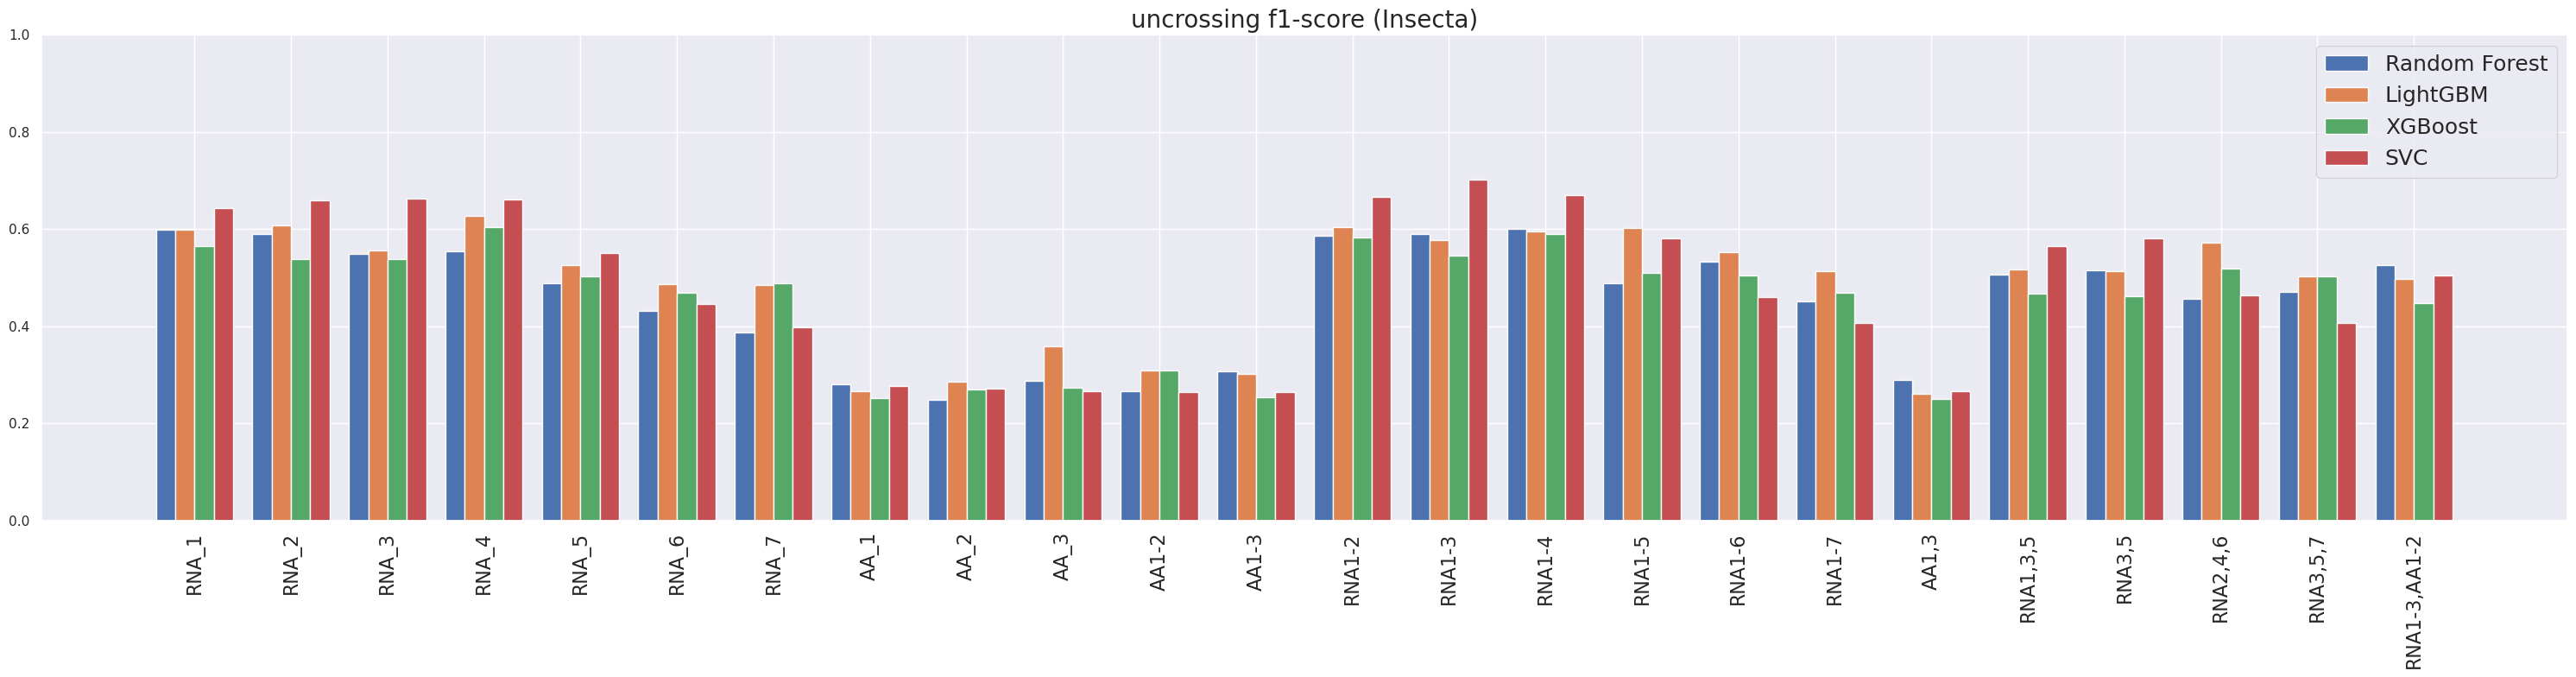

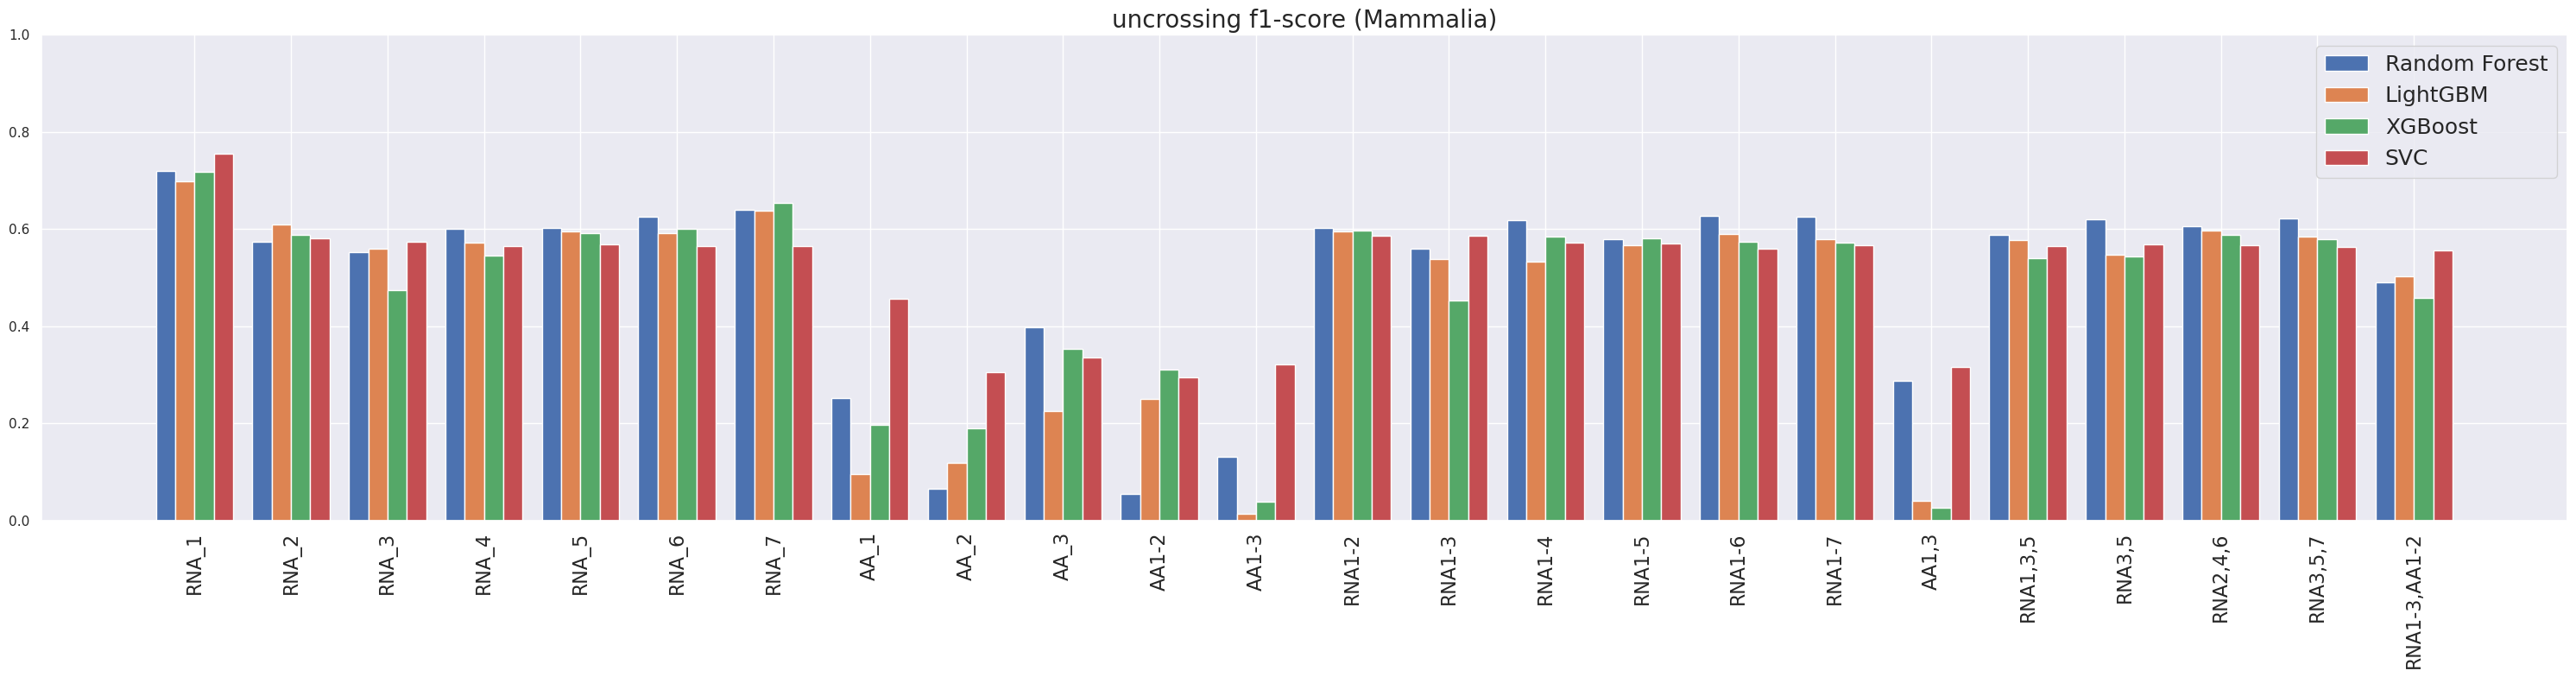

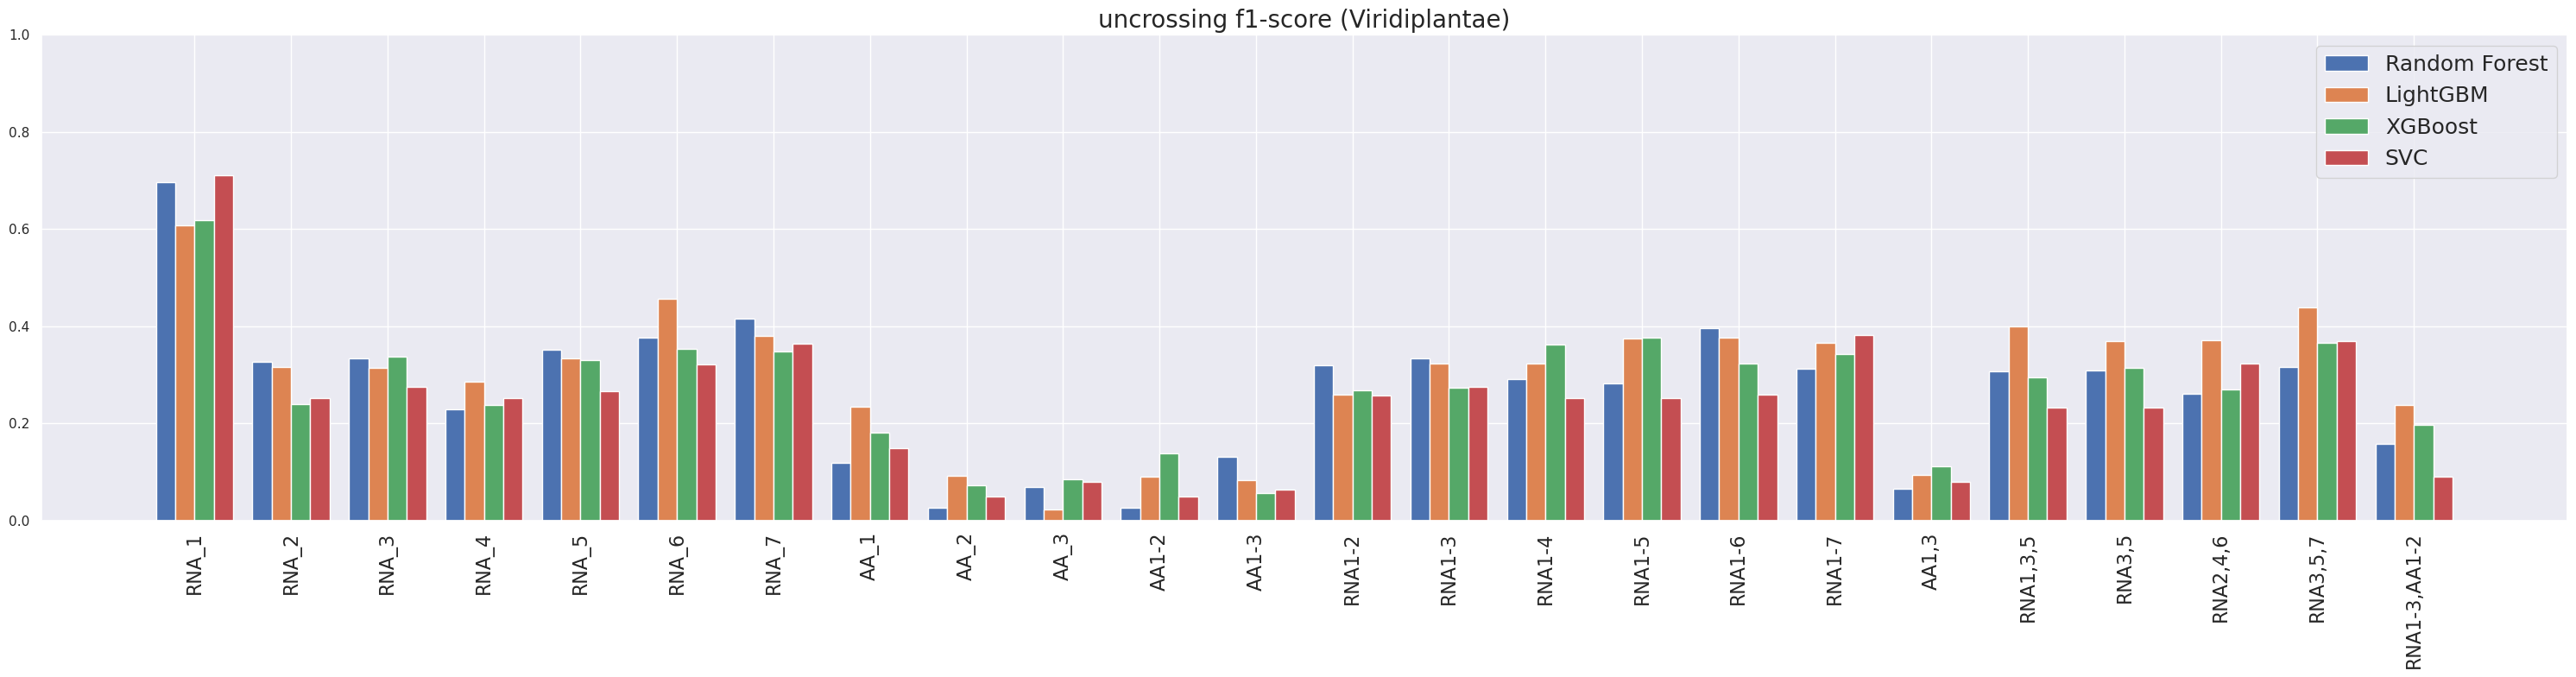

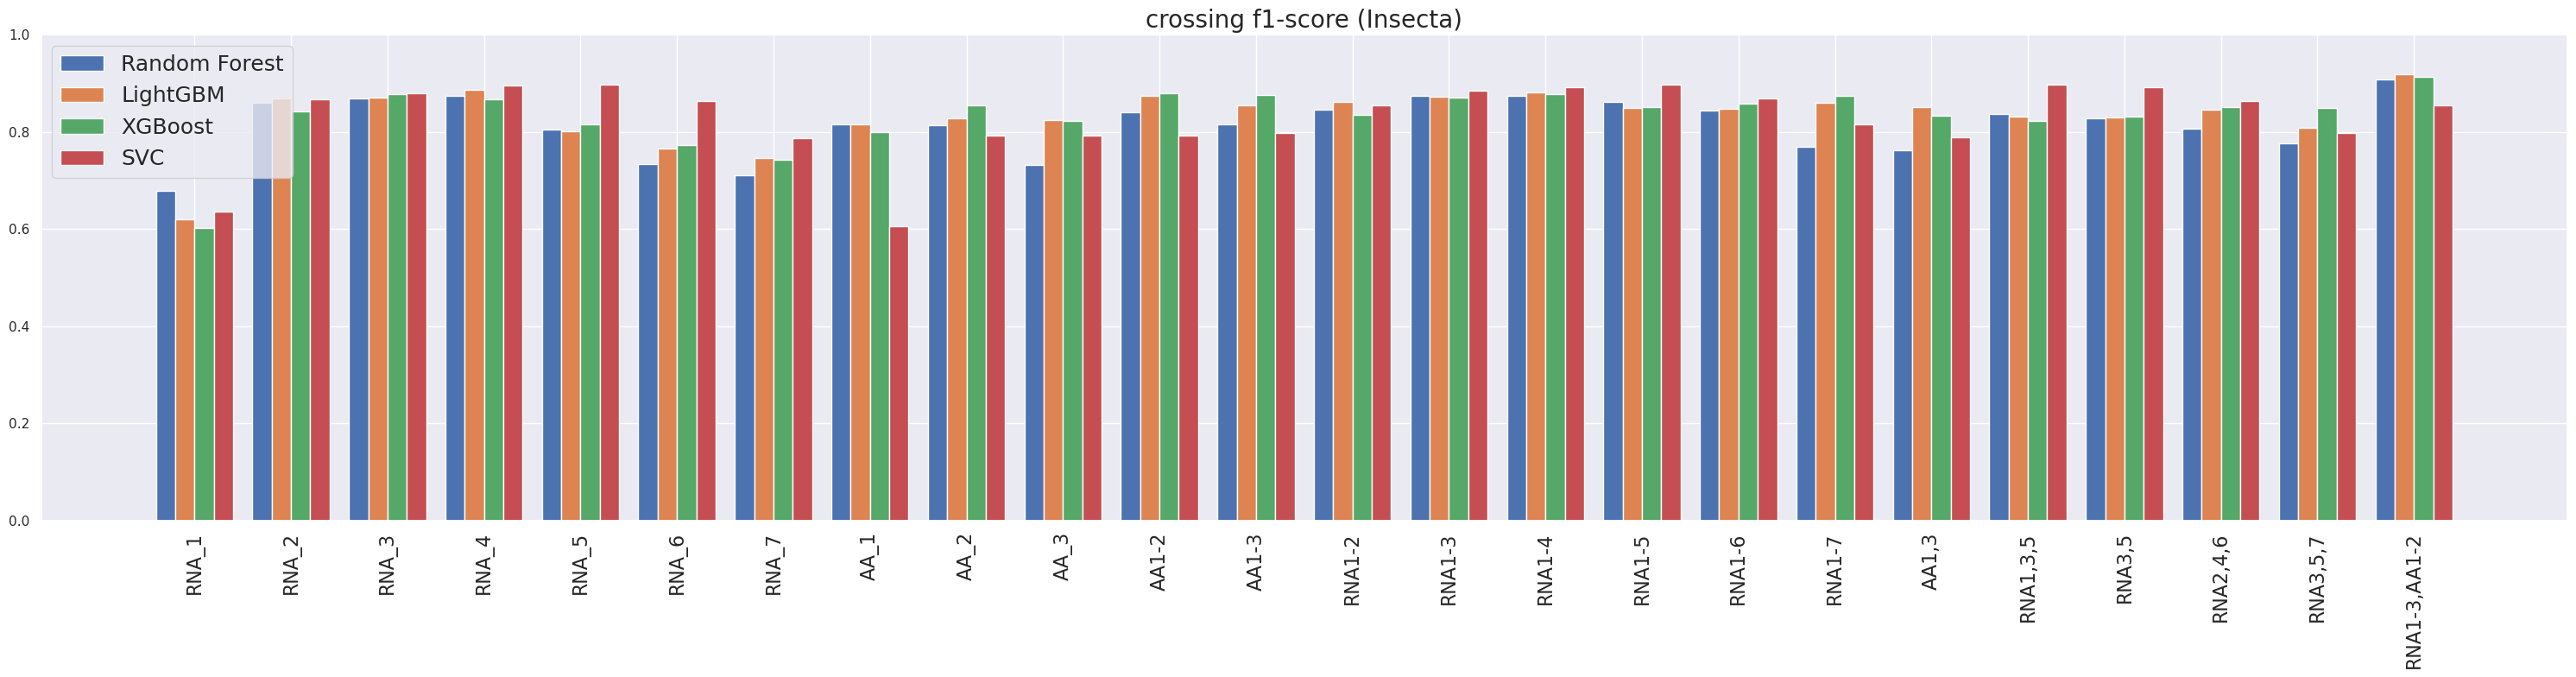

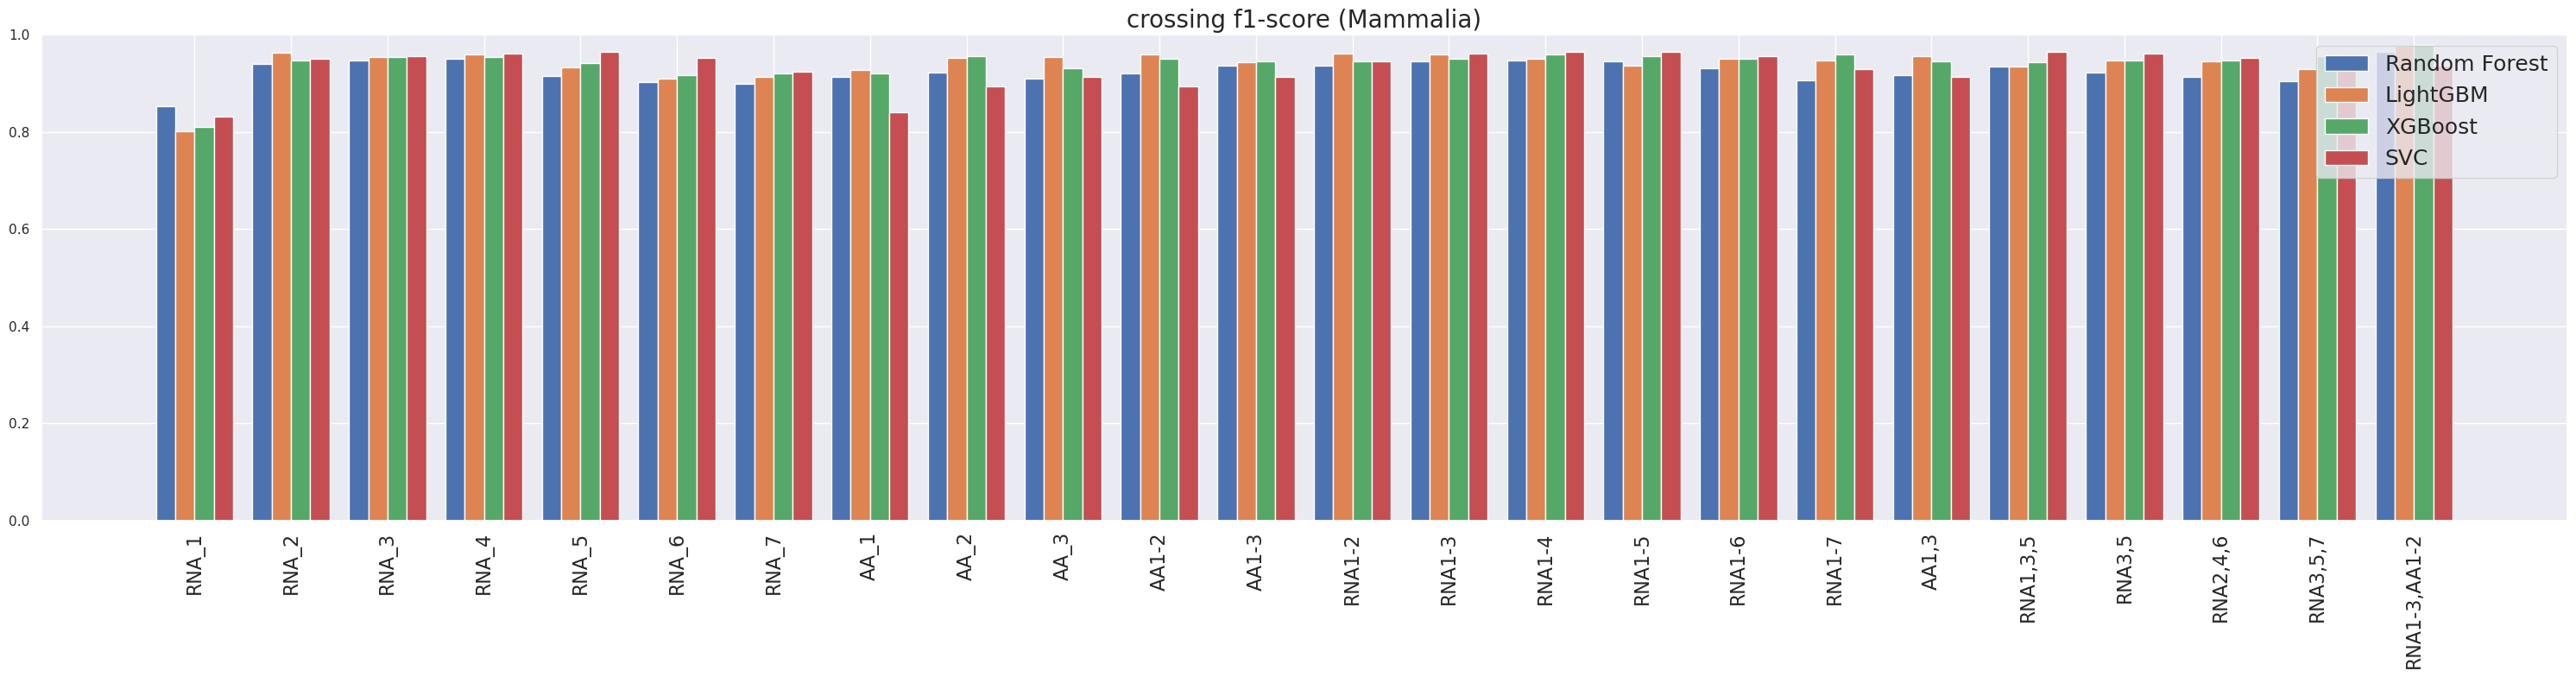

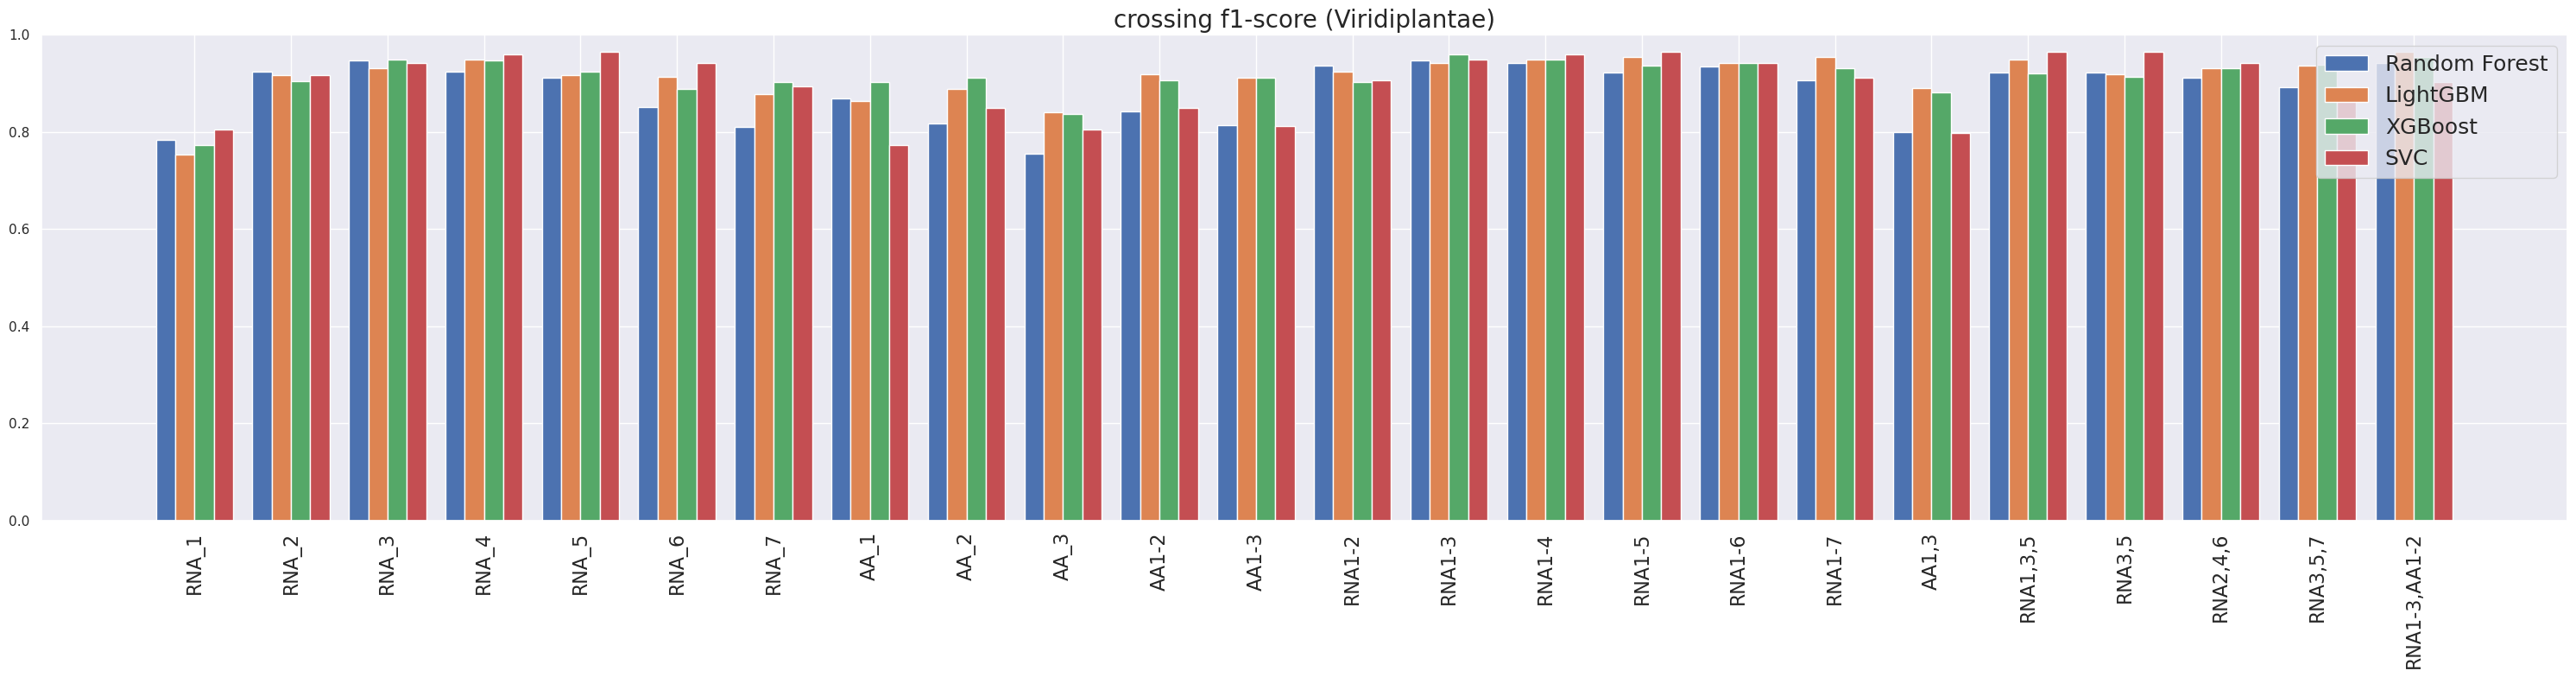

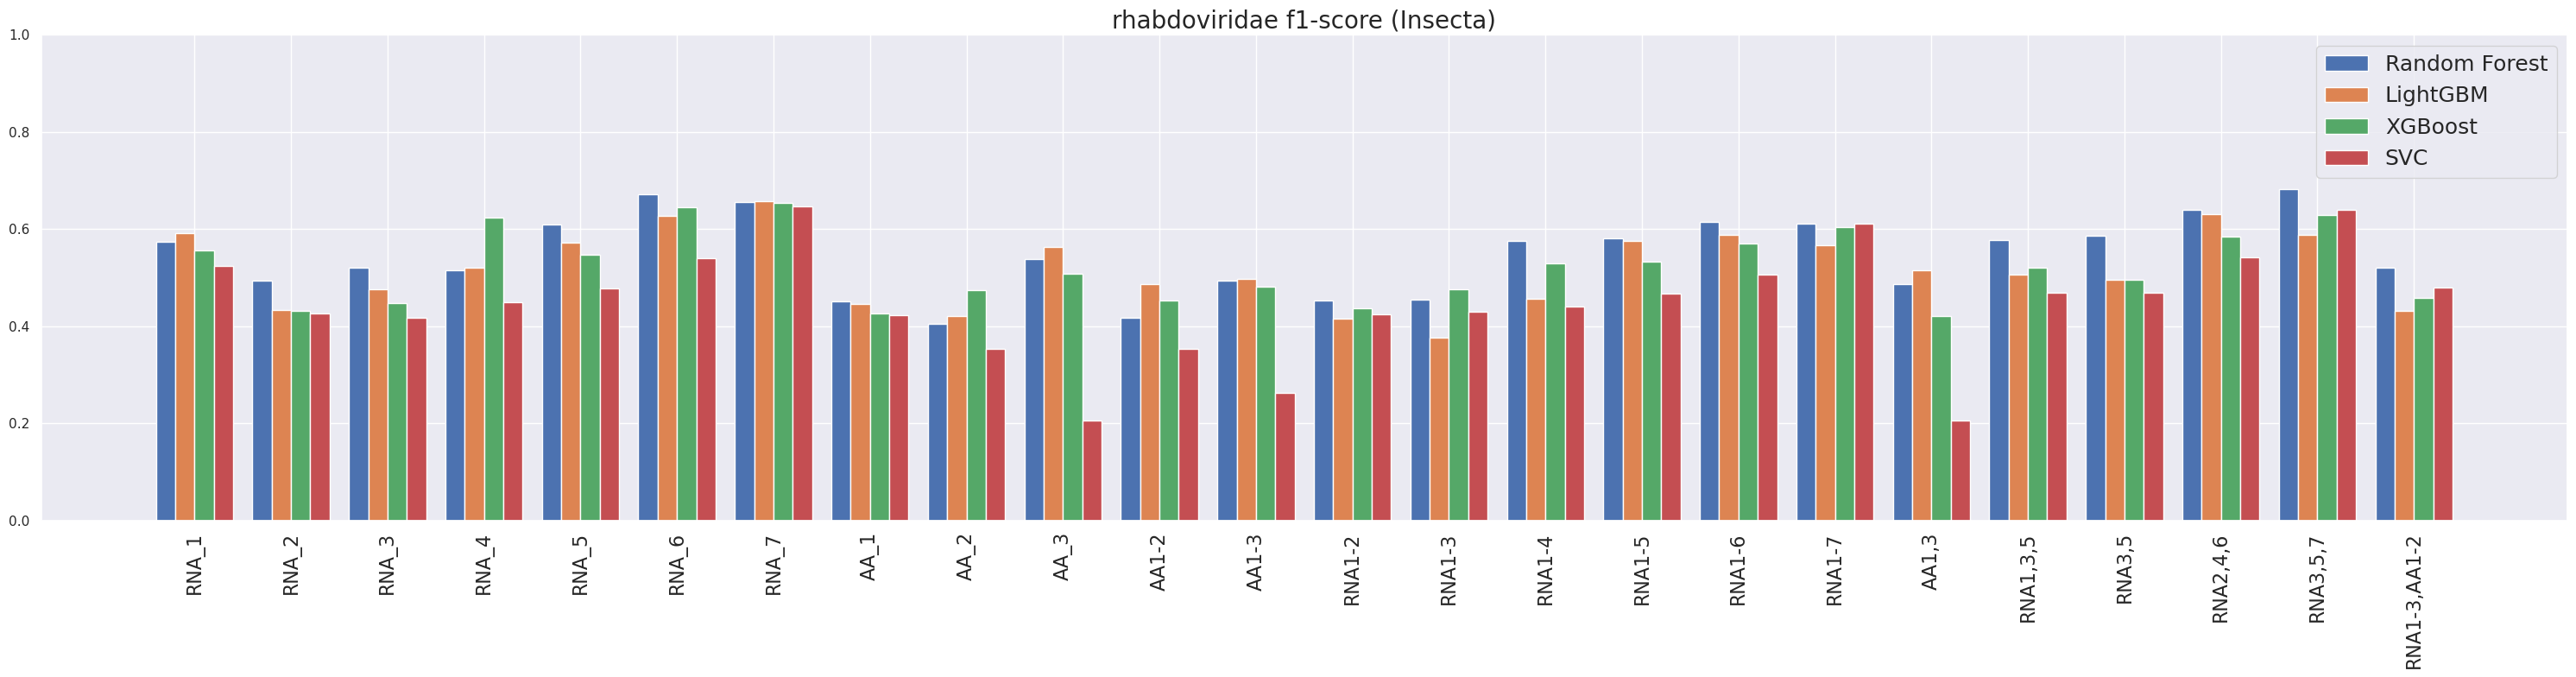

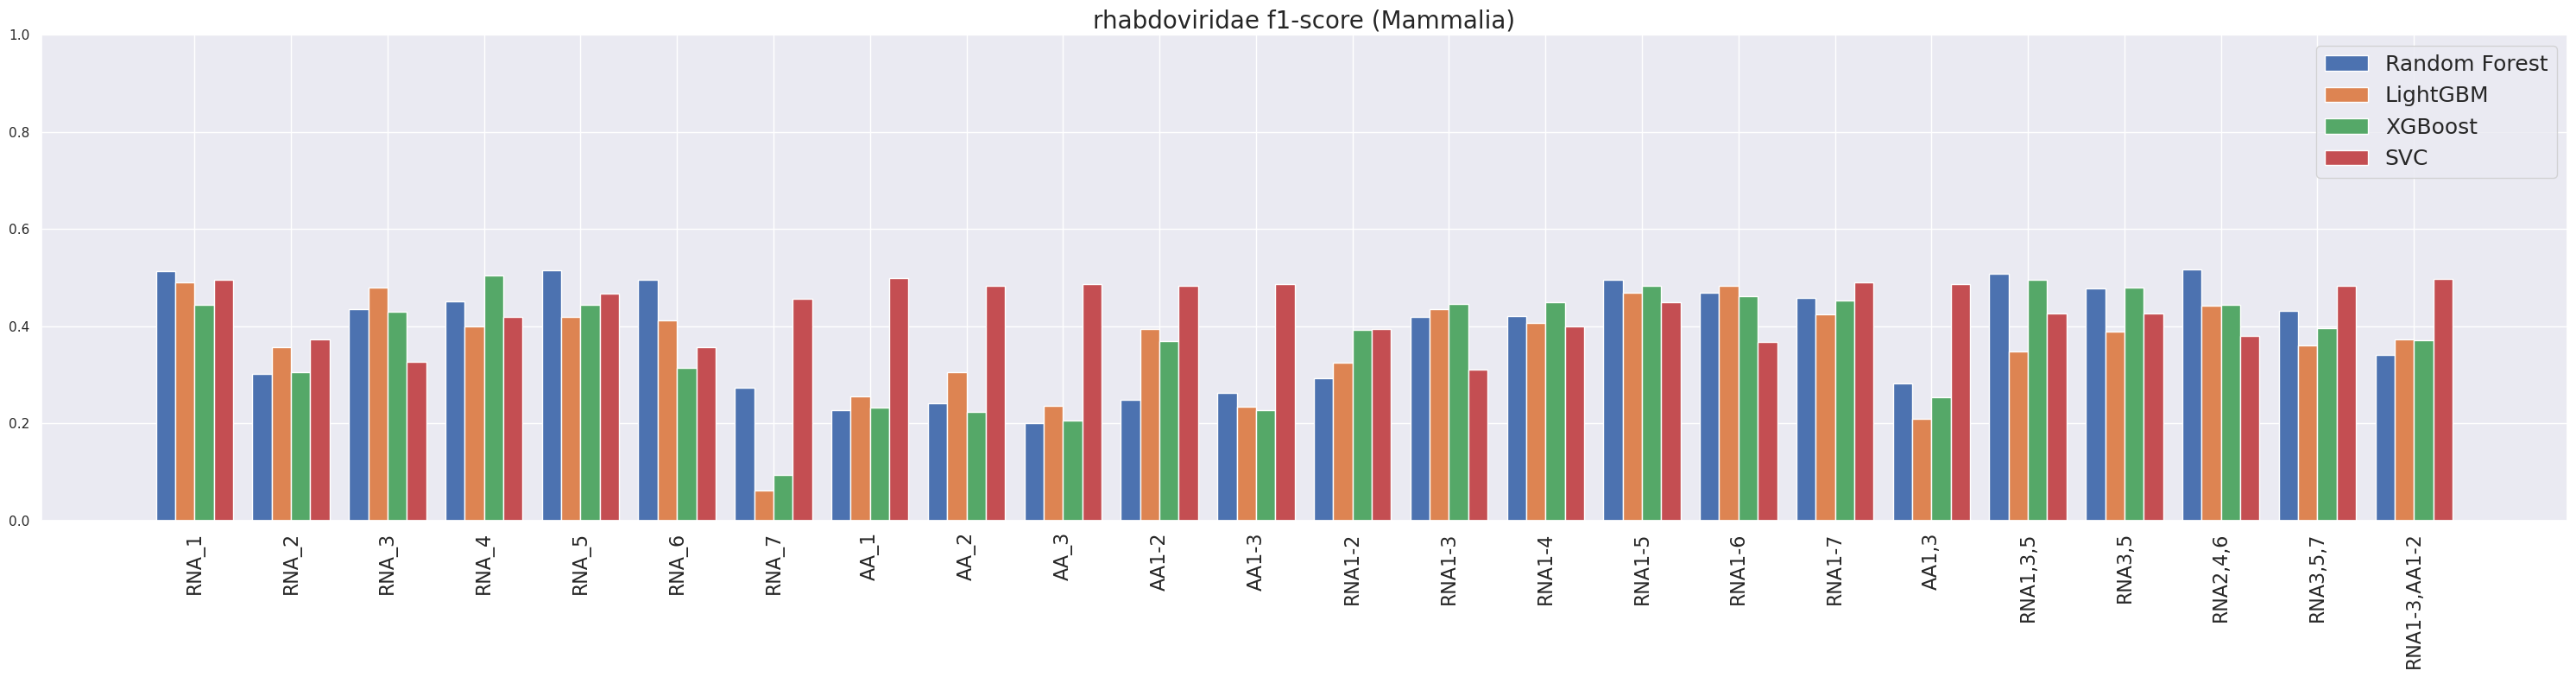

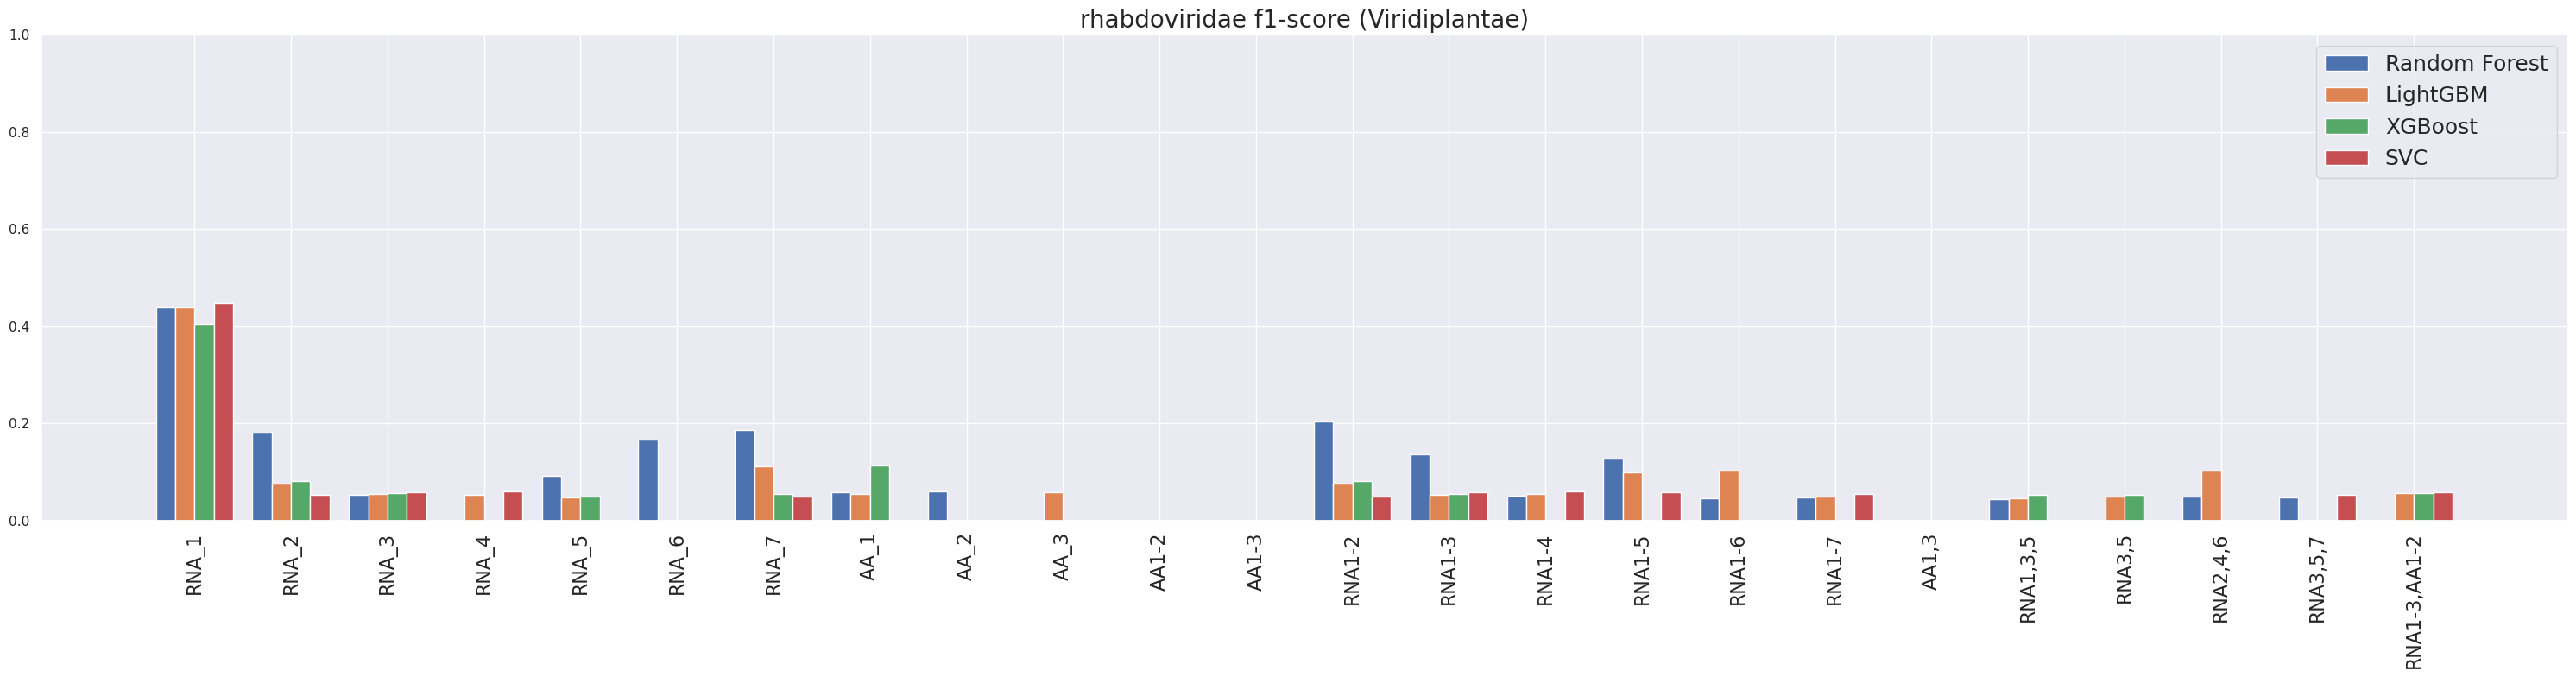

In [4]:
bar_width = 0.2


with open(PATH_REPORTS + 'uncrossing/clfs_4methods_all_uncrossing.pkl', 'rb') as f1, \
    open(PATH_REPORTS + 'uncrossing/clfs_4methods_sole_uncrossing.pkl', 'rb') as f2, \
    open(PATH_REPORTS + 'crossing/it0/clfs_4methods_all_crossing.pkl', 'rb') as f3, \
    open(PATH_REPORTS + 'crossing/it0/clfs_4methods_sole_crossing.pkl', 'rb') as f4, \
    open(PATH_REPORTS + 'rhabdoviridae/clfs_4methods_all_rhab.pkl', 'rb') as f5, \
    open(PATH_REPORTS + 'rhabdoviridae/clfs_4methods_sole_rhab.pkl', 'rb') as f6:

    
    sets_names = ['uncrossing', 'crossing', 'rhabdoviridae']
    f_lst = [f1, f2, f3, f4, f5, f6]
   
    for set_index in range(len(sets_names)):
        
        pair_lst = list()
        pair_lst.append(pickle.load(f_lst[set_index*2]))
        pair_lst.append(pickle.load(f_lst[set_index*2+1]))
        all_accs = {**pair_lst[1], **pair_lst[0]}

        models = ['rf', 'lgbm', 'xgb', 'svc']
        hosts = ['Insecta', 'Mammalia', 'Viridiplantae']

        

        for class_k in hosts:
            
            fig, axis = plt.subplots(figsize=(30, 8))

            rf_values = [x[0][class_k]['f1-score'] for x in all_accs.values()]
            lgbm_values = [x[1][class_k]['f1-score'] for x in all_accs.values()]
            xgb_values = [x[2][class_k]['f1-score'] for x in all_accs.values()]
            svm_values = [x[3][class_k]['f1-score'] for x in all_accs.values()]

            accs = [rf_values, lgbm_values, xgb_values, svm_values]

            axis.bar([x for x in list(range(len(all_accs.keys())))], rf_values, bar_width, align='center', label="Random Forest")
            axis.bar([x+bar_width for x in list(range(len(all_accs.keys())))], lgbm_values, bar_width, align='center', label='LightGBM')
            axis.bar([x+bar_width*2 for x in list(range(len(all_accs.keys())))], xgb_values, bar_width, align='center', label='XGBoost')
            axis.bar([x+bar_width*3 for x in list(range(len(all_accs.keys())))], svm_values, bar_width, align='center', label='SVC')

            axis.set_title(sets_names[set_index]+' f1-score ('+class_k+')', fontsize=20)
            axis.legend(fontsize=18)
            #model = models[i]
            #axis[i].bar(range(len(all_accs.keys())), accs[i], align='center')
            #axis[i].set_title(model+' '+sets_names[set_index]+' accuracy')
            plt.sca(axis)
            plt.xticks([x+bar_width*1.5 for x in list(range(len(all_accs.keys())))], list(all_accs.keys()), fontsize=16, rotation=90)
            plt.ylim(0, 1)

            fig.tight_layout()
            plt.show()

# Ranged data

In [205]:
seq_list = list(SeqIO.parse(PATH_DATA+'data.fasta', 'fasta'))

In [209]:
for rec in seq_list:
    name_l = rec.name.split('_')
    if name_l[0] == 'AC' or name_l[0] == 'NC':
        rec.id = name_l[0] + '_' + name_l[1]
    else:
        rec.id = name_l[0]
seq_dict = SeqIO.to_dict(seq_list)

In [206]:
def get_nonoverlap_fragments(stri, n):
    fragments = [stri[i:i+n] for i in range(0, len(stri), n)]
    if len(fragments[-1]) < 200 and len(fragments)>=2:
        fragments = fragments[:-2] + [fragments[-2]+fragments[-1]]
    lengths = list(len(x) for x in fragments)
    if np.min(lengths) < 200:
        print(stri)
    return fragments

def split2fragment(meta_df, seq_dict, table_name, fasta_name, N):
    output_fasta_lines = []
    seq_fragments = []
    hosts = []
    gb_acs = []
    families = []
    
    count_fasta = 0
    for gb_ac in meta_df.index:
        seq = str(seq_dict[gb_ac].seq)
        fragments_cur = get_nonoverlap_fragments(seq,N)
        host_cur = meta_df.loc[gb_ac]['host']
        fam = meta_df.loc[gb_ac]['virus family']
        for i,fragment in enumerate(fragments_cur):
            seq_fragments.append(fragment)
            hosts.append(host_cur)
            gb_acs.append(gb_ac + '_' + str(i))
            families.append(fam)
            output_fasta_lines.append('>' + gb_ac + '_' + str(i) + '\n')
            output_fasta_lines.append(fragment + '\n')
            count_fasta +=1
    new_df = pd.DataFrame({'gbac': gb_acs, 'host': hosts, 'seq': seq_fragments, 'family': families})
    new_df.to_csv(table_name,index=False)
    print('Seq in fasta:{}, seq in table:{}'.format(count_fasta, len(gb_acs)))
    with open(fasta_name, 'w') as file:
        file.writelines(output_fasta_lines)
    file.close()
    return new_df

In [210]:
df_400 = split2fragment(meta_df, seq_dict, PATH_DATA+'data_table_400.tsv', PATH_DATA+'data_400.fasta', 400)

Seq in fasta:37504, seq in table:37504


In [211]:
df_250 = split2fragment(meta_df, seq_dict, PATH_DATA+'data_table_250.tsv', PATH_DATA+'data_250.fasta', 250)

Seq in fasta:59502, seq in table:59502


In [212]:
df_800 = split2fragment(meta_df, seq_dict, PATH_DATA+'data_table_800.tsv', PATH_DATA+'data_800.fasta', 800)

Seq in fasta:19090, seq in table:19090


In [7]:
features = ['DNA']
dna_alph = 'acgt'
aa_alph = 'ARNDCEQGHILKMFPSTWYV'
kmer_lists = [[1,2,3,4,5,6], # dna 
             ]  
feature_sets = [f'{f}_{k}' for i,f in enumerate(features) for k in kmer_lists[i] ]

In [8]:
seq_lengths = ['400', '800']

In [9]:
def check_nonamb(seq, alphabet):
    return all(s in alphabet for s in seq)


'''
feature name - str - code for feature (e.g. DNA_1, AA_9)
sequences - list with Seq objects
seq_index - dict - dictionary, seq_index[gb_id] = the number of sequences that correspond to one full genome
'''
def get_kmer_features(feature_name, sequences, seq_index, shift=None):
    type_feature = feature_name.split('_')[0]
    k = int(feature_name.split('_')[1])
    if type_feature == 'DNA' or type_feature == 'ORF':
        alphabet = dna_alph
    if type_feature == 'AA':
        alphabet = aa_alph
    all_kmers =[''.join(c) for c in product(alphabet, repeat=k)]
    
    # names of sequences with ambiguous nts
    #names_amb = []
    
    X = np.zeros((len(seq_index) ,len(all_kmers)))
    #row_names = list(sequences.keys())
    col_names = all_kmers
    
    #  the number of sequences that correspond to one full genome, needed for cds
    gbid_count = np.zeros(len(seq_index))
    
    #feature_dict_temp = {k:0 for k in all_kmers}
    #feature_dict = {seq_name:feature_dict_temp for seq_name in full_seq_names}

    
    for j, record in tqdm(enumerate(sequences)):
        #print(seq_name)
        feature_dict = {a:0 for a in all_kmers}
        
        if shift != None:
            for i in range(0 + shift, len(record.seq)-k+1, k):
                w =  record.seq[i:i+k]
                if check_nonamb(w, alphabet):
                    feature_dict[w] += 1

        else:
            for i in range(len(record.seq)-k+1):
                w =  record.seq[i:i+k]
                if check_nonamb(w, alphabet):
                    feature_dict[w] += 1
                #else:
                #    names_amb.append(seq_name)
        if type_feature == 'DNA':
            ind = seq_index[record.name]
        if type_feature == 'AA' or type_feature == 'ORF':
            ind = seq_index[record.description]
        X[ind] = np.array(list(feature_dict.values()))/len(record.seq)
        gbid_count[ind] +=1
    #names_amb = set(names_amb)
    return X, col_names, gbid_count#, names_amb

In [9]:
def calc_features(feature_sets, seq_length):
    
    path_features = PATH_FEATURES + seq_length + '/'
    df = pd.read_csv(PATH_DATA+'data_table_' + seq_length + '.tsv', sep=',', index_col=0)
    full_seq_names = list(df.index)

    #indices of gbids of full genomes
    seq_index = {}
    for i, seq_name in enumerate(full_seq_names):
        seq_index[seq_name] = i

    seq_fullg = list(SeqIO.parse(PATH_DATA+'data_' + seq_length + '.fasta', 'fasta'))
    for feature in tqdm(feature_sets):
        type_feature = feature.split('_')[0]
        if type_feature == 'DNA':
            X, col_names, gbid_count = get_kmer_features(feature, seq_fullg, seq_index)
        df = pd.DataFrame(data=X, index=full_seq_names, columns=col_names)
        df.to_csv(path_features + feature + '.csv')

In [9]:
for l in seq_lengths:
    calc_features(feature_sets, l)

  0%|                                                     | 0/7 [00:00<?, ?it/s]
0it [00:00, ?it/s]
116it [00:00, 1157.93it/s]
236it [00:00, 1178.42it/s]
357it [00:00, 1189.72it/s]
479it [00:00, 1198.58it/s]
599it [00:00, 1187.52it/s]
718it [00:00, 1186.42it/s]
837it [00:00, 1184.40it/s]
956it [00:00, 1167.61it/s]
1074it [00:00, 1168.89it/s]
1192it [00:01, 1170.77it/s]
1310it [00:01, 1173.43it/s]
1429it [00:01, 1176.78it/s]
1553it [00:01, 1194.23it/s]
1674it [00:01, 1197.11it/s]
1796it [00:01, 1202.65it/s]
1917it [00:01, 1196.69it/s]
2037it [00:01, 1194.16it/s]
2157it [00:01, 1188.34it/s]
2276it [00:01, 1183.62it/s]
2399it [00:02, 1196.44it/s]
2519it [00:02, 1196.44it/s]
2641it [00:02, 1202.01it/s]
2763it [00:02, 1204.95it/s]
2884it [00:02, 1204.03it/s]
3005it [00:02, 1203.15it/s]
3126it [00:02, 1204.57it/s]
3247it [00:02, 1204.44it/s]
3368it [00:02, 1204.82it/s]
3491it [00:02, 1210.08it/s]
3613it [00:03, 1202.08it/s]
3734it [00:03, 1185.17it/s]
3853it [00:03, 1174.21it/s]
3974it [00:0

23777it [00:20, 1142.31it/s]
23894it [00:20, 1149.36it/s]
24012it [00:20, 1156.65it/s]
24128it [00:21, 1140.64it/s]
24243it [00:21, 1139.53it/s]
24357it [00:21, 1135.81it/s]
24471it [00:21, 1134.09it/s]
24585it [00:21, 1132.07it/s]
24700it [00:21, 1134.73it/s]
24815it [00:21, 1136.39it/s]
24931it [00:21, 1141.53it/s]
25049it [00:21, 1152.23it/s]
25167it [00:21, 1157.76it/s]
25283it [00:22, 1153.41it/s]
25399it [00:22, 1146.31it/s]
25514it [00:22, 1144.19it/s]
25629it [00:22, 1144.35it/s]
25744it [00:22, 1139.00it/s]
25860it [00:22, 1143.22it/s]
25977it [00:22, 1150.43it/s]
26093it [00:22, 1144.95it/s]
26208it [00:22, 1144.21it/s]
26323it [00:22, 1139.80it/s]
26437it [00:23, 1135.05it/s]
26551it [00:23, 1134.64it/s]
26669it [00:23, 1147.05it/s]
26784it [00:23, 1143.92it/s]
26900it [00:23, 1147.27it/s]
27017it [00:23, 1153.16it/s]
27134it [00:23, 1155.34it/s]
27251it [00:23, 1158.24it/s]
27368it [00:23, 1159.92it/s]
27486it [00:23, 1164.45it/s]
27603it [00:24, 1149.06it/s]
27718it [00:24

5816it [00:05, 1049.31it/s]
5922it [00:05, 1051.45it/s]
6029it [00:05, 1056.12it/s]
6136it [00:05, 1058.06it/s]
6242it [00:05, 1058.44it/s]
6348it [00:06, 1057.83it/s]
6454it [00:06, 1055.52it/s]
6560it [00:06, 1056.62it/s]
6666it [00:06, 1054.62it/s]
6772it [00:06, 1055.07it/s]
6878it [00:06, 1055.34it/s]
6984it [00:06, 1053.08it/s]
7090it [00:06, 1053.98it/s]
7196it [00:06, 1049.11it/s]
7301it [00:06, 1048.96it/s]
7406it [00:07, 1045.69it/s]
7511it [00:07, 1040.91it/s]
7616it [00:07, 1037.81it/s]
7721it [00:07, 1039.42it/s]
7826it [00:07, 1040.92it/s]
7931it [00:07, 1040.14it/s]
8036it [00:07, 1031.88it/s]
8141it [00:07, 1037.24it/s]
8248it [00:07, 1046.15it/s]
8355it [00:07, 1051.20it/s]
8462it [00:08, 1056.31it/s]
8570it [00:08, 1062.22it/s]
8679it [00:08, 1067.84it/s]
8786it [00:08, 1067.94it/s]
8893it [00:08, 1058.01it/s]
8999it [00:08, 1057.88it/s]
9105it [00:08, 1056.88it/s]
9212it [00:08, 1059.92it/s]
9319it [00:08, 1059.86it/s]
9425it [00:08, 1055.19it/s]
9531it [00:09, 1048.

21412it [00:22, 966.24it/s]
21509it [00:22, 962.91it/s]
21606it [00:22, 958.65it/s]
21702it [00:22, 958.58it/s]
21798it [00:22, 949.04it/s]
21896it [00:22, 956.34it/s]
21992it [00:22, 955.99it/s]
22088it [00:23, 954.13it/s]
22185it [00:23, 957.93it/s]
22282it [00:23, 959.11it/s]
22379it [00:23, 961.61it/s]
22476it [00:23, 957.55it/s]
22573it [00:23, 959.51it/s]
22669it [00:23, 958.05it/s]
22765it [00:23, 952.72it/s]
22861it [00:23, 954.23it/s]
22957it [00:23, 953.71it/s]
23053it [00:24, 953.07it/s]
23150it [00:24, 955.95it/s]
23246it [00:24, 955.17it/s]
23343it [00:24, 958.15it/s]
23441it [00:24, 962.59it/s]
23538it [00:24, 961.76it/s]
23636it [00:24, 965.08it/s]
23733it [00:24, 963.89it/s]
23831it [00:24, 966.33it/s]
23928it [00:24, 962.34it/s]
24025it [00:25, 962.48it/s]
24122it [00:25, 960.65it/s]
24220it [00:25, 963.83it/s]
24318it [00:25, 966.55it/s]
24415it [00:25, 966.67it/s]
24512it [00:25, 962.61it/s]
24609it [00:25, 963.35it/s]
24706it [00:25, 960.22it/s]
24804it [00:25, 963.

26540it [00:36, 720.10it/s]
26614it [00:36, 723.64it/s]
26687it [00:36, 722.11it/s]
26760it [00:36, 720.61it/s]
26833it [00:37, 721.64it/s]
26906it [00:37, 722.28it/s]
26980it [00:37, 725.91it/s]
27053it [00:37, 724.59it/s]
27126it [00:37, 720.63it/s]
27199it [00:37, 720.35it/s]
27272it [00:37, 720.65it/s]
27346it [00:37, 725.07it/s]
27419it [00:37, 721.49it/s]
27492it [00:37, 719.43it/s]
27565it [00:38, 721.31it/s]
27638it [00:38, 721.73it/s]
27711it [00:38, 723.14it/s]
27784it [00:38, 723.78it/s]
27857it [00:38, 720.04it/s]
27930it [00:38, 720.98it/s]
28004it [00:38, 724.03it/s]
28077it [00:38, 725.04it/s]
28150it [00:38, 725.32it/s]
28223it [00:39, 723.48it/s]
28297it [00:39, 726.37it/s]
28370it [00:39, 723.83it/s]
28443it [00:39, 724.34it/s]
28516it [00:39, 722.79it/s]
28589it [00:39, 721.46it/s]
28662it [00:39, 721.59it/s]
28736it [00:39, 726.38it/s]
28810it [00:39, 728.43it/s]
28883it [00:39, 724.88it/s]
28956it [00:40, 723.78it/s]
29029it [00:40, 724.10it/s]
29102it [00:40, 723.

14770it [00:39, 377.19it/s]
14809it [00:39, 378.97it/s]
14848it [00:39, 380.16it/s]
14887it [00:39, 381.76it/s]
14926it [00:39, 381.02it/s]
14965it [00:39, 380.01it/s]
15004it [00:39, 380.64it/s]
15043it [00:39, 380.73it/s]
15082it [00:39, 380.98it/s]
15121it [00:39, 378.16it/s]
15159it [00:40, 376.46it/s]
15197it [00:40, 376.87it/s]
15236it [00:40, 378.08it/s]
15275it [00:40, 379.04it/s]
15313it [00:40, 378.91it/s]
15352it [00:40, 380.22it/s]
15391it [00:40, 380.16it/s]
15430it [00:40, 379.93it/s]
15468it [00:40, 379.86it/s]
15506it [00:40, 377.41it/s]
15544it [00:41, 377.32it/s]
15582it [00:41, 376.98it/s]
15620it [00:41, 377.13it/s]
15659it [00:41, 378.27it/s]
15697it [00:41, 378.21it/s]
15735it [00:41, 378.43it/s]
15774it [00:41, 379.20it/s]
15812it [00:41, 378.02it/s]
15850it [00:41, 377.00it/s]
15889it [00:41, 378.30it/s]
15927it [00:42, 378.53it/s]
15965it [00:42, 378.71it/s]
16004it [00:42, 379.75it/s]
16043it [00:42, 381.28it/s]
16082it [00:42, 382.81it/s]
16121it [00:42, 383.

34989it [01:32, 377.25it/s]
35027it [01:32, 375.54it/s]
35065it [01:32, 376.64it/s]
35104it [01:33, 378.72it/s]
35142it [01:33, 376.71it/s]
35180it [01:33, 373.33it/s]
35218it [01:33, 374.65it/s]
35257it [01:33, 376.50it/s]
35295it [01:33, 376.74it/s]
35333it [01:33, 377.42it/s]
35371it [01:33, 377.39it/s]
35410it [01:33, 378.82it/s]
35448it [01:33, 378.63it/s]
35486it [01:34, 377.64it/s]
35524it [01:34, 376.86it/s]
35562it [01:34, 372.24it/s]
35600it [01:34, 373.04it/s]
35638it [01:34, 373.07it/s]
35676it [01:34, 372.61it/s]
35714it [01:34, 373.08it/s]
35752it [01:34, 374.98it/s]
35790it [01:34, 375.17it/s]
35828it [01:34, 374.11it/s]
35866it [01:35, 375.50it/s]
35904it [01:35, 375.70it/s]
35942it [01:35, 368.22it/s]
35980it [01:35, 369.88it/s]
36018it [01:35, 371.95it/s]
36056it [01:35, 373.02it/s]
36094it [01:35, 372.35it/s]
36132it [01:35, 372.64it/s]
36170it [01:35, 373.22it/s]
36208it [01:36, 373.81it/s]
36246it [01:36, 373.92it/s]
36284it [01:36, 368.90it/s]
36322it [01:36, 370.

12511it [00:20, 609.92it/s]
12573it [00:20, 607.68it/s]
12634it [00:20, 605.62it/s]
12697it [00:20, 610.55it/s]
12760it [00:20, 613.78it/s]
12823it [00:20, 616.86it/s]
12886it [00:20, 618.65it/s]
12948it [00:20, 614.39it/s]
13010it [00:21, 614.92it/s]
13072it [00:21, 610.65it/s]
13134it [00:21, 612.25it/s]
13196it [00:21, 614.12it/s]
13258it [00:21, 615.75it/s]
13322it [00:21, 621.37it/s]
13385it [00:21, 620.70it/s]
13448it [00:21, 619.32it/s]
13510it [00:21, 619.10it/s]
13572it [00:21, 619.30it/s]
13637it [00:22, 626.41it/s]
13700it [00:22, 624.29it/s]
13763it [00:22, 625.62it/s]
13827it [00:22, 628.27it/s]
13890it [00:22, 628.28it/s]
13953it [00:22, 622.16it/s]
14016it [00:22, 614.46it/s]
14078it [00:22, 613.06it/s]
14141it [00:22, 617.38it/s]
14203it [00:22, 617.14it/s]
14266it [00:23, 620.38it/s]
14329it [00:23, 617.07it/s]
14391it [00:23, 617.79it/s]
14454it [00:23, 620.21it/s]
14517it [00:23, 619.60it/s]
14580it [00:23, 621.09it/s]
14644it [00:23, 626.01it/s]
14707it [00:23, 624.

6348it [00:11, 571.12it/s]
6406it [00:11, 566.96it/s]
6465it [00:11, 571.18it/s]
6525it [00:11, 577.32it/s]
6586it [00:11, 584.39it/s]
6645it [00:11, 580.68it/s]
6704it [00:11, 578.23it/s]
6762it [00:11, 573.12it/s]
6820it [00:11, 573.60it/s]
6878it [00:12, 572.18it/s]
6937it [00:12, 574.91it/s]
6996it [00:12, 578.76it/s]
7055it [00:12, 579.90it/s]
7113it [00:12, 576.54it/s]
7171it [00:12, 576.33it/s]
7229it [00:12, 575.42it/s]
7287it [00:12, 572.53it/s]
7345it [00:12, 574.54it/s]
7403it [00:12, 575.64it/s]
7461it [00:13, 575.52it/s]
7519it [00:13, 575.85it/s]
7577it [00:13, 573.37it/s]
7635it [00:13, 567.57it/s]
7694it [00:13, 571.91it/s]
7752it [00:13, 569.51it/s]
7809it [00:13, 568.82it/s]
7866it [00:13, 563.22it/s]
7923it [00:13, 564.26it/s]
7982it [00:13, 570.30it/s]
8040it [00:14, 570.29it/s]
8099it [00:14, 574.48it/s]
8157it [00:14, 572.46it/s]
8215it [00:14, 571.54it/s]
8273it [00:14, 571.60it/s]
8331it [00:14, 570.41it/s]
8390it [00:14, 574.22it/s]
8448it [00:14, 570.41it/s]
8

17502it [00:32, 556.10it/s]
17558it [00:32, 552.12it/s]
17614it [00:32, 553.76it/s]
17671it [00:32, 555.99it/s]
17727it [00:32, 548.99it/s]
17782it [00:32, 547.41it/s]
17838it [00:32, 550.80it/s]
17894it [00:32, 552.74it/s]
17950it [00:32, 553.61it/s]
18006it [00:32, 549.89it/s]
18062it [00:33, 548.56it/s]
18118it [00:33, 550.34it/s]
18174it [00:33, 551.20it/s]
18230it [00:33, 552.61it/s]
18287it [00:33, 555.63it/s]
18343it [00:33, 553.75it/s]
18399it [00:33, 546.59it/s]
18454it [00:33, 545.93it/s]
18511it [00:33, 552.70it/s]
18567it [00:34, 546.42it/s]
18624it [00:34, 552.64it/s]
18680it [00:34, 554.71it/s]
18739it [00:34, 562.84it/s]
18796it [00:34, 557.50it/s]
18852it [00:34, 557.86it/s]
18910it [00:34, 564.40it/s]
18968it [00:34, 566.94it/s]
19026it [00:34, 568.12it/s]
19090it [00:34, 546.57it/s]
 57%|█████████████████████████▋                   | 4/7 [02:14<01:43, 34.34s/it]
0it [00:00, ?it/s]
51it [00:00, 502.50it/s]
102it [00:00, 502.76it/s]
156it [00:00, 516.60it/s]
208it [00:0

6143it [00:14, 432.79it/s]
6187it [00:14, 432.45it/s]
6231it [00:14, 430.36it/s]
6275it [00:14, 428.96it/s]
6318it [00:14, 425.88it/s]
6362it [00:14, 429.90it/s]
6405it [00:14, 429.23it/s]
6448it [00:14, 426.24it/s]
6492it [00:14, 429.69it/s]
6536it [00:15, 430.10it/s]
6581it [00:15, 433.54it/s]
6626it [00:15, 435.58it/s]
6670it [00:15, 435.29it/s]
6714it [00:15, 435.91it/s]
6758it [00:15, 434.81it/s]
6802it [00:15, 432.18it/s]
6846it [00:15, 433.15it/s]
6890it [00:15, 430.26it/s]
6934it [00:16, 432.08it/s]
6978it [00:16, 431.67it/s]
7022it [00:16, 430.07it/s]
7066it [00:16, 430.95it/s]
7110it [00:16, 427.96it/s]
7155it [00:16, 433.57it/s]
7199it [00:16, 434.49it/s]
7244it [00:16, 436.23it/s]
7288it [00:16, 435.97it/s]
7332it [00:16, 435.98it/s]
7376it [00:17, 436.61it/s]
7420it [00:17, 435.86it/s]
7464it [00:17, 433.07it/s]
7508it [00:17, 429.05it/s]
7551it [00:17, 427.52it/s]
7595it [00:17, 428.79it/s]
7638it [00:17, 428.37it/s]
7682it [00:17, 430.23it/s]
7726it [00:17, 425.89it/s]
7

6913it [00:24, 278.82it/s]
6941it [00:25, 277.76it/s]
6969it [00:25, 277.44it/s]
6998it [00:25, 278.28it/s]
7026it [00:25, 277.36it/s]
7055it [00:25, 278.60it/s]
7083it [00:25, 276.14it/s]
7111it [00:25, 276.14it/s]
7140it [00:25, 277.51it/s]
7169it [00:25, 278.67it/s]
7197it [00:25, 277.47it/s]
7225it [00:26, 277.02it/s]
7254it [00:26, 279.20it/s]
7282it [00:26, 279.35it/s]
7310it [00:26, 276.34it/s]
7339it [00:26, 279.71it/s]
7367it [00:26, 278.64it/s]
7395it [00:26, 278.18it/s]
7424it [00:26, 279.81it/s]
7452it [00:26, 279.81it/s]
7480it [00:26, 279.49it/s]
7508it [00:27, 278.07it/s]
7536it [00:27, 277.02it/s]
7564it [00:27, 277.18it/s]
7592it [00:27, 277.30it/s]
7620it [00:27, 276.15it/s]
7648it [00:27, 273.20it/s]
7677it [00:27, 275.34it/s]
7705it [00:27, 275.33it/s]
7733it [00:27, 276.08it/s]
7761it [00:27, 276.50it/s]
7789it [00:28, 275.35it/s]
7817it [00:28, 275.19it/s]
7845it [00:28, 274.14it/s]
7873it [00:28, 274.99it/s]
7901it [00:28, 273.38it/s]
7929it [00:28, 272.82it/s]
7

In [81]:
ranged_df = pd.read_csv(PATH_DATA+'data_table_250.tsv', sep=',', index_col = 0)
ranged_meta_df = meta_df.loc[[''.join([x+'_' for x in k.split('_')[:-1]])[:-1] for k in list(ranged_df.index)]]

ranged_df = ranged_meta_df.reset_index()
ranged_meta_df = ranged_meta_df.reset_index()

In [11]:
def get_X_y(df_table, df_feature, gbac, y_class, data_type):
    
    if data_type == 'ranged':
        
        df_feature['refseq id'] = [''.join([x+'_' for x in k.split('_')[:-1]])[:-1] for k in list(df_feature.index)]
        df_feature = df_feature.reset_index(drop = True)
        df_table = df_table.loc[df_feature['refseq id']]
        df_table = df_table.reset_index(drop = True)
        
        
        test_sample = pd.DataFrame()
        for seq_id in gbac:
            tmp = df_feature[df_feature['refseq id'] == seq_id]
            test_sample = pd.concat([test_sample, tmp])
        
        y_test = list(df_table.loc[test_sample.index][y_class])
        train_sample = df_feature[~df_feature.isin(test_sample)].dropna()
        y_train = list(df_table.loc[train_sample.index][y_class])
        
        
        indices_test = test_sample.index.to_numpy()
        #indices_train = df_feature.loc[train_sample.index].to_numpy()
        indices_train = train_sample.index.to_numpy()
        
        y_test = np.array(y_test)
        y_train = np.array(y_train)
        X_test = test_sample.iloc[:, :-1].to_numpy()
        X_train = train_sample.iloc[:, :-1].to_numpy()
        
        print('X_test size:', len(X_test), 'X_train size:', len(X_train), 'y_test size:', len(y_test), 'y_train size:', len(y_train))
        return(X_test, X_train, y_test, y_train, indices_test, indices_train)  
    
    if data_type == 'full':
        df_feature['indices'] = range(len(df_feature))

        test_sample = df_feature.loc[gbac]
        y_test = list(df_table.loc[gbac][y_class])
        train_sample = df_feature[~df_feature.isin(test_sample)].dropna()
        y_train = list(df_table.loc[list(train_sample.index)][y_class])

        indices_test = test_sample['indices'].to_numpy()
        indices_train = df_feature.loc[train_sample.index]['indices'].to_numpy()

        y_test = np.array(y_test)
        y_train = np.array(y_train)
        X_test = test_sample.iloc[:, :-1].to_numpy()
        X_train = train_sample.iloc[:, :-1].to_numpy()

        print('X_test size:', len(X_test), 'X_train size:', len(X_train), 'y_test size:', len(y_test), 'y_train size:', len(y_train))
        return(X_test, X_train, y_test, y_train, indices_test, indices_train)  

In [83]:
X_test, X_train, y_test, y_train, indices_test, indices_train = get_X_y(meta_df, pd.read_csv(PATH_FEATURES+'250/'+sole_sets[0][0]+'.csv', index_col=0), future_sample_id_uncrossing, 'host', 'ranged')

X_test size: 12809 X_train size: 46693 y_test size: 12809 y_train size: 46693


In [11]:
meta_df_250=pd.read_csv(PATH_DATA+'data_table_250.tsv', sep=',', index_col = 0)
y = np.array(meta_df_250['host'])

pre = preprocessing.LabelEncoder()
pre.fit(['Insecta', 'Mammalia', 'Viridiplantae'])  
y_int = pre.transform(y)
#family = np.array(meta_df_250['virus family'])

y_insects = np.array(y_int == 0).astype(int)
y_mammals = np.array(y_int == 1).astype(int)
y_plants = np.array(y_int == 2).astype(int) 


list_y = [y_insects, y_mammals, y_plants]
classes = ['Insecta', 'Mammalia', 'Viridiplantae']

In [12]:
all_clfs = {}
svc_classes_clfs = {}
models = ['rf', 'lgbm', 'xgb', 'svc']

for fset in sole_sets:
    
    print(fset, 'Collecting data...')
    X_test, X_train, y_test, y_train, indices_test, indices_train = get_X_y(meta_df, pd.read_csv(PATH_FEATURES+'250/'+fset[0]+'.csv', index_col=0), future_sample_id_uncrossing, 'host', 'ranged')

    print('Data obtained. Calculating models')
    out = calc_models(models, X_train, y_train, X_test, y_test, meta_df, indices_test, indices_train)
    all_clfs[sole_feature_names[sole_sets.index(fset)]], svc_classes_clfs[sole_feature_names[sole_sets.index(fset)]] = out[0], out[1]

pickle.dump(all_clfs, open(PATH_RANGED_REPORTS + 'clfs_4methods_250_sole_uncrossing.pkl', 'wb'))
pickle.dump(svc_classes_clfs, open(PATH_RANGED_REPORTS + 'clfs_svc_classes_250_sole_uncrossing.pkl', 'wb'))

['DNA_1'] Collecting data...
X_test size: 12809 X_train size: 46693 y_test size: 12809 y_train size: 46693
Data obtained. Calculating models
rf                precision    recall  f1-score   support

      Insecta       0.22      0.21      0.21      3050
     Mammalia       0.47      0.50      0.48      6605
Viridiplantae       0.26      0.24      0.25      3154

     accuracy                           0.36     12809
    macro avg       0.32      0.31      0.31     12809
 weighted avg       0.36      0.36      0.36     12809

lgbm                precision    recall  f1-score   support

      Insecta       0.23      0.15      0.18      3050
     Mammalia       0.46      0.56      0.51      6605
Viridiplantae       0.27      0.23      0.25      3154

     accuracy                           0.38     12809
    macro avg       0.32      0.32      0.31     12809
 weighted avg       0.36      0.38      0.37     12809



/home/parazit/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


xgb                precision    recall  f1-score   support

      Insecta       0.23      0.15      0.18      3050
     Mammalia       0.46      0.55      0.50      6605
Viridiplantae       0.27      0.24      0.26      3154

     accuracy                           0.38     12809
    macro avg       0.32      0.32      0.31     12809
 weighted avg       0.36      0.38      0.36     12809



1it [05:06, 306.20s/it]

Insecta
              precision    recall  f1-score   support

      Others       0.76      0.91      0.83      9759
     Insecta       0.24      0.09      0.14      3050

    accuracy                           0.71     12809
   macro avg       0.50      0.50      0.48     12809
weighted avg       0.64      0.71      0.66     12809



2it [10:25, 313.84s/it]

Mammalia
              precision    recall  f1-score   support

      Others       0.40      0.43      0.41      6204
    Mammalia       0.42      0.38      0.40      6605

    accuracy                           0.41     12809
   macro avg       0.41      0.41      0.41     12809
weighted avg       0.41      0.41      0.41     12809



3it [14:55, 298.62s/it]

Viridiplantae
               precision    recall  f1-score   support

       Others       0.76      0.94      0.84      9655
Viridiplantae       0.28      0.07      0.11      3154

     accuracy                           0.73     12809
    macro avg       0.52      0.51      0.47     12809
 weighted avg       0.64      0.73      0.66     12809

F1-score (weighted): 0.37
F1-score (macro): 0.3
['DNA_2'] Collecting data...


X_test size: 12809 X_train size: 46693 y_test size: 12809 y_train size: 46693
Data obtained. Calculating models
rf                precision    recall  f1-score   support

      Insecta       0.25      0.27      0.26      3050
     Mammalia       0.51      0.56      0.53      6605
Viridiplantae       0.32      0.23      0.27      3154

     accuracy                           0.41     12809
    macro avg       0.36      0.35      0.35     12809
 weighted avg       0.40      0.41      0.40     12809

lgbm                precision    recall  f1-score   support

      Insecta       0.27      0.31      0.29      3050
     Mammalia       0.51      0.53      0.52      6605
Viridiplantae       0.33      0.25      0.29      3154

     accuracy                           0.41     12809
    macro avg       0.37      0.37      0.37     12809
 weighted avg       0.41      0.41      0.41     12809



/home/parazit/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


xgb                precision    recall  f1-score   support

      Insecta       0.27      0.31      0.29      3050
     Mammalia       0.51      0.53      0.52      6605
Viridiplantae       0.31      0.25      0.28      3154

     accuracy                           0.41     12809
    macro avg       0.37      0.36      0.36     12809
 weighted avg       0.41      0.41      0.41     12809



1it [04:16, 256.41s/it]

Insecta
              precision    recall  f1-score   support

      Others       0.78      0.85      0.81      9759
     Insecta       0.31      0.21      0.25      3050

    accuracy                           0.70     12809
   macro avg       0.54      0.53      0.53     12809
weighted avg       0.66      0.70      0.68     12809



2it [08:39, 260.62s/it]

Mammalia
              precision    recall  f1-score   support

      Others       0.46      0.55      0.50      6204
    Mammalia       0.49      0.40      0.44      6605

    accuracy                           0.47     12809
   macro avg       0.47      0.48      0.47     12809
weighted avg       0.48      0.47      0.47     12809



3it [12:08, 242.85s/it]

Viridiplantae
               precision    recall  f1-score   support

       Others       0.76      0.92      0.83      9655
Viridiplantae       0.35      0.14      0.20      3154

     accuracy                           0.72     12809
    macro avg       0.56      0.53      0.51     12809
 weighted avg       0.66      0.72      0.68     12809

F1-score (weighted): 0.41
F1-score (macro): 0.36
['DNA_3'] Collecting data...


X_test size: 12809 X_train size: 46693 y_test size: 12809 y_train size: 46693
Data obtained. Calculating models
rf                precision    recall  f1-score   support

      Insecta       0.23      0.23      0.23      3050
     Mammalia       0.51      0.60      0.55      6605
Viridiplantae       0.34      0.22      0.27      3154

     accuracy                           0.42     12809
    macro avg       0.36      0.35      0.35     12809
 weighted avg       0.40      0.42      0.40     12809

lgbm                precision    recall  f1-score   support

      Insecta       0.26      0.32      0.29      3050
     Mammalia       0.52      0.52      0.52      6605
Viridiplantae       0.37      0.27      0.31      3154

     accuracy                           0.41     12809
    macro avg       0.38      0.37      0.37     12809
 weighted avg       0.42      0.41      0.41     12809



/home/parazit/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


xgb                precision    recall  f1-score   support

      Insecta       0.26      0.33      0.29      3050
     Mammalia       0.52      0.51      0.51      6605
Viridiplantae       0.36      0.29      0.32      3154

     accuracy                           0.41     12809
    macro avg       0.38      0.38      0.38     12809
 weighted avg       0.42      0.41      0.41     12809



1it [13:48, 828.99s/it]

Insecta
              precision    recall  f1-score   support

      Others       0.78      0.80      0.79      9759
     Insecta       0.30      0.27      0.28      3050

    accuracy                           0.67     12809
   macro avg       0.54      0.54      0.54     12809
weighted avg       0.66      0.67      0.67     12809



2it [26:57, 805.21s/it]

Mammalia
              precision    recall  f1-score   support

      Others       0.48      0.60      0.53      6204
    Mammalia       0.51      0.38      0.44      6605

    accuracy                           0.49     12809
   macro avg       0.49      0.49      0.49     12809
weighted avg       0.49      0.49      0.48     12809



3it [35:38, 712.89s/it]

Viridiplantae
               precision    recall  f1-score   support

       Others       0.77      0.91      0.84      9655
Viridiplantae       0.40      0.19      0.26      3154

     accuracy                           0.73     12809
    macro avg       0.59      0.55      0.55     12809
 weighted avg       0.68      0.73      0.69     12809

F1-score (weighted): 0.41
F1-score (macro): 0.38
['DNA_4'] Collecting data...


X_test size: 12809 X_train size: 46693 y_test size: 12809 y_train size: 46693
Data obtained. Calculating models
rf                precision    recall  f1-score   support

      Insecta       0.22      0.21      0.21      3050
     Mammalia       0.51      0.65      0.57      6605
Viridiplantae       0.31      0.15      0.20      3154

     accuracy                           0.42     12809
    macro avg       0.35      0.34      0.33     12809
 weighted avg       0.39      0.42      0.40     12809

lgbm                precision    recall  f1-score   support

      Insecta       0.25      0.31      0.28      3050
     Mammalia       0.52      0.54      0.53      6605
Viridiplantae       0.36      0.26      0.30      3154

     accuracy                           0.42     12809
    macro avg       0.38      0.37      0.37     12809
 weighted avg       0.42      0.42      0.41     12809



/home/parazit/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


xgb                precision    recall  f1-score   support

      Insecta       0.25      0.32      0.28      3050
     Mammalia       0.52      0.52      0.52      6605
Viridiplantae       0.35      0.26      0.30      3154

     accuracy                           0.41     12809
    macro avg       0.38      0.37      0.37     12809
 weighted avg       0.42      0.41      0.41     12809



1it [42:22, 2542.28s/it]

Insecta
              precision    recall  f1-score   support

      Others       0.78      0.79      0.78      9759
     Insecta       0.29      0.28      0.28      3050

    accuracy                           0.67     12809
   macro avg       0.53      0.53      0.53     12809
weighted avg       0.66      0.67      0.66     12809



2it [1:21:49, 2439.14s/it]

Mammalia
              precision    recall  f1-score   support

      Others       0.48      0.63      0.55      6204
    Mammalia       0.51      0.37      0.43      6605

    accuracy                           0.50     12809
   macro avg       0.50      0.50      0.49     12809
weighted avg       0.50      0.50      0.49     12809



3it [1:52:23, 2247.94s/it]

Viridiplantae
               precision    recall  f1-score   support

       Others       0.78      0.91      0.84      9655
Viridiplantae       0.42      0.19      0.26      3154

     accuracy                           0.74     12809
    macro avg       0.60      0.55      0.55     12809
 weighted avg       0.69      0.74      0.70     12809

F1-score (weighted): 0.41
F1-score (macro): 0.38
['DNA_5'] Collecting data...


X_test size: 12809 X_train size: 46693 y_test size: 12809 y_train size: 46693
Data obtained. Calculating models
rf                precision    recall  f1-score   support

      Insecta       0.24      0.20      0.22      3050
     Mammalia       0.51      0.71      0.59      6605
Viridiplantae       0.30      0.10      0.15      3154

     accuracy                           0.44     12809
    macro avg       0.35      0.33      0.32     12809
 weighted avg       0.39      0.44      0.39     12809

lgbm                precision    recall  f1-score   support

      Insecta       0.24      0.30      0.27      3050
     Mammalia       0.52      0.54      0.53      6605
Viridiplantae       0.32      0.23      0.27      3154

     accuracy                           0.41     12809
    macro avg       0.36      0.36      0.36     12809
 weighted avg       0.41      0.41      0.40     12809



/home/parazit/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


xgb                precision    recall  f1-score   support

      Insecta       0.24      0.31      0.27      3050
     Mammalia       0.53      0.52      0.53      6605
Viridiplantae       0.33      0.24      0.28      3154

     accuracy                           0.40     12809
    macro avg       0.36      0.36      0.36     12809
 weighted avg       0.41      0.40      0.40     12809



1it [2:17:26, 8246.71s/it]

Insecta
              precision    recall  f1-score   support

      Others       0.77      0.79      0.78      9759
     Insecta       0.26      0.24      0.25      3050

    accuracy                           0.66     12809
   macro avg       0.52      0.51      0.52     12809
weighted avg       0.65      0.66      0.65     12809



2it [4:29:51, 8068.82s/it]

Mammalia
              precision    recall  f1-score   support

      Others       0.49      0.63      0.55      6204
    Mammalia       0.53      0.39      0.45      6605

    accuracy                           0.50     12809
   macro avg       0.51      0.51      0.50     12809
weighted avg       0.51      0.50      0.50     12809



3it [6:12:46, 7455.48s/it]

Viridiplantae
               precision    recall  f1-score   support

       Others       0.78      0.91      0.84      9655
Viridiplantae       0.42      0.19      0.26      3154

     accuracy                           0.73     12809
    macro avg       0.60      0.55      0.55     12809
 weighted avg       0.69      0.73      0.70     12809

F1-score (weighted): 0.41
F1-score (macro): 0.37


In [19]:
meta_df_400=pd.read_csv(PATH_DATA+'data_table_400.tsv', sep=',', index_col = 0)
y = np.array(meta_df_400['host'])

pre = preprocessing.LabelEncoder()
pre.fit(['Insecta', 'Mammalia', 'Viridiplantae'])  
y_int = pre.transform(y)
#family = np.array(meta_df_250['virus family'])

y_insects = np.array(y_int == 0).astype(int)
y_mammals = np.array(y_int == 1).astype(int)
y_plants = np.array(y_int == 2).astype(int) 


list_y = [y_insects, y_mammals, y_plants]
classes = ['Insecta', 'Mammalia', 'Viridiplantae']

In [20]:
all_clfs = {}
svc_classes_clfs = {}
models = ['rf', 'lgbm', 'xgb', 'svc']

for fset in sole_sets:
    
    print(fset, 'Collecting data...')
    X_test, X_train, y_test, y_train, indices_test, indices_train = get_X_y(meta_df, pd.read_csv(PATH_FEATURES+'400/'+fset[0]+'.csv', index_col=0), future_sample_id_crossing, 'host', 'ranged')

    print('Data obtained. Calculating models')
    out = calc_models(models, X_train, y_train, X_test, y_test, meta_df, indices_test, indices_train)
    all_clfs[sole_feature_names[sole_sets.index(fset)]], svc_classes_clfs[sole_feature_names[sole_sets.index(fset)]] = out[0], out[1]

pickle.dump(all_clfs, open(PATH_RANGED_REPORTS + 'crossing/clfs_4methods_400_sole_crossing.pkl', 'wb'))
pickle.dump(svc_classes_clfs, open(PATH_RANGED_REPORTS + 'crossing/clfs_svc_classes_400_sole_crossing.pkl', 'wb'))

['DNA_1'] Collecting data...
X_test size: 9341 X_train size: 28163 y_test size: 9341 y_train size: 28163
Data obtained. Calculating models
rf                precision    recall  f1-score   support

      Insecta       0.43      0.45      0.44      2276
     Mammalia       0.63      0.65      0.64      4742
Viridiplantae       0.47      0.41      0.44      2323

     accuracy                           0.54      9341
    macro avg       0.51      0.50      0.51      9341
 weighted avg       0.54      0.54      0.54      9341

lgbm                precision    recall  f1-score   support

      Insecta       0.55      0.41      0.47      2276
     Mammalia       0.63      0.74      0.68      4742
Viridiplantae       0.52      0.48      0.50      2323

     accuracy                           0.59      9341
    macro avg       0.57      0.54      0.55      9341
 weighted avg       0.59      0.59      0.59      9341



/home/parazit/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


xgb                precision    recall  f1-score   support

      Insecta       0.54      0.40      0.46      2276
     Mammalia       0.63      0.74      0.68      4742
Viridiplantae       0.53      0.48      0.50      2323

     accuracy                           0.59      9341
    macro avg       0.57      0.54      0.55      9341
 weighted avg       0.59      0.59      0.58      9341



1it [01:43, 103.59s/it]

Insecta
              precision    recall  f1-score   support

      Others       0.80      0.95      0.87      7065
     Insecta       0.65      0.26      0.37      2276

    accuracy                           0.79      9341
   macro avg       0.72      0.61      0.62      9341
weighted avg       0.76      0.79      0.75      9341



2it [03:39, 110.90s/it]

Mammalia
              precision    recall  f1-score   support

      Others       0.64      0.71      0.67      4599
    Mammalia       0.69      0.60      0.64      4742

    accuracy                           0.66      9341
   macro avg       0.66      0.66      0.66      9341
weighted avg       0.66      0.66      0.66      9341



3it [05:10, 103.43s/it]

Viridiplantae
               precision    recall  f1-score   support

       Others       0.78      0.97      0.86      7018
Viridiplantae       0.64      0.17      0.26      2323

     accuracy                           0.77      9341
    macro avg       0.71      0.57      0.56      9341
 weighted avg       0.74      0.77      0.71      9341

F1-score (weighted): 0.57
F1-score (macro): 0.53
['DNA_2'] Collecting data...


X_test size: 9341 X_train size: 28163 y_test size: 9341 y_train size: 28163
Data obtained. Calculating models
rf                precision    recall  f1-score   support

      Insecta       0.62      0.63      0.62      2276
     Mammalia       0.77      0.84      0.81      4742
Viridiplantae       0.76      0.62      0.68      2323

     accuracy                           0.73      9341
    macro avg       0.72      0.70      0.70      9341
 weighted avg       0.73      0.73      0.73      9341

lgbm                precision    recall  f1-score   support

      Insecta       0.62      0.63      0.62      2276
     Mammalia       0.78      0.83      0.80      4742
Viridiplantae       0.74      0.65      0.69      2323

     accuracy                           0.73      9341
    macro avg       0.71      0.70      0.71      9341
 weighted avg       0.73      0.73      0.73      9341



/home/parazit/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


xgb                precision    recall  f1-score   support

      Insecta       0.63      0.64      0.64      2276
     Mammalia       0.79      0.83      0.81      4742
Viridiplantae       0.73      0.65      0.69      2323

     accuracy                           0.74      9341
    macro avg       0.72      0.71      0.71      9341
 weighted avg       0.74      0.74      0.74      9341



1it [01:21, 81.50s/it]

Insecta
              precision    recall  f1-score   support

      Others       0.86      0.93      0.89      7065
     Insecta       0.70      0.55      0.62      2276

    accuracy                           0.83      9341
   macro avg       0.78      0.74      0.76      9341
weighted avg       0.83      0.83      0.83      9341



2it [02:45, 83.10s/it]

Mammalia
              precision    recall  f1-score   support

      Others       0.79      0.83      0.81      4599
    Mammalia       0.82      0.78      0.80      4742

    accuracy                           0.80      9341
   macro avg       0.80      0.80      0.80      9341
weighted avg       0.80      0.80      0.80      9341



3it [03:48, 76.23s/it]

Viridiplantae
               precision    recall  f1-score   support

       Others       0.87      0.96      0.91      7018
Viridiplantae       0.81      0.56      0.66      2323

     accuracy                           0.86      9341
    macro avg       0.84      0.76      0.78      9341
 weighted avg       0.85      0.86      0.85      9341

F1-score (weighted): 0.74
F1-score (macro): 0.72
['DNA_3'] Collecting data...


X_test size: 9341 X_train size: 28163 y_test size: 9341 y_train size: 28163
Data obtained. Calculating models
rf                precision    recall  f1-score   support

      Insecta       0.63      0.60      0.62      2276
     Mammalia       0.76      0.87      0.81      4742
Viridiplantae       0.79      0.61      0.69      2323

     accuracy                           0.74      9341
    macro avg       0.73      0.69      0.71      9341
 weighted avg       0.74      0.74      0.73      9341

lgbm                precision    recall  f1-score   support

      Insecta       0.63      0.65      0.64      2276
     Mammalia       0.81      0.84      0.83      4742
Viridiplantae       0.78      0.68      0.72      2323

     accuracy                           0.75      9341
    macro avg       0.74      0.72      0.73      9341
 weighted avg       0.76      0.75      0.75      9341



/home/parazit/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


xgb                precision    recall  f1-score   support

      Insecta       0.63      0.65      0.64      2276
     Mammalia       0.82      0.85      0.83      4742
Viridiplantae       0.77      0.68      0.73      2323

     accuracy                           0.76      9341
    macro avg       0.74      0.73      0.73      9341
 weighted avg       0.76      0.76      0.76      9341



1it [03:10, 190.26s/it]

Insecta
              precision    recall  f1-score   support

      Others       0.88      0.92      0.90      7065
     Insecta       0.72      0.62      0.67      2276

    accuracy                           0.85      9341
   macro avg       0.80      0.77      0.79      9341
weighted avg       0.84      0.85      0.85      9341



2it [05:59, 178.18s/it]

Mammalia
              precision    recall  f1-score   support

      Others       0.83      0.86      0.84      4599
    Mammalia       0.86      0.82      0.84      4742

    accuracy                           0.84      9341
   macro avg       0.84      0.84      0.84      9341
weighted avg       0.84      0.84      0.84      9341



3it [08:07, 162.52s/it]

Viridiplantae
               precision    recall  f1-score   support

       Others       0.89      0.96      0.93      7018
Viridiplantae       0.86      0.66      0.74      2323

     accuracy                           0.89      9341
    macro avg       0.88      0.81      0.84      9341
 weighted avg       0.89      0.89      0.88      9341

F1-score (weighted): 0.79
F1-score (macro): 0.76
['DNA_4'] Collecting data...


X_test size: 9341 X_train size: 28163 y_test size: 9341 y_train size: 28163
Data obtained. Calculating models
rf                precision    recall  f1-score   support

      Insecta       0.63      0.53      0.57      2276
     Mammalia       0.71      0.89      0.79      4742
Viridiplantae       0.80      0.53      0.64      2323

     accuracy                           0.71      9341
    macro avg       0.72      0.65      0.67      9341
 weighted avg       0.72      0.71      0.70      9341

lgbm                precision    recall  f1-score   support

      Insecta       0.61      0.62      0.62      2276
     Mammalia       0.80      0.85      0.82      4742
Viridiplantae       0.78      0.66      0.72      2323

     accuracy                           0.75      9341
    macro avg       0.73      0.71      0.72      9341
 weighted avg       0.75      0.75      0.75      9341



/home/parazit/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


xgb                precision    recall  f1-score   support

      Insecta       0.62      0.64      0.63      2276
     Mammalia       0.81      0.84      0.83      4742
Viridiplantae       0.78      0.68      0.73      2323

     accuracy                           0.76      9341
    macro avg       0.74      0.72      0.73      9341
 weighted avg       0.76      0.76      0.75      9341



1it [12:59, 779.29s/it]

Insecta
              precision    recall  f1-score   support

      Others       0.88      0.92      0.90      7065
     Insecta       0.72      0.63      0.67      2276

    accuracy                           0.85      9341
   macro avg       0.80      0.77      0.79      9341
weighted avg       0.84      0.85      0.85      9341



2it [25:23, 758.43s/it]

Mammalia
              precision    recall  f1-score   support

      Others       0.83      0.88      0.86      4599
    Mammalia       0.88      0.83      0.85      4742

    accuracy                           0.85      9341
   macro avg       0.85      0.85      0.85      9341
weighted avg       0.85      0.85      0.85      9341



3it [34:36, 692.18s/it]

Viridiplantae
               precision    recall  f1-score   support

       Others       0.90      0.97      0.93      7018
Viridiplantae       0.88      0.66      0.75      2323

     accuracy                           0.89      9341
    macro avg       0.89      0.81      0.84      9341
 weighted avg       0.89      0.89      0.89      9341

F1-score (weighted): 0.8
F1-score (macro): 0.78
['DNA_5'] Collecting data...


X_test size: 9341 X_train size: 28163 y_test size: 9341 y_train size: 28163
Data obtained. Calculating models
rf                precision    recall  f1-score   support

      Insecta       0.59      0.45      0.51      2276
     Mammalia       0.67      0.91      0.77      4742
Viridiplantae       0.79      0.40      0.53      2323

     accuracy                           0.67      9341
    macro avg       0.69      0.59      0.60      9341
 weighted avg       0.68      0.67      0.65      9341

lgbm                precision    recall  f1-score   support

      Insecta       0.59      0.59      0.59      2276
     Mammalia       0.78      0.85      0.81      4742
Viridiplantae       0.76      0.61      0.67      2323

     accuracy                           0.73      9341
    macro avg       0.71      0.68      0.69      9341
 weighted avg       0.73      0.73      0.73      9341



/home/parazit/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


xgb                precision    recall  f1-score   support

      Insecta       0.59      0.61      0.60      2276
     Mammalia       0.79      0.84      0.81      4742
Viridiplantae       0.76      0.63      0.69      2323

     accuracy                           0.73      9341
    macro avg       0.71      0.69      0.70      9341
 weighted avg       0.73      0.73      0.73      9341



1it [45:17, 2717.76s/it]

Insecta
              precision    recall  f1-score   support

      Others       0.87      0.92      0.89      7065
     Insecta       0.69      0.58      0.63      2276

    accuracy                           0.83      9341
   macro avg       0.78      0.75      0.76      9341
weighted avg       0.83      0.83      0.83      9341



2it [1:28:59, 2661.28s/it]

Mammalia
              precision    recall  f1-score   support

      Others       0.82      0.88      0.85      4599
    Mammalia       0.87      0.82      0.84      4742

    accuracy                           0.85      9341
   macro avg       0.85      0.85      0.85      9341
weighted avg       0.85      0.85      0.85      9341



3it [2:02:54, 2458.14s/it]

Viridiplantae
               precision    recall  f1-score   support

       Others       0.89      0.97      0.93      7018
Viridiplantae       0.87      0.63      0.73      2323

     accuracy                           0.88      9341
    macro avg       0.88      0.80      0.83      9341
 weighted avg       0.88      0.88      0.88      9341

F1-score (weighted): 0.79
F1-score (macro): 0.76


In [6]:
meta_df_800=pd.read_csv(PATH_DATA+'data_table_800.tsv', sep=',', index_col = 0)
y = np.array(meta_df_800['host'])

pre = preprocessing.LabelEncoder()
pre.fit(['Insecta', 'Mammalia', 'Viridiplantae'])  
y_int = pre.transform(y)
#family = np.array(meta_df_250['virus family'])

y_insects = np.array(y_int == 0).astype(int)
y_mammals = np.array(y_int == 1).astype(int)
y_plants = np.array(y_int == 2).astype(int) 


list_y = [y_insects, y_mammals, y_plants]
classes = ['Insecta', 'Mammalia', 'Viridiplantae']

In [15]:
all_clfs = {}
svc_classes_clfs = {}
models = ['rf', 'lgbm', 'xgb', 'svc']

for fset in sole_sets:
    
    print(fset, 'Collecting data...')
    X_test, X_train, y_test, y_train, indices_test, indices_train = get_X_y(meta_df, pd.read_csv(PATH_FEATURES+'800/'+fset[0]+'.csv', index_col=0), future_sample_id_crossing, 'host', 'ranged')

    print('Data obtained. Calculating models')
    out = calc_models(models, X_train, y_train, X_test, y_test, meta_df, indices_test, indices_train)
    all_clfs[sole_feature_names[sole_sets.index(fset)]], svc_classes_clfs[sole_feature_names[sole_sets.index(fset)]] = out[0], out[1]

pickle.dump(all_clfs, open(PATH_RANGED_REPORTS + 'crossing/clfs_4methods_800_sole_crossing.pkl', 'wb'))
pickle.dump(svc_classes_clfs, open(PATH_RANGED_REPORTS + 'crossing/clfs_svc_classes_800_sole_crossing.pkl', 'wb'))

['DNA_1'] Collecting data...
X_test size: 4758 X_train size: 14332 y_test size: 4758 y_train size: 14332
Data obtained. Calculating models
rf                precision    recall  f1-score   support

      Insecta       0.50      0.49      0.50      1161
     Mammalia       0.67      0.70      0.69      2413
Viridiplantae       0.56      0.52      0.54      1184

     accuracy                           0.61      4758
    macro avg       0.58      0.57      0.57      4758
 weighted avg       0.60      0.61      0.60      4758

lgbm                precision    recall  f1-score   support

      Insecta       0.60      0.43      0.50      1161
     Mammalia       0.68      0.76      0.72      2413
Viridiplantae       0.57      0.59      0.58      1184

     accuracy                           0.64      4758
    macro avg       0.62      0.59      0.60      4758
 weighted avg       0.63      0.64      0.63      4758



/home/parazit/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


xgb                precision    recall  f1-score   support

      Insecta       0.56      0.42      0.48      1161
     Mammalia       0.67      0.74      0.71      2413
Viridiplantae       0.57      0.59      0.58      1184

     accuracy                           0.63      4758
    macro avg       0.60      0.58      0.59      4758
 weighted avg       0.62      0.63      0.62      4758



1it [00:25, 25.86s/it]

Insecta
              precision    recall  f1-score   support

      Others       0.81      0.95      0.88      3597
     Insecta       0.68      0.31      0.42      1161

    accuracy                           0.80      4758
   macro avg       0.74      0.63      0.65      4758
weighted avg       0.78      0.80      0.77      4758



2it [00:53, 27.02s/it]

Mammalia
              precision    recall  f1-score   support

      Others       0.67      0.72      0.70      2345
    Mammalia       0.71      0.66      0.68      2413

    accuracy                           0.69      4758
   macro avg       0.69      0.69      0.69      4758
weighted avg       0.69      0.69      0.69      4758



3it [01:13, 24.44s/it]

Viridiplantae
               precision    recall  f1-score   support

       Others       0.82      0.94      0.87      3574
Viridiplantae       0.66      0.36      0.46      1184

     accuracy                           0.79      4758
    macro avg       0.74      0.65      0.67      4758
 weighted avg       0.78      0.79      0.77      4758

F1-score (weighted): 0.62
F1-score (macro): 0.59
['DNA_2'] Collecting data...


X_test size: 4758 X_train size: 14332 y_test size: 4758 y_train size: 14332
Data obtained. Calculating models
rf                precision    recall  f1-score   support

      Insecta       0.69      0.73      0.71      1161
     Mammalia       0.84      0.87      0.85      2413
Viridiplantae       0.83      0.71      0.77      1184

     accuracy                           0.80      4758
    macro avg       0.79      0.77      0.78      4758
 weighted avg       0.80      0.80      0.80      4758

lgbm                precision    recall  f1-score   support

      Insecta       0.69      0.73      0.71      1161
     Mammalia       0.84      0.86      0.85      2413
Viridiplantae       0.81      0.72      0.76      1184

     accuracy                           0.79      4758
    macro avg       0.78      0.77      0.77      4758
 weighted avg       0.80      0.79      0.79      4758



/home/parazit/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


xgb                precision    recall  f1-score   support

      Insecta       0.70      0.75      0.72      1161
     Mammalia       0.85      0.87      0.86      2413
Viridiplantae       0.81      0.73      0.77      1184

     accuracy                           0.80      4758
    macro avg       0.79      0.78      0.78      4758
 weighted avg       0.80      0.80      0.80      4758



1it [00:17, 17.48s/it]

Insecta
              precision    recall  f1-score   support

      Others       0.90      0.92      0.91      3597
     Insecta       0.75      0.69      0.72      1161

    accuracy                           0.87      4758
   macro avg       0.83      0.81      0.82      4758
weighted avg       0.87      0.87      0.87      4758



2it [00:35, 17.69s/it]

Mammalia
              precision    recall  f1-score   support

      Others       0.83      0.88      0.86      2345
    Mammalia       0.87      0.83      0.85      2413

    accuracy                           0.85      4758
   macro avg       0.85      0.85      0.85      4758
weighted avg       0.85      0.85      0.85      4758



3it [00:47, 15.74s/it]

Viridiplantae
               precision    recall  f1-score   support

       Others       0.90      0.96      0.93      3574
Viridiplantae       0.86      0.68      0.76      1184

     accuracy                           0.89      4758
    macro avg       0.88      0.82      0.85      4758
 weighted avg       0.89      0.89      0.89      4758

F1-score (weighted): 0.8
F1-score (macro): 0.78
['DNA_3'] Collecting data...


X_test size: 4758 X_train size: 14332 y_test size: 4758 y_train size: 14332
Data obtained. Calculating models
rf                precision    recall  f1-score   support

      Insecta       0.71      0.72      0.71      1161
     Mammalia       0.83      0.89      0.86      2413
Viridiplantae       0.87      0.72      0.79      1184

     accuracy                           0.81      4758
    macro avg       0.80      0.78      0.79      4758
 weighted avg       0.81      0.81      0.81      4758

lgbm                precision    recall  f1-score   support

      Insecta       0.71      0.77      0.74      1161
     Mammalia       0.87      0.88      0.88      2413
Viridiplantae       0.87      0.77      0.82      1184

     accuracy                           0.83      4758
    macro avg       0.82      0.81      0.81      4758
 weighted avg       0.83      0.83      0.83      4758



/home/parazit/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


xgb                precision    recall  f1-score   support

      Insecta       0.72      0.78      0.75      1161
     Mammalia       0.88      0.88      0.88      2413
Viridiplantae       0.87      0.78      0.82      1184

     accuracy                           0.83      4758
    macro avg       0.82      0.81      0.82      4758
 weighted avg       0.84      0.83      0.83      4758



1it [00:24, 24.59s/it]

Insecta
              precision    recall  f1-score   support

      Others       0.92      0.93      0.93      3597
     Insecta       0.78      0.76      0.77      1161

    accuracy                           0.89      4758
   macro avg       0.85      0.84      0.85      4758
weighted avg       0.89      0.89      0.89      4758



2it [00:48, 24.43s/it]

Mammalia
              precision    recall  f1-score   support

      Others       0.87      0.90      0.89      2345
    Mammalia       0.90      0.87      0.89      2413

    accuracy                           0.89      4758
   macro avg       0.89      0.89      0.89      4758
weighted avg       0.89      0.89      0.89      4758



3it [01:05, 21.72s/it]

Viridiplantae
               precision    recall  f1-score   support

       Others       0.93      0.98      0.95      3574
Viridiplantae       0.92      0.76      0.83      1184

     accuracy                           0.92      4758
    macro avg       0.92      0.87      0.89      4758
 weighted avg       0.92      0.92      0.92      4758

F1-score (weighted): 0.85
F1-score (macro): 0.84
['DNA_4'] Collecting data...


X_test size: 4758 X_train size: 14332 y_test size: 4758 y_train size: 14332
Data obtained. Calculating models
rf                precision    recall  f1-score   support

      Insecta       0.68      0.64      0.66      1161
     Mammalia       0.78      0.91      0.84      2413
Viridiplantae       0.87      0.64      0.74      1184

     accuracy                           0.77      4758
    macro avg       0.78      0.73      0.74      4758
 weighted avg       0.78      0.77      0.77      4758

lgbm                precision    recall  f1-score   support

      Insecta       0.70      0.73      0.71      1161
     Mammalia       0.85      0.89      0.87      2413
Viridiplantae       0.87      0.76      0.81      1184

     accuracy                           0.82      4758
    macro avg       0.81      0.79      0.80      4758
 weighted avg       0.82      0.82      0.82      4758



/home/parazit/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


xgb                precision    recall  f1-score   support

      Insecta       0.70      0.75      0.72      1161
     Mammalia       0.86      0.89      0.88      2413
Viridiplantae       0.87      0.76      0.81      1184

     accuracy                           0.82      4758
    macro avg       0.81      0.80      0.80      4758
 weighted avg       0.82      0.82      0.82      4758



1it [01:29, 89.79s/it]

Insecta
              precision    recall  f1-score   support

      Others       0.92      0.92      0.92      3597
     Insecta       0.76      0.74      0.75      1161

    accuracy                           0.88      4758
   macro avg       0.84      0.83      0.84      4758
weighted avg       0.88      0.88      0.88      4758



2it [02:51, 84.80s/it]

Mammalia
              precision    recall  f1-score   support

      Others       0.87      0.92      0.89      2345
    Mammalia       0.92      0.87      0.89      2413

    accuracy                           0.89      4758
   macro avg       0.89      0.89      0.89      4758
weighted avg       0.89      0.89      0.89      4758



3it [03:53, 77.77s/it]

Viridiplantae
               precision    recall  f1-score   support

       Others       0.92      0.98      0.95      3574
Viridiplantae       0.93      0.76      0.83      1184

     accuracy                           0.92      4758
    macro avg       0.93      0.87      0.89      4758
 weighted avg       0.93      0.92      0.92      4758

F1-score (weighted): 0.85
F1-score (macro): 0.84
['DNA_5'] Collecting data...


X_test size: 4758 X_train size: 14332 y_test size: 4758 y_train size: 14332
Data obtained. Calculating models
rf                precision    recall  f1-score   support

      Insecta       0.65      0.53      0.59      1161
     Mammalia       0.72      0.92      0.81      2413
Viridiplantae       0.86      0.53      0.66      1184

     accuracy                           0.73      4758
    macro avg       0.74      0.66      0.68      4758
 weighted avg       0.74      0.73      0.72      4758

lgbm                precision    recall  f1-score   support

      Insecta       0.66      0.70      0.68      1161
     Mammalia       0.84      0.88      0.86      2413
Viridiplantae       0.84      0.72      0.77      1184

     accuracy                           0.79      4758
    macro avg       0.78      0.76      0.77      4758
 weighted avg       0.80      0.79      0.79      4758



/home/parazit/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


xgb                precision    recall  f1-score   support

      Insecta       0.66      0.71      0.68      1161
     Mammalia       0.84      0.88      0.86      2413
Viridiplantae       0.85      0.72      0.78      1184

     accuracy                           0.80      4758
    macro avg       0.79      0.77      0.78      4758
 weighted avg       0.80      0.80      0.80      4758



1it [06:29, 389.22s/it]

Insecta
              precision    recall  f1-score   support

      Others       0.90      0.93      0.91      3597
     Insecta       0.75      0.69      0.72      1161

    accuracy                           0.87      4758
   macro avg       0.83      0.81      0.81      4758
weighted avg       0.86      0.87      0.87      4758



2it [12:17, 365.38s/it]

Mammalia
              precision    recall  f1-score   support

      Others       0.86      0.90      0.88      2345
    Mammalia       0.90      0.85      0.88      2413

    accuracy                           0.88      4758
   macro avg       0.88      0.88      0.88      4758
weighted avg       0.88      0.88      0.88      4758



3it [16:36, 332.00s/it]

Viridiplantae
               precision    recall  f1-score   support

       Others       0.92      0.98      0.94      3574
Viridiplantae       0.91      0.73      0.81      1184

     accuracy                           0.91      4758
    macro avg       0.91      0.85      0.88      4758
 weighted avg       0.91      0.91      0.91      4758

F1-score (weighted): 0.83
F1-score (macro): 0.81


In [10]:
meta_df_250=pd.read_csv(PATH_DATA+'data_table_250.tsv', sep=',', index_col = 0)
y = np.array(meta_df_250['host'])

pre = preprocessing.LabelEncoder()
pre.fit(['Insecta', 'Mammalia', 'Viridiplantae'])  
y_int = pre.transform(y)
#family = np.array(meta_df_250['virus family'])

y_insects = np.array(y_int == 0).astype(int)
y_mammals = np.array(y_int == 1).astype(int)
y_plants = np.array(y_int == 2).astype(int) 


list_y = [y_insects, y_mammals, y_plants]
classes = ['Insecta', 'Mammalia', 'Viridiplantae']

In [12]:
# ПРИЗНАКИ

all_sets = [#create_feature_set(['AA'], [list(range(1,3,1))]),
            #create_feature_set(['AA'], [list(range(1,4,1))]),
            #create_feature_set(['AA'], [list(range(1,5,1))]),
            create_feature_set(['DNA'], [list(range(1,3,1))]),
            create_feature_set(['DNA'], [list(range(1,4,1))]),
            create_feature_set(['DNA'], [list(range(1,5,1))]),
            create_feature_set(['DNA'], [list(range(1,6,1))]),
            create_feature_set(['DNA'], [list(range(1,7,1))]),
            #create_feature_set(['DNA'], [list(range(1,8,1))]),
            #['ORF_30'], ['ORF_31'], ['ORF_32'],
            #create_feature_set(['AA'], [[1,3]]),
            #create_feature_set(['AA'], [[2,4]]),
            create_feature_set(['DNA'], [[1,3,5]]),
            create_feature_set(['DNA'], [[3,5]]),
            create_feature_set(['DNA'], [[2,4,6]]),
            #create_feature_set(['DNA'], [[3,5,7]]),
            #create_feature_set(['DNA','AA'], [list(range(1,4,1)),list(range(1,3,1))])
            ]

feature_names = [#'AA1-2',
                 #'AA1-3',
                 #'AA1-4',
                 'RNA1-2', 
                 'RNA1-3', 
                 'RNA1-4', 
                 'RNA1-5', 
                 'RNA1-6', 
                 #'RNA1-7',
                 #'ORF_3+0',
                 #'ORF_3+1',
                 #'ORF_3+2',
                 #'AA1,3',
                 #'AA2,4',
                 'RNA1,3,5',
                 'RNA3,5',
                 'RNA2,4,6',
                 #'RNA3,5,7',
                 #'RNA1-3,AA1-2',

                ]

sole_sets = [['DNA_1'],
             ['DNA_2'],
             ['DNA_3'],
             ['DNA_4'],
             ['DNA_5'],
             #['DNA_6'],
             #['DNA_7'],
             #['AA_1'],
             #['AA_2'],
             #['AA_3'],
             #['AA_4']
            ]

sole_feature_names = ['RNA_1',
                      'RNA_2',
                      'RNA_3',
                      'RNA_4',
                      'RNA_5',
                      'RNA_6',
                      'RNA_7',
                      'AA_1',
                      'AA_2',
                      'AA_3',
                      #'AA_4'
                     ]

# ДЛЯ SVC

meta_df_800=pd.read_csv(PATH_DATA+'data_table_800.tsv', sep=',', index_col = 0)
y = np.array(meta_df_800['host'])

pre = preprocessing.LabelEncoder()
pre.fit(['Insecta', 'Mammalia', 'Viridiplantae'])  
y_int = pre.transform(y)
#family = np.array(meta_df_250['virus family'])

y_insects = np.array(y_int == 0).astype(int)
y_mammals = np.array(y_int == 1).astype(int)
y_plants = np.array(y_int == 2).astype(int) 


list_y = [y_insects, y_mammals, y_plants]
classes = ['Insecta', 'Mammalia', 'Viridiplantae']


all_clfs = {}
svc_classes_clfs = {}
models = ['rf', 'lgbm', 'xgb', 'svc']


# ОБУЧЕНИЕ

for fset in all_sets:
    
    print(fset, 'Collecting data...')
    X_test, X_train, y_test, y_train, indices_test, indices_train = get_X_y(meta_df, pd.read_csv(PATH_FEATURES+'800/'+fset[0]+'.csv', index_col=0), future_sample_id_crossing, 'host', 'ranged')
    
    for feature in fset[1:]:
        feature_df = pd.read_csv(PATH_FEATURES+feature+'.csv', index_col=0)
        X_test_0, X_train_0, y_test_0, y_train_0, indices_test_0, indices_train_0 = get_X_y(meta_df, pd.read_csv(PATH_FEATURES+'800/'+feature+'.csv', index_col=0), future_sample_id_crossing, 'host', 'ranged')
        print('X_test length: '+ str(len(X_test_0)))
        X_test, X_train = np.hstack((X_test, X_test_0)), np.hstack((X_train, X_train_0))

    
    
    print('Data obtained. Calculating models')
    out = calc_models(models, X_train, y_train, X_test, y_test, meta_df, indices_test, indices_train)
    all_clfs[feature_names[all_sets.index(fset)]], svc_classes_clfs[feature_names[all_sets.index(fset)]] = out[0], out[1]

pickle.dump(all_clfs, open(PATH_RANGED_REPORTS + 'crossing/clfs_4methods_800_all_crossing.pkl', 'wb'))
pickle.dump(svc_classes_clfs, open(PATH_RANGED_REPORTS + 'crossing/clfs_svc_classes_800_all_crossing.pkl', 'wb'))

['DNA_1', 'DNA_2'] Collecting data...
X_test size: 4758 X_train size: 14332 y_test size: 4758 y_train size: 14332
X_test size: 4758 X_train size: 14332 y_test size: 4758 y_train size: 14332
X_test length: 4758
Data obtained. Calculating models
rf                precision    recall  f1-score   support

      Insecta       0.68      0.73      0.70      1161
     Mammalia       0.83      0.87      0.85      2413
Viridiplantae       0.83      0.70      0.76      1184

     accuracy                           0.79      4758
    macro avg       0.78      0.77      0.77      4758
 weighted avg       0.79      0.79      0.79      4758

lgbm                precision    recall  f1-score   support

      Insecta       0.68      0.72      0.70      1161
     Mammalia       0.84      0.86      0.85      2413
Viridiplantae       0.81      0.72      0.76      1184

     accuracy                           0.79      4758
    macro avg       0.78      0.77      0.77      4758
 weighted avg       0.79    

/home/parazit/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


xgb                precision    recall  f1-score   support

      Insecta       0.69      0.74      0.72      1161
     Mammalia       0.85      0.87      0.86      2413
Viridiplantae       0.81      0.72      0.76      1184

     accuracy                           0.80      4758
    macro avg       0.78      0.78      0.78      4758
 weighted avg       0.80      0.80      0.80      4758



1it [00:20, 20.61s/it]

Insecta
              precision    recall  f1-score   support

      Others       0.90      0.92      0.91      3597
     Insecta       0.74      0.68      0.71      1161

    accuracy                           0.87      4758
   macro avg       0.82      0.80      0.81      4758
weighted avg       0.86      0.87      0.86      4758



2it [00:41, 20.62s/it]

Mammalia
              precision    recall  f1-score   support

      Others       0.83      0.87      0.85      2345
    Mammalia       0.87      0.83      0.85      2413

    accuracy                           0.85      4758
   macro avg       0.85      0.85      0.85      4758
weighted avg       0.85      0.85      0.85      4758



3it [00:55, 18.42s/it]

Viridiplantae
               precision    recall  f1-score   support

       Others       0.90      0.96      0.93      3574
Viridiplantae       0.85      0.68      0.76      1184

     accuracy                           0.89      4758
    macro avg       0.88      0.82      0.84      4758
 weighted avg       0.89      0.89      0.89      4758

F1-score (weighted): 0.8
F1-score (macro): 0.78
['DNA_1', 'DNA_2', 'DNA_3'] Collecting data...


X_test size: 4758 X_train size: 14332 y_test size: 4758 y_train size: 14332
X_test size: 4758 X_train size: 14332 y_test size: 4758 y_train size: 14332
X_test length: 4758
X_test size: 4758 X_train size: 14332 y_test size: 4758 y_train size: 14332
X_test length: 4758
Data obtained. Calculating models
rf                precision    recall  f1-score   support

      Insecta       0.72      0.73      0.73      1161
     Mammalia       0.83      0.90      0.86      2413
Viridiplantae       0.88      0.72      0.79      1184

     accuracy                           0.81      4758
    macro avg       0.81      0.78      0.79      4758
 weighted avg       0.82      0.81      0.81      4758

lgbm                precision    recall  f1-score   support

      Insecta       0.72      0.78      0.75      1161
     Mammalia       0.87      0.88      0.88      2413
Viridiplantae       0.87      0.78      0.82      1184

     accuracy                           0.83      4758
    macro avg       0.82 

/home/parazit/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


xgb                precision    recall  f1-score   support

      Insecta       0.73      0.78      0.76      1161
     Mammalia       0.88      0.89      0.88      2413
Viridiplantae       0.87      0.79      0.83      1184

     accuracy                           0.84      4758
    macro avg       0.83      0.82      0.82      4758
 weighted avg       0.84      0.84      0.84      4758



1it [00:28, 28.75s/it]

Insecta
              precision    recall  f1-score   support

      Others       0.92      0.93      0.92      3597
     Insecta       0.77      0.75      0.76      1161

    accuracy                           0.89      4758
   macro avg       0.85      0.84      0.84      4758
weighted avg       0.89      0.89      0.89      4758



2it [00:52, 25.89s/it]

Mammalia
              precision    recall  f1-score   support

      Others       0.87      0.90      0.89      2345
    Mammalia       0.90      0.87      0.89      2413

    accuracy                           0.89      4758
   macro avg       0.89      0.89      0.89      4758
weighted avg       0.89      0.89      0.89      4758



3it [01:08, 22.88s/it]

Viridiplantae
               precision    recall  f1-score   support

       Others       0.93      0.98      0.95      3574
Viridiplantae       0.92      0.77      0.84      1184

     accuracy                           0.93      4758
    macro avg       0.92      0.87      0.89      4758
 weighted avg       0.93      0.93      0.92      4758

F1-score (weighted): 0.85
F1-score (macro): 0.84
['DNA_1', 'DNA_2', 'DNA_3', 'DNA_4'] Collecting data...


X_test size: 4758 X_train size: 14332 y_test size: 4758 y_train size: 14332
X_test size: 4758 X_train size: 14332 y_test size: 4758 y_train size: 14332
X_test length: 4758
X_test size: 4758 X_train size: 14332 y_test size: 4758 y_train size: 14332
X_test length: 4758
X_test size: 4758 X_train size: 14332 y_test size: 4758 y_train size: 14332
X_test length: 4758
Data obtained. Calculating models
rf                precision    recall  f1-score   support

      Insecta       0.70      0.68      0.69      1161
     Mammalia       0.82      0.90      0.86      2413
Viridiplantae       0.87      0.71      0.78      1184

     accuracy                           0.80      4758
    macro avg       0.80      0.77      0.78      4758
 weighted avg       0.80      0.80      0.80      4758

lgbm                precision    recall  f1-score   support

      Insecta       0.71      0.78      0.74      1161
     Mammalia       0.88      0.89      0.88      2413
Viridiplantae       0.88      0.78      

/home/parazit/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


xgb                precision    recall  f1-score   support

      Insecta       0.72      0.78      0.75      1161
     Mammalia       0.88      0.89      0.89      2413
Viridiplantae       0.88      0.78      0.83      1184

     accuracy                           0.84      4758
    macro avg       0.83      0.82      0.82      4758
 weighted avg       0.84      0.84      0.84      4758



1it [01:48, 108.94s/it]

Insecta
              precision    recall  f1-score   support

      Others       0.92      0.92      0.92      3597
     Insecta       0.76      0.75      0.76      1161

    accuracy                           0.88      4758
   macro avg       0.84      0.84      0.84      4758
weighted avg       0.88      0.88      0.88      4758



2it [03:33, 106.24s/it]

Mammalia
              precision    recall  f1-score   support

      Others       0.87      0.92      0.90      2345
    Mammalia       0.92      0.87      0.89      2413

    accuracy                           0.90      4758
   macro avg       0.90      0.90      0.90      4758
weighted avg       0.90      0.90      0.90      4758



3it [04:42, 94.09s/it] 

Viridiplantae
               precision    recall  f1-score   support

       Others       0.93      0.98      0.95      3574
Viridiplantae       0.93      0.76      0.84      1184

     accuracy                           0.93      4758
    macro avg       0.93      0.87      0.90      4758
 weighted avg       0.93      0.93      0.92      4758

F1-score (weighted): 0.86
F1-score (macro): 0.84
['DNA_1', 'DNA_2', 'DNA_3', 'DNA_4', 'DNA_5'] Collecting data...


X_test size: 4758 X_train size: 14332 y_test size: 4758 y_train size: 14332
X_test size: 4758 X_train size: 14332 y_test size: 4758 y_train size: 14332
X_test length: 4758
X_test size: 4758 X_train size: 14332 y_test size: 4758 y_train size: 14332
X_test length: 4758
X_test size: 4758 X_train size: 14332 y_test size: 4758 y_train size: 14332
X_test length: 4758
X_test size: 4758 X_train size: 14332 y_test size: 4758 y_train size: 14332
X_test length: 4758
Data obtained. Calculating models
rf                precision    recall  f1-score   support

      Insecta       0.69      0.66      0.68      1161
     Mammalia       0.80      0.90      0.85      2413
Viridiplantae       0.88      0.68      0.77      1184

     accuracy                           0.79      4758
    macro avg       0.79      0.75      0.76      4758
 weighted avg       0.79      0.79      0.79      4758

lgbm                precision    recall  f1-score   support

      Insecta       0.71      0.77      0.74      1161

/home/parazit/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


xgb                precision    recall  f1-score   support

      Insecta       0.71      0.76      0.73      1161
     Mammalia       0.87      0.89      0.88      2413
Viridiplantae       0.88      0.78      0.82      1184

     accuracy                           0.83      4758
    macro avg       0.82      0.81      0.81      4758
 weighted avg       0.83      0.83      0.83      4758



1it [06:47, 407.83s/it]

Insecta
              precision    recall  f1-score   support

      Others       0.91      0.93      0.92      3597
     Insecta       0.76      0.71      0.73      1161

    accuracy                           0.87      4758
   macro avg       0.83      0.82      0.83      4758
weighted avg       0.87      0.87      0.87      4758



2it [12:50, 380.97s/it]

Mammalia
              precision    recall  f1-score   support

      Others       0.86      0.91      0.89      2345
    Mammalia       0.91      0.86      0.88      2413

    accuracy                           0.88      4758
   macro avg       0.89      0.88      0.88      4758
weighted avg       0.89      0.88      0.88      4758



3it [17:11, 343.73s/it]

Viridiplantae
               precision    recall  f1-score   support

       Others       0.92      0.98      0.95      3574
Viridiplantae       0.92      0.75      0.82      1184

     accuracy                           0.92      4758
    macro avg       0.92      0.86      0.89      4758
 weighted avg       0.92      0.92      0.92      4758

F1-score (weighted): 0.84
F1-score (macro): 0.83
['DNA_1', 'DNA_2', 'DNA_3', 'DNA_4', 'DNA_5', 'DNA_6'] Collecting data...


X_test size: 4758 X_train size: 14332 y_test size: 4758 y_train size: 14332
X_test size: 4758 X_train size: 14332 y_test size: 4758 y_train size: 14332
X_test length: 4758
X_test size: 4758 X_train size: 14332 y_test size: 4758 y_train size: 14332
X_test length: 4758
X_test size: 4758 X_train size: 14332 y_test size: 4758 y_train size: 14332
X_test length: 4758
X_test size: 4758 X_train size: 14332 y_test size: 4758 y_train size: 14332
X_test length: 4758
X_test size: 4758 X_train size: 14332 y_test size: 4758 y_train size: 14332
X_test length: 4758
Data obtained. Calculating models
rf                precision    recall  f1-score   support

      Insecta       0.70      0.64      0.67      1161
     Mammalia       0.78      0.91      0.84      2413
Viridiplantae       0.87      0.64      0.74      1184

     accuracy                           0.78      4758
    macro avg       0.78      0.73      0.75      4758
 weighted avg       0.78      0.78      0.77      4758

lgbm               

/home/parazit/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


xgb                precision    recall  f1-score   support

      Insecta       0.72      0.76      0.74      1161
     Mammalia       0.87      0.90      0.88      2413
Viridiplantae       0.87      0.77      0.82      1184

     accuracy                           0.83      4758
    macro avg       0.82      0.81      0.81      4758
 weighted avg       0.83      0.83      0.83      4758



1it [39:02, 2342.36s/it]

Insecta
              precision    recall  f1-score   support

      Others       0.89      0.92      0.90      3597
     Insecta       0.73      0.63      0.67      1161

    accuracy                           0.85      4758
   macro avg       0.81      0.78      0.79      4758
weighted avg       0.85      0.85      0.85      4758



2it [1:17:28, 2321.00s/it]

Mammalia
              precision    recall  f1-score   support

      Others       0.84      0.90      0.87      2345
    Mammalia       0.90      0.84      0.87      2413

    accuracy                           0.87      4758
   macro avg       0.87      0.87      0.87      4758
weighted avg       0.87      0.87      0.87      4758

Viridiplantae
               precision    recall  f1-score   support

       Others       0.91      0.98      0.94      3574
Viridiplantae       0.91      0.70      0.79      1184

     accuracy                           0.91      4758
    macro avg       0.91      0.84      0.87      4758
 weighted avg       0.91      0.91      0.90      4758



3it [1:48:13, 2164.61s/it]


F1-score (weighted): 0.82
F1-score (macro): 0.8
['DNA_1', 'DNA_3', 'DNA_5'] Collecting data...
X_test size: 4758 X_train size: 14332 y_test size: 4758 y_train size: 14332
X_test size: 4758 X_train size: 14332 y_test size: 4758 y_train size: 14332
X_test length: 4758
X_test size: 4758 X_train size: 14332 y_test size: 4758 y_train size: 14332
X_test length: 4758
Data obtained. Calculating models
rf                precision    recall  f1-score   support

      Insecta       0.70      0.64      0.67      1161
     Mammalia       0.78      0.90      0.84      2413
Viridiplantae       0.87      0.66      0.75      1184

     accuracy                           0.78      4758
    macro avg       0.78      0.73      0.75      4758
 weighted avg       0.78      0.78      0.77      4758

lgbm                precision    recall  f1-score   support

      Insecta       0.71      0.75      0.73      1161
     Mammalia       0.86      0.89      0.88      2413
Viridiplantae       0.86      0.77      0

/home/parazit/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


xgb                precision    recall  f1-score   support

      Insecta       0.71      0.77      0.74      1161
     Mammalia       0.87      0.89      0.88      2413
Viridiplantae       0.88      0.76      0.82      1184

     accuracy                           0.83      4758
    macro avg       0.82      0.81      0.81      4758
 weighted avg       0.83      0.83      0.83      4758



1it [06:13, 373.05s/it]

Insecta
              precision    recall  f1-score   support

      Others       0.91      0.93      0.92      3597
     Insecta       0.76      0.70      0.73      1161

    accuracy                           0.87      4758
   macro avg       0.83      0.81      0.82      4758
weighted avg       0.87      0.87      0.87      4758



2it [11:42, 347.27s/it]

Mammalia
              precision    recall  f1-score   support

      Others       0.86      0.91      0.88      2345
    Mammalia       0.91      0.85      0.88      2413

    accuracy                           0.88      4758
   macro avg       0.88      0.88      0.88      4758
weighted avg       0.88      0.88      0.88      4758



3it [15:26, 308.74s/it]

Viridiplantae
               precision    recall  f1-score   support

       Others       0.92      0.98      0.95      3574
Viridiplantae       0.91      0.73      0.81      1184

     accuracy                           0.92      4758
    macro avg       0.91      0.85      0.88      4758
 weighted avg       0.92      0.92      0.91      4758

F1-score (weighted): 0.84
F1-score (macro): 0.82
['DNA_3', 'DNA_5'] Collecting data...


X_test size: 4758 X_train size: 14332 y_test size: 4758 y_train size: 14332
X_test size: 4758 X_train size: 14332 y_test size: 4758 y_train size: 14332
X_test length: 4758
Data obtained. Calculating models
rf                precision    recall  f1-score   support

      Insecta       0.70      0.64      0.67      1161
     Mammalia       0.78      0.91      0.84      2413
Viridiplantae       0.88      0.66      0.75      1184

     accuracy                           0.78      4758
    macro avg       0.79      0.73      0.75      4758
 weighted avg       0.78      0.78      0.78      4758

lgbm                precision    recall  f1-score   support

      Insecta       0.71      0.75      0.73      1161
     Mammalia       0.86      0.89      0.87      2413
Viridiplantae       0.86      0.77      0.81      1184

     accuracy                           0.82      4758
    macro avg       0.81      0.80      0.80      4758
 weighted avg       0.82      0.82      0.82      4758



/home/parazit/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


xgb                precision    recall  f1-score   support

      Insecta       0.70      0.74      0.72      1161
     Mammalia       0.86      0.89      0.87      2413
Viridiplantae       0.87      0.77      0.82      1184

     accuracy                           0.82      4758
    macro avg       0.81      0.80      0.80      4758
 weighted avg       0.82      0.82      0.82      4758



1it [06:02, 362.40s/it]

Insecta
              precision    recall  f1-score   support

      Others       0.91      0.93      0.92      3597
     Insecta       0.76      0.70      0.73      1161

    accuracy                           0.87      4758
   macro avg       0.83      0.81      0.82      4758
weighted avg       0.87      0.87      0.87      4758



2it [11:21, 336.76s/it]

Mammalia
              precision    recall  f1-score   support

      Others       0.86      0.91      0.88      2345
    Mammalia       0.90      0.85      0.88      2413

    accuracy                           0.88      4758
   macro avg       0.88      0.88      0.88      4758
weighted avg       0.88      0.88      0.88      4758



3it [15:11, 303.78s/it]

Viridiplantae
               precision    recall  f1-score   support

       Others       0.92      0.98      0.95      3574
Viridiplantae       0.91      0.73      0.81      1184

     accuracy                           0.92      4758
    macro avg       0.91      0.85      0.88      4758
 weighted avg       0.92      0.92      0.91      4758

F1-score (weighted): 0.84
F1-score (macro): 0.82
['DNA_2', 'DNA_4', 'DNA_6'] Collecting data...


X_test size: 4758 X_train size: 14332 y_test size: 4758 y_train size: 14332
X_test size: 4758 X_train size: 14332 y_test size: 4758 y_train size: 14332
X_test length: 4758
X_test size: 4758 X_train size: 14332 y_test size: 4758 y_train size: 14332
X_test length: 4758
Data obtained. Calculating models
rf                precision    recall  f1-score   support

      Insecta       0.69      0.60      0.64      1161
     Mammalia       0.76      0.92      0.83      2413
Viridiplantae       0.88      0.61      0.72      1184

     accuracy                           0.76      4758
    macro avg       0.78      0.71      0.73      4758
 weighted avg       0.77      0.76      0.76      4758

lgbm                precision    recall  f1-score   support

      Insecta       0.69      0.75      0.72      1161
     Mammalia       0.86      0.89      0.87      2413
Viridiplantae       0.89      0.76      0.82      1184

     accuracy                           0.82      4758
    macro avg       0.81 

/home/parazit/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


xgb                precision    recall  f1-score   support

      Insecta       0.69      0.74      0.71      1161
     Mammalia       0.86      0.89      0.88      2413
Viridiplantae       0.88      0.76      0.81      1184

     accuracy                           0.82      4758
    macro avg       0.81      0.80      0.80      4758
 weighted avg       0.82      0.82      0.82      4758



1it [33:10, 1990.78s/it]

Insecta
              precision    recall  f1-score   support

      Others       0.88      0.92      0.90      3597
     Insecta       0.72      0.61      0.66      1161

    accuracy                           0.85      4758
   macro avg       0.80      0.77      0.78      4758
weighted avg       0.84      0.85      0.84      4758



2it [1:07:12, 2020.49s/it]

Mammalia
              precision    recall  f1-score   support

      Others       0.84      0.90      0.87      2345
    Mammalia       0.89      0.83      0.86      2413

    accuracy                           0.87      4758
   macro avg       0.87      0.87      0.87      4758
weighted avg       0.87      0.87      0.86      4758



3it [1:32:12, 1844.31s/it]

Viridiplantae
               precision    recall  f1-score   support

       Others       0.90      0.98      0.94      3574
Viridiplantae       0.90      0.69      0.78      1184

     accuracy                           0.90      4758
    macro avg       0.90      0.83      0.86      4758
 weighted avg       0.90      0.90      0.90      4758

F1-score (weighted): 0.81
F1-score (macro): 0.79
